# Predict

## Setup

In [1]:
# !pip install git+https://github.com/sky1ove/katlas.git -Uqq

In [2]:
from katlas.imports import *
from fastbook import *
from functools import reduce
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

## Load data

In [3]:
df = Data.get_kinase_info().query('pseudo=="0"') # exclude pseudo kinase

In [4]:
# Remove too long proteins as they can't fit into the model
df = df[df.human_uniprot_sequence.str.len()<7000]
df = df[df.kinasecom_domain.str.len()<7000]

### Get protein embeddings

Uncheck below to get protein embeddings for the kinases

In [5]:
# Remove too long proteins as they can't fit into the model
# valid_uniprot = df[df.human_uniprot_sequence.str.len()<7000]
# valid_kd = df[df.kinasecom_domain.str.len()<7000]

In [6]:
# feat_esm = get_esm(valid_uniprot,'human_uniprot_sequence')
# feat_esm_kd = get_esm(valid_kd,'kinasecom_domain')

# feat_t5 = get_t5(valid_uniprot,'human_uniprot_sequence')
# feat_t5_kd = get_t5(valid_kd,'kinasecom_domain')

In [7]:
# feat_esm.index=valid_uniprot.kinase

# feat_t5.index = valid_uniprot.kinase

# feat_esm_kd.index = valid_kd.kinase
# feat_t5_kd.index= valid_kd.kinase

In [99]:
# feat_esm.astype(float).to_parquet('raw/esm_unknown.parquet')
# feat_esm_kd.astype(float).to_parquet('raw/esm_unknown_kd.parquet')

# feat_t5.astype(float).to_parquet('raw/t5_unknown.parquet')
# feat_t5_kd.astype(float).to_parquet('raw/t5_unknown_kd.parquet')

Or directly load

In [100]:
feat_esm = pd.read_parquet('raw/esm_unknown.parquet')
feat_esm_kd = pd.read_parquet('raw/esm_unknown_kd.parquet')

feat_t5 = pd.read_parquet('raw/t5_unknown.parquet')
feat_t5_kd = pd.read_parquet('raw/t5_unknown_kd.parquet')

In [101]:
feat_esm.shape,feat_esm_kd.shape,feat_t5.shape,feat_t5_kd.shape

((508, 1280), (503, 1280), (508, 1024), (503, 1024))

In [102]:
# filter out pseudokinase
feat_esm = feat_esm[feat_esm.index.isin(df.kinase)]
feat_esm_kd = feat_esm_kd[feat_esm_kd.index.isin(df.kinase)]

feat_t5 = feat_t5[feat_t5.index.isin(df.kinase)]
feat_t5_kd = feat_t5_kd[feat_t5_kd.index.isin(df.kinase)]

## Prepare models

5 Fold x 3 models = 15 models

In [106]:
top = ['cnn_esm_kd',
'cnn_t5_kd',
'cnn_t5',
# 'mlp_t5',
      ]

In [107]:
# will not use these data, just to get t5_col and esm_col
t5 = pd.read_parquet('train_data/combine_t5.parquet').reset_index()
esm = pd.read_parquet('train_data/combine_esm.parquet').reset_index()

# feature column
t5_col = t5.columns[t5.columns.str.startswith('T5_')]
esm_col = esm.columns[esm.columns.str.startswith('esm_')]

# target column
target_col = t5.columns[~t5.columns.isin(t5_col)][1:]

In [108]:
num_esm = len(esm_col)
num_t5 = len(t5_col)
num_target = len(target_col)

In [109]:
def cnn_esm():
    return CNN1D_2(num_esm, num_target)

def cnn_t5():
    return CNN1D_2(num_t5, num_target)

def mlp_t5():
    return MLP_1(num_t5, num_target)

def mlp_esm():
    return MLP_1(num_esm, num_target)

In [110]:
models = {
    'cnn_esm_kd':(feat_esm_kd, esm_col, cnn_esm()),
    'cnn_t5_kd': (feat_t5_kd, t5_col, cnn_t5()),
    'cnn_t5':(feat_t5, t5_col, cnn_t5()) 
 }

## Predict through top models

In [111]:
predict_dl?

Signature: predict_dl(df, feat_col, target_col, model, model_pth)
Docstring: Predict dataframe given a deep learning model
File:      /usr/local/lib/python3.9/dist-packages/katlas/dl.py
Type:      function


In [112]:
N_FOLD=5

In [113]:
pred_list = []
for model_name, (data,feat_col,model) in models.items():
    for i in range(N_FOLD):
        pred = predict_dl(data,feat_col,target_col,model, f'{model_name}_fold{i}')
        pred_list.append(pred)

In [114]:
len(pred_list)

15

## Aggregate results

In [115]:
# Add up everything
preds = reduce(lambda x, y: x.add(y, fill_value=0), pred_list)

In [116]:
def get_heatmap(df, # Stacked Dataframe with kinase as index, substrates as columns
                kinase, # A specific kinase name in index
                figsize = (7.5,10)
               ):
    
    "Plot PSSM of a single kinase from a df"
    # get a single kinase matrix from the df
    matrix = get_one_kinase(df, kinase,drop_s=False).T
    
    # reorder aa order
    aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
    matrix = matrix.reindex(index=aa_order)
    
    plot_heatmap(matrix,title=kinase,figsize=figsize)

In [117]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

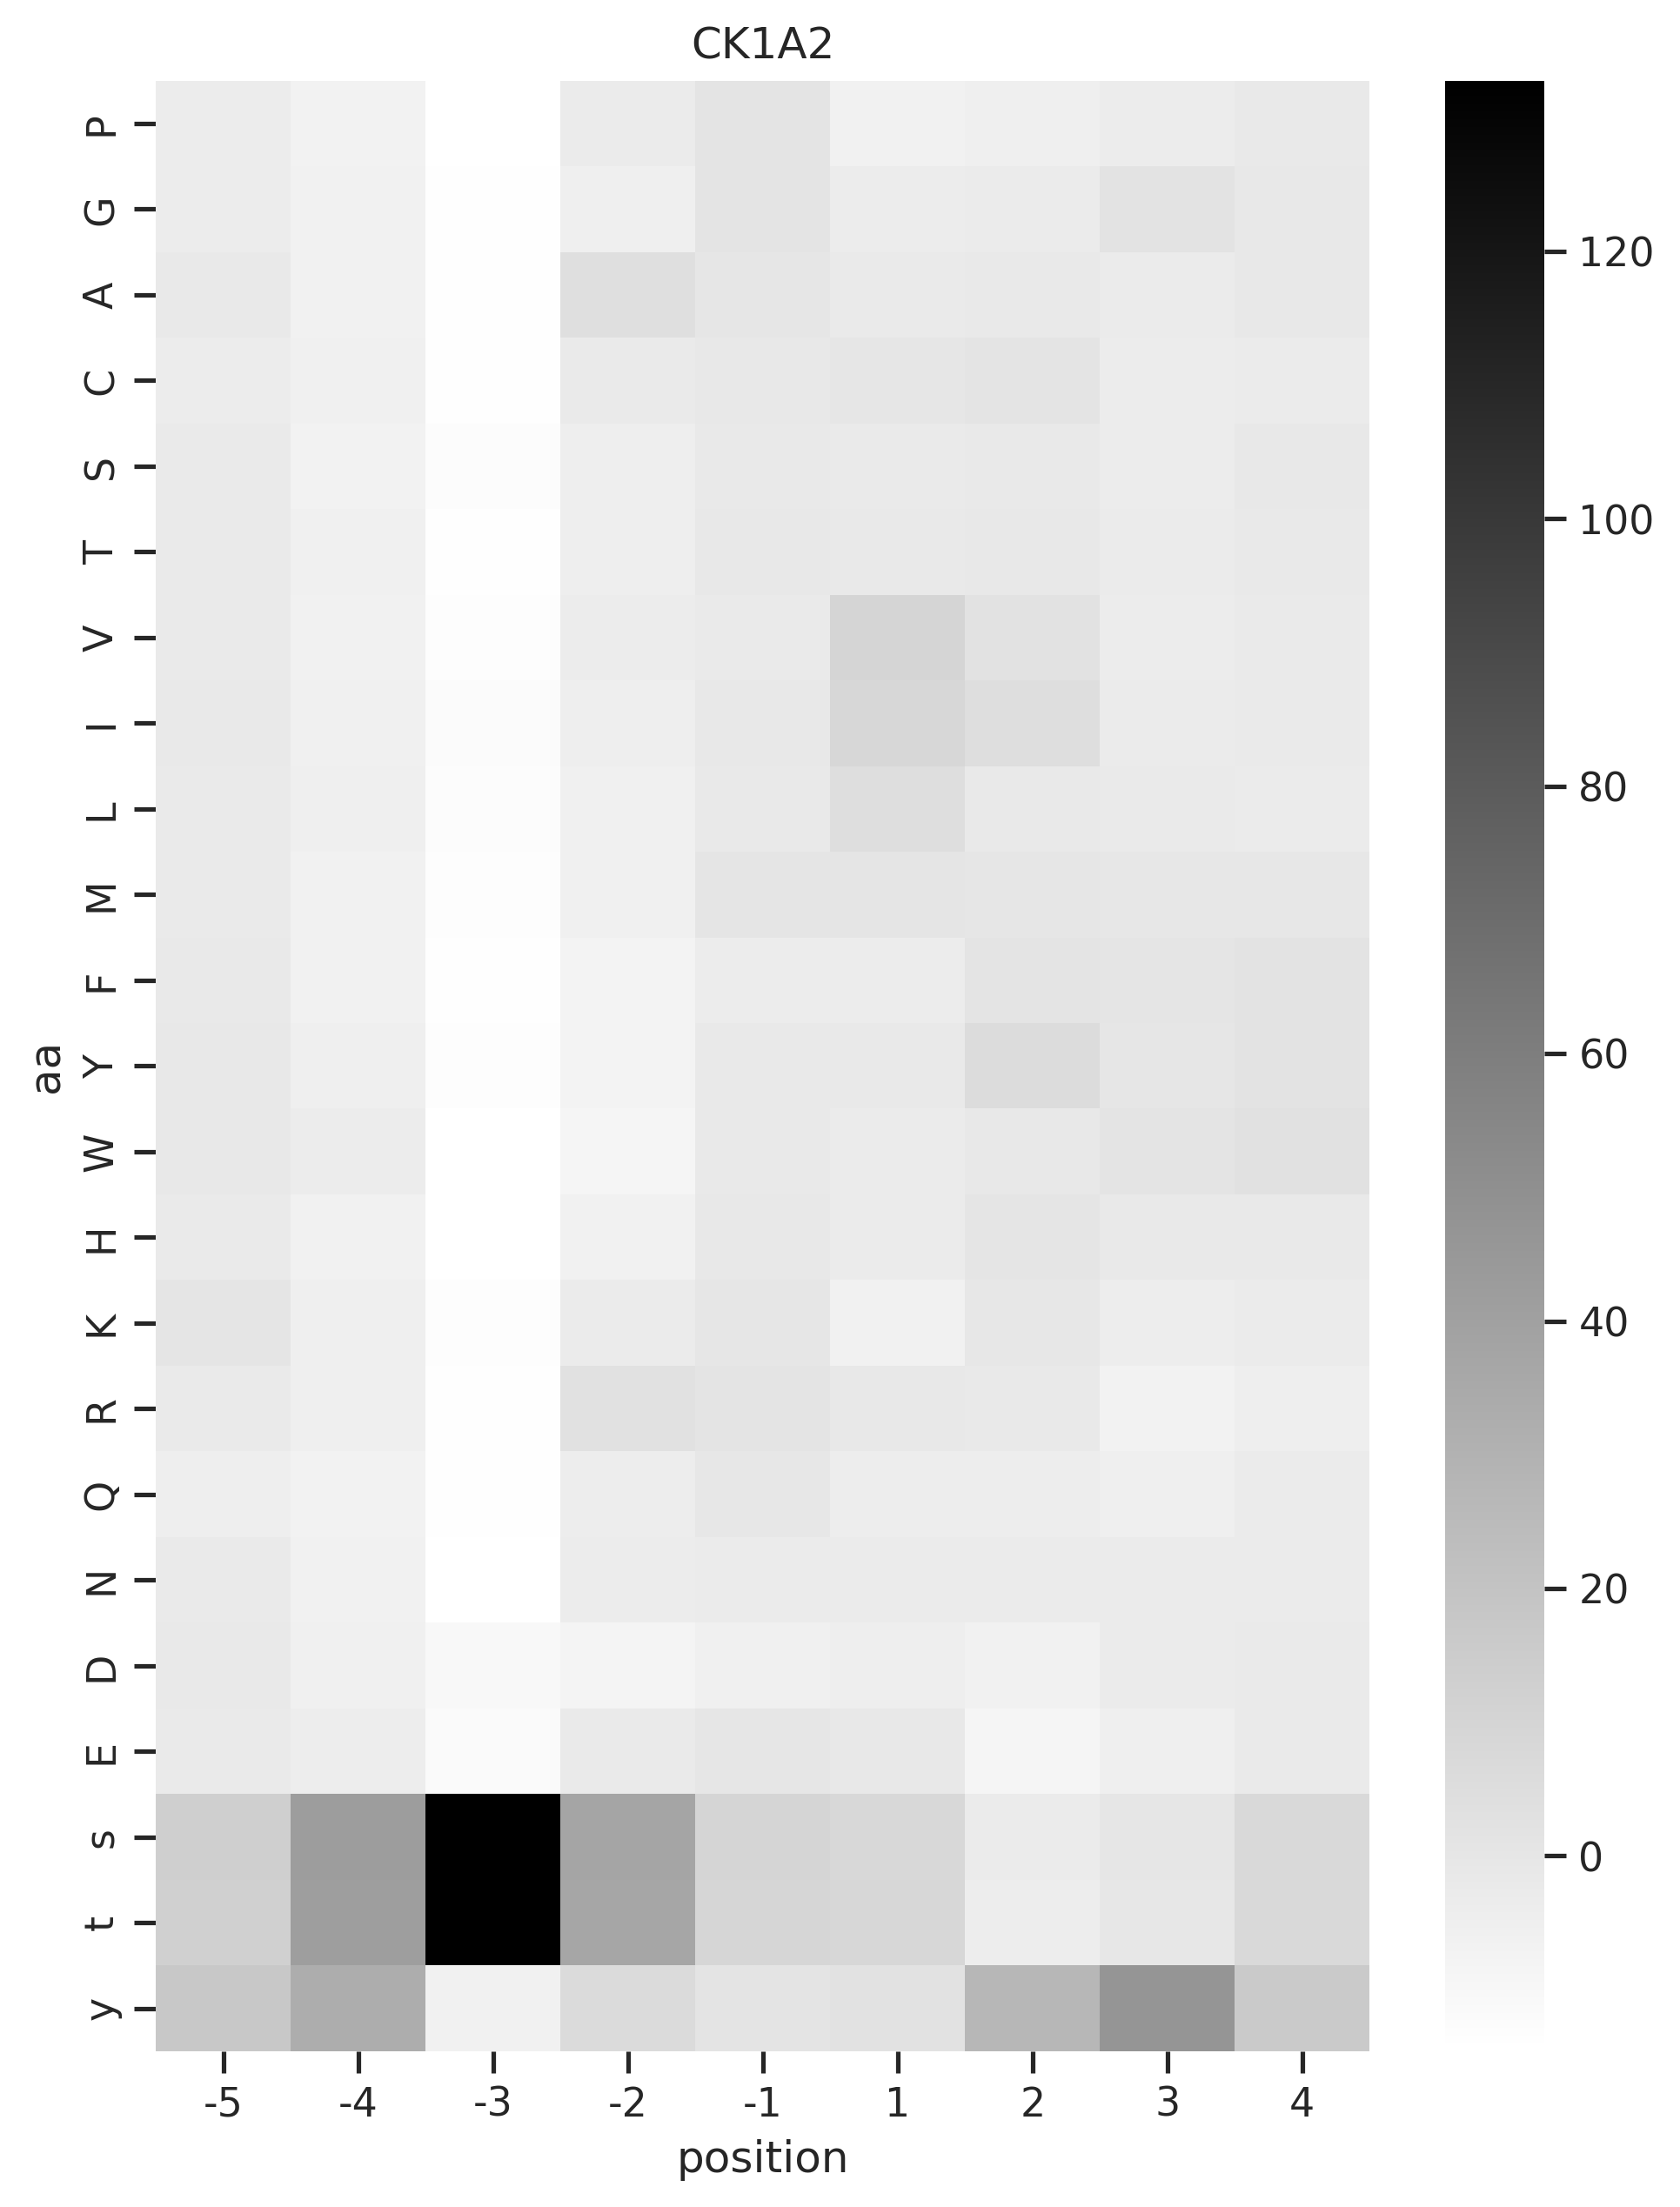

In [118]:
get_heatmap(preds.iloc[:,:-3],'CK1A2')

## Post-process

In [119]:
# remove kinase with duplicated name
preds= preds[~preds.index.duplicated()]

In [120]:
preds_minmax = MinMaxScaler().fit_transform(preds.T).T

In [121]:
data = []
for k in preds_minmax.index:
    w = get_one_kinase(preds_minmax,k,drop_s=False).T
    w = w/w.sum()
    w2 = w.unstack().reset_index(name=k)
    w2['substrate'] = w2.position.astype(str)+w2.aa
    w3 = w2.set_index('substrate')[k]
    data.append(w3)
    # break

In [122]:
preds_final = pd.concat(data,axis=1).T

preds_final = preds_final[target_col]

In [123]:
preds_final = preds_final[~preds_final.index.isin(t5.kinase)]

In [124]:
preds_final.index

Index(['ADCK1', 'ADCK2', 'COQ8A', 'COQ8B', 'ADCK5', 'ACVRL1', 'ACVR1C',
       'ALPK3', 'ALPK2', 'ARAF', 'CASK', 'CDK20', 'CDKL2', 'CDKL3', 'CDKL4',
       'STK35', 'PDIK1L', 'DCLK3', 'DDR1', 'CDC42BPG', 'STK17B', 'ERBB2',
       'MAPK6', 'MAPK4', 'STK36', 'TNNI3K', 'AATK', 'LMTK2', 'LMTK3', 'LRRK1',
       'MAP3K13', 'MAP2K6', 'MAP3K4', 'MAST1', 'MAST2', 'MAST3', 'MAST4',
       'AMHR2', 'PKMYT1', 'NEK10', 'NRK', 'PDHK3', 'CDK15', 'PIK3R4', 'CDK11B',
       'PSKH1', 'RIOK1', 'RIOK2', 'RIOK3', 'RNASEL', 'ROR1', 'ROR2', 'SBK2',
       'SBK3', 'ANKK1', 'RSKR', 'SPEG', 'TESK2', 'TIE1', 'KALRN', 'TRIO',
       'TSSK3', 'TSSK4', 'WEE2', 'STK32A'],
      dtype='object')

In [126]:
# preds_final.to_parquet('raw/predicted.parquet')

In [127]:
# or directly load
preds_final = pd.read_parquet('raw/predicted.parquet')

## Select kinase families with high oof Pearson scores

In [128]:
family_score = pd.read_csv('raw/oof_corr_family.csv').rename(columns={'kinase':'family_count','Pearson':'Pearson_family'})
subfamily_score = pd.read_csv('raw/oof_corr_subfamily.csv').rename(columns={'kinase':'subfamily_count','Pearson':'Pearson_subfamily'})

In [129]:
family_score

family  Pearson_family  family_count
0     ALK        0.968724             2
1     Abl        0.959211             2
2     Ack        0.830424             2
3     Akt        0.974935             3
4   Alpha        0.198162             4
..    ...             ...           ...
95  VEGFR        0.964378             3
96    VRK        0.651387             2
97    WEE       -0.090115             1
98    WNK        0.618240             4
99   YANK        0.816684             2

[100 rows x 3 columns]

In [130]:
preds_info = pd.DataFrame(preds_final.index,columns=['kinase']).merge(df,'left')

In [132]:
preds_info = preds_info.merge(family_score,'left')
preds_info = preds_info.merge(subfamily_score,'left')

In [133]:
preds_info = preds_info[['kinase','ID_coral','uniprot','ID_HGNC',
                         'group','family','subfamily',
                         'Pearson_family','family_count',
                         'Pearson_subfamily','subfamily_count'
                        ]]

In [134]:
selected = pd.read_csv('raw/pred_kinase.csv')

In [141]:
selected_df = preds_info[preds_info.kinase.isin(selected.kinase)]
selected_df

kinase  ID_coral uniprot   ID_HGNC     group  family subfamily  \
5     ACVRL1      ALK1  P37023    ACVRL1       TKL    STKR     STKR1   
6     ACVR1C      ALK7  Q8NER5    ACVR1C       TKL    STKR     STKR1   
11     CDK20      CCRK  Q8IZL9     CDK20      CMGC     CDK       CDK   
12     CDKL2     CDKL2  Q92772     CDKL2      CMGC    CDKL      CDKL   
13     CDKL3     CDKL3  Q8IVW4     CDKL3      CMGC    CDKL      CDKL   
14     CDKL4     CDKL4  Q5MAI5     CDKL4      CMGC    CDKL      CDKL   
17     DCLK3   DCAMKL3  Q9C098     DCLK3      CAMK  DCAMKL    DCAMKL   
19  CDC42BPG     DMPK2  Q6DT37  CDC42BPG       AGC    DMPK       GEK   
20    STK17B     DRAK2  O94768    STK17B      CAMK    DAPK      DAPK   
22     MAPK6      Erk3  Q16659     MAPK6      CMGC    MAPK      ERK3   
23     MAPK4      Erk4  P31152     MAPK4      CMGC    MAPK      ERK3   
25    TNNI3K     HH498  Q59H18    TNNI3K       TKL     MLK     HH498   
30   MAP3K13       LZK  O43283   MAP3K13       TKL     MLK       LZK   
32    MAP3K4    MAP3K4  Q9Y6R4    MAP3K4       STE   STE11     STE11   
37     AMHR2     MISR2  Q16671     AMHR2       TKL    STKR     STKR2   
39     NEK10     NEK10  Q6ZWH5     NEK10     Other     NEK       NEK   
40       NRK       NRK  Q7Z2Y5       NRK       STE   STE20       MSN   
41     PDHK3     PDHK3  Q15120      PDK3  Atypical    PDHK      PDHK   
42     CDK15  PFTAIRE2  Q96Q40     CDK15      CMGC     CDK   PFTAIRE   
44    CDK11B   PITSLRE  P21127    CDK11B      CMGC     CDK     CDK11   
52      SBK2    SgK069  P0C263      SBK2     Other    NKF1      NKF1   
53      SBK3    SgK110  P0C264      SBK3     Other    NKF1      NKF1   
54     ANKK1    SgK288  Q8NFD2     ANKK1       TKL    RIPK      RIPK   
57     TESK2     TESK2  Q96S53     TESK2       TKL    LISK      TESK   
61     TSSK3     TSSK3  Q96PN8     TSSK3      CAMK    TSSK      TSSK   
62     TSSK4     TSSK4  Q6SA08     TSSK4      CAMK    TSSK      TSSK   
64    STK32A     YANK1  Q8WU08    STK32A       AGC    YANK      YANK   

    Pearson_family  family_count  Pearson_subfamily  subfamily_count  
5         0.857840           9.0           0.908758              5.0  
6         0.857840           9.0           0.908758              5.0  
11        0.923265          17.0                NaN              NaN  
12        0.763117           2.0           0.763117              2.0  
13        0.763117           2.0           0.763117              2.0  
14        0.763117           2.0           0.763117              2.0  
17        0.901985           2.0           0.901985              2.0  
19        0.954669           6.0           0.961369              3.0  
20        0.792083           4.0           0.792083              4.0  
22        0.881876          12.0                NaN              NaN  
23        0.881876          12.0                NaN              NaN  
25        0.733784           7.0                NaN              NaN  
30        0.733784           7.0           0.497632              1.0  
32        0.749903           7.0           0.749903              7.0  
37        0.857840           9.0           0.794193              4.0  
39        0.778235          10.0           0.778235             10.0  
40        0.863932          27.0           0.945743              3.0  
41        0.676690           3.0           0.676690              3.0  
42        0.923265          17.0           0.949171              1.0  
44        0.923265          17.0                NaN              NaN  
52        0.734262           1.0           0.734262              1.0  
53        0.734262           1.0           0.734262              1.0  
54        0.627125           4.0           0.627125              4.0  
57        0.576401           3.0           0.099881              1.0  
61        0.847705           3.0           0.847705              3.0  
62        0.847705           3.0           0.847705              3.0  
64        0.816684           2.0           0.816684              2.0

In [153]:
# selected = preds_info[preds_info['Pearson_family']>=0.55]\
# .sort_values('Pearson_family',ascending=False)\
# .query('group!="TK"')

# # Remove MAP2K families, as it is potentially contaminated with MAPK families
# selected = selected[~selected.kinase.str.startswith('MAP2')]

In [154]:
len(selected)

29

To save PSSMs:

In [71]:
preds_final.index

Index(['ADCK1', 'ADCK2', 'COQ8A', 'COQ8B', 'ADCK5', 'ACVRL1', 'ACVR1C',
       'ALPK3', 'ALPK2', 'ARAF', 'CASK', 'CDK20', 'CDKL2', 'CDKL3', 'CDKL4',
       'STK35', 'PDIK1L', 'DCLK3', 'DDR1', 'CDC42BPG', 'STK17B', 'ERBB2',
       'MAPK6', 'MAPK4', 'STK36', 'TNNI3K', 'AATK', 'LMTK2', 'LMTK3', 'LRRK1',
       'MAP3K13', 'MAP2K6', 'MAP3K4', 'MAST1', 'MAST2', 'MAST3', 'MAST4',
       'AMHR2', 'PKMYT1', 'NEK10', 'NRK', 'CDK15', 'PIK3R4', 'CDK11B', 'PSKH1',
       'RIOK1', 'RIOK2', 'RIOK3', 'RNASEL', 'ROR1', 'ROR2', 'SBK2', 'SBK3',
       'ANKK1', 'RSKR', 'SPEG', 'TESK2', 'TIE1', 'KALRN', 'TRIO', 'TSSK3',
       'TSSK4', 'WEE2', 'STK32A'],
      dtype='object')

In [137]:
selected_PSSM = preds_final.loc[selected.kinase]

In [139]:
selected_PSSM.to_csv('source/Supplementary_table3_predicted_PSSM.csv')

In [140]:
preds_final

substrate       -5P       -5G       -5A       -5C       -5S       -5T  \
ADCK1      0.048353  0.044662  0.049684  0.047756  0.039644  0.038732   
ADCK2      0.045721  0.039397  0.046075  0.048963  0.039347  0.039411   
COQ8A      0.047078  0.049584  0.046538  0.046978  0.038505  0.039265   
COQ8B      0.046490  0.047984  0.047754  0.047483  0.039761  0.038309   
ADCK5      0.049543  0.047891  0.053344  0.047442  0.039538  0.039139   
...             ...       ...       ...       ...       ...       ...   
TRIO       0.049070  0.047619  0.050919  0.036940  0.039468  0.036601   
TSSK3      0.058653  0.025380  0.066570  0.056317  0.037207  0.036167   
TSSK4      0.052728  0.027791  0.059114  0.053775  0.036460  0.036364   
WEE2       0.043967  0.075610  0.066270  0.022744  0.035380  0.016544   
STK32A     0.042088  0.048958  0.043909  0.042148  0.039149  0.039619   

substrate       -5V       -5I       -5L       -5M       -5F       -5Y  \
ADCK1      0.041271  0.037347  0.041508  0.038331  0.053608  0.049934   
ADCK2      0.037317  0.039063  0.038259  0.038223  0.050568  0.046183   
COQ8A      0.038297  0.027514  0.025965  0.034214  0.046496  0.053125   
COQ8B      0.038994  0.028313  0.026969  0.035838  0.042184  0.050925   
ADCK5      0.037515  0.030666  0.034010  0.034438  0.048031  0.047656   
...             ...       ...       ...       ...       ...       ...   
TRIO       0.037051  0.039088  0.055922  0.033747  0.037797  0.037885   
TSSK3      0.080225  0.075408  0.115814  0.049548  0.037163  0.036261   
TSSK4      0.077692  0.076985  0.115165  0.056947  0.044673  0.036815   
WEE2       0.036876  0.052500  0.080799  0.022085  0.026341  0.022279   
STK32A     0.035109  0.038230  0.032561  0.036990  0.039822  0.044389   

substrate       -5W       -5H       -5K       -5R       -5Q       -5N  \
ADCK1      0.062422  0.053521  0.049245  0.060374  0.029276  0.031936   
ADCK2      0.060257  0.053303  0.053477  0.059690  0.032951  0.037253   
COQ8A      0.061218  0.063530  0.050068  0.057296  0.030144  0.036608   
COQ8B      0.056083  0.059763  0.058692  0.067034  0.035713  0.038473   
ADCK5      0.058163  0.057253  0.053287  0.060471  0.032071  0.034439   
...             ...       ...       ...       ...       ...       ...   
TRIO       0.040365  0.047620  0.089619  0.104386  0.035882  0.035138   
TSSK3      0.024276  0.026531  0.046915  0.083276  0.037862  0.020326   
TSSK4      0.035141  0.033569  0.040793  0.060000  0.034332  0.024112   
WEE2       0.018525  0.029408  0.080315  0.075319  0.040636  0.042321   
STK32A     0.042409  0.046752  0.047287  0.052673  0.036711  0.042259   

substrate       -5D       -5E       -5s       -5t       -5y       -4P  \
ADCK1      0.034305  0.029565  0.038343  0.035231  0.044951  0.044934   
ADCK2      0.037623  0.035300  0.040233  0.038882  0.042505  0.038253   
COQ8A      0.041208  0.034382  0.040725  0.038488  0.052773  0.051598   
COQ8B      0.037042  0.033089  0.039843  0.037535  0.045730  0.051322   
ADCK5      0.040639  0.036601  0.039099  0.036382  0.042382  0.046010   
...             ...       ...       ...       ...       ...       ...   
TRIO       0.027533  0.026947  0.029696  0.027546  0.033160  0.040242   
TSSK3      0.007830  0.007382  0.021717  0.022070  0.027101  0.027753   
TSSK4      0.013683  0.011410  0.022643  0.021738  0.028070  0.029160   
WEE2       0.066750  0.054230  0.031021  0.028095  0.031986  0.042869   
STK32A     0.042804  0.037494  0.053057  0.054500  0.061083  0.043605   

substrate       -4G       -4A       -4C       -4S       -4T       -4V  \
ADCK1      0.055889  0.053259  0.051039  0.040561  0.039071  0.029120   
ADCK2      0.046895  0.046298  0.050421  0.040807  0.040307  0.026036   
COQ8A      0.054722  0.051946  0.053349  0.041256  0.040011  0.028248   
COQ8B      0.054295  0.053244  0.051641  0.041342  0.041967  0.029125   
ADCK5      0.055103  0.051187  0.048136  0.040229  0.039656  0.026984   
...             ...       ...       ...       ...     

## Visualize predicted PSSMs

STKR:0.8578397866239376


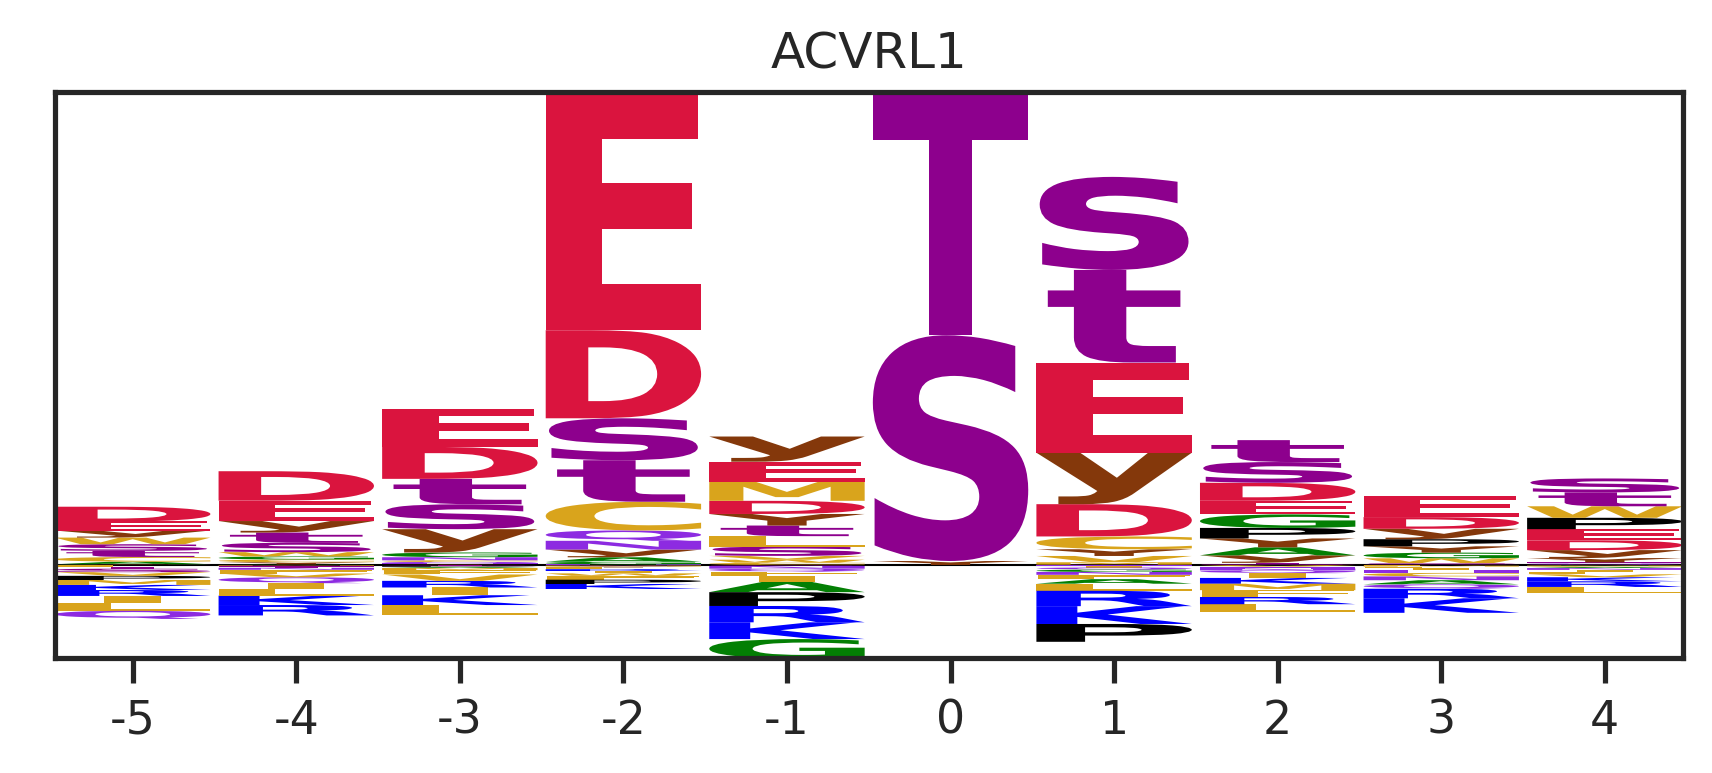

STKR:0.8578397866239376


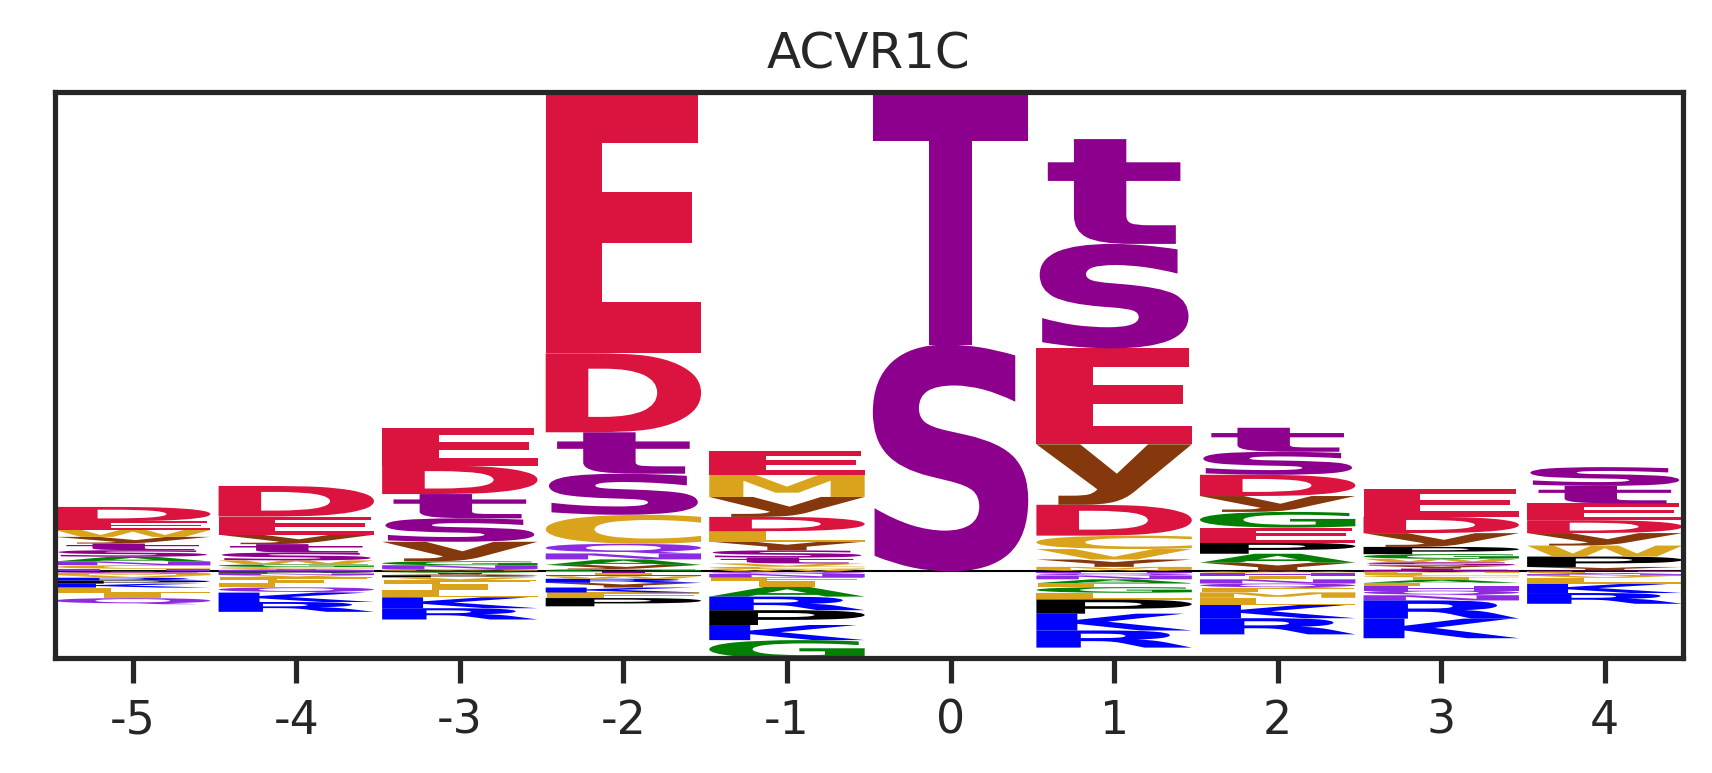

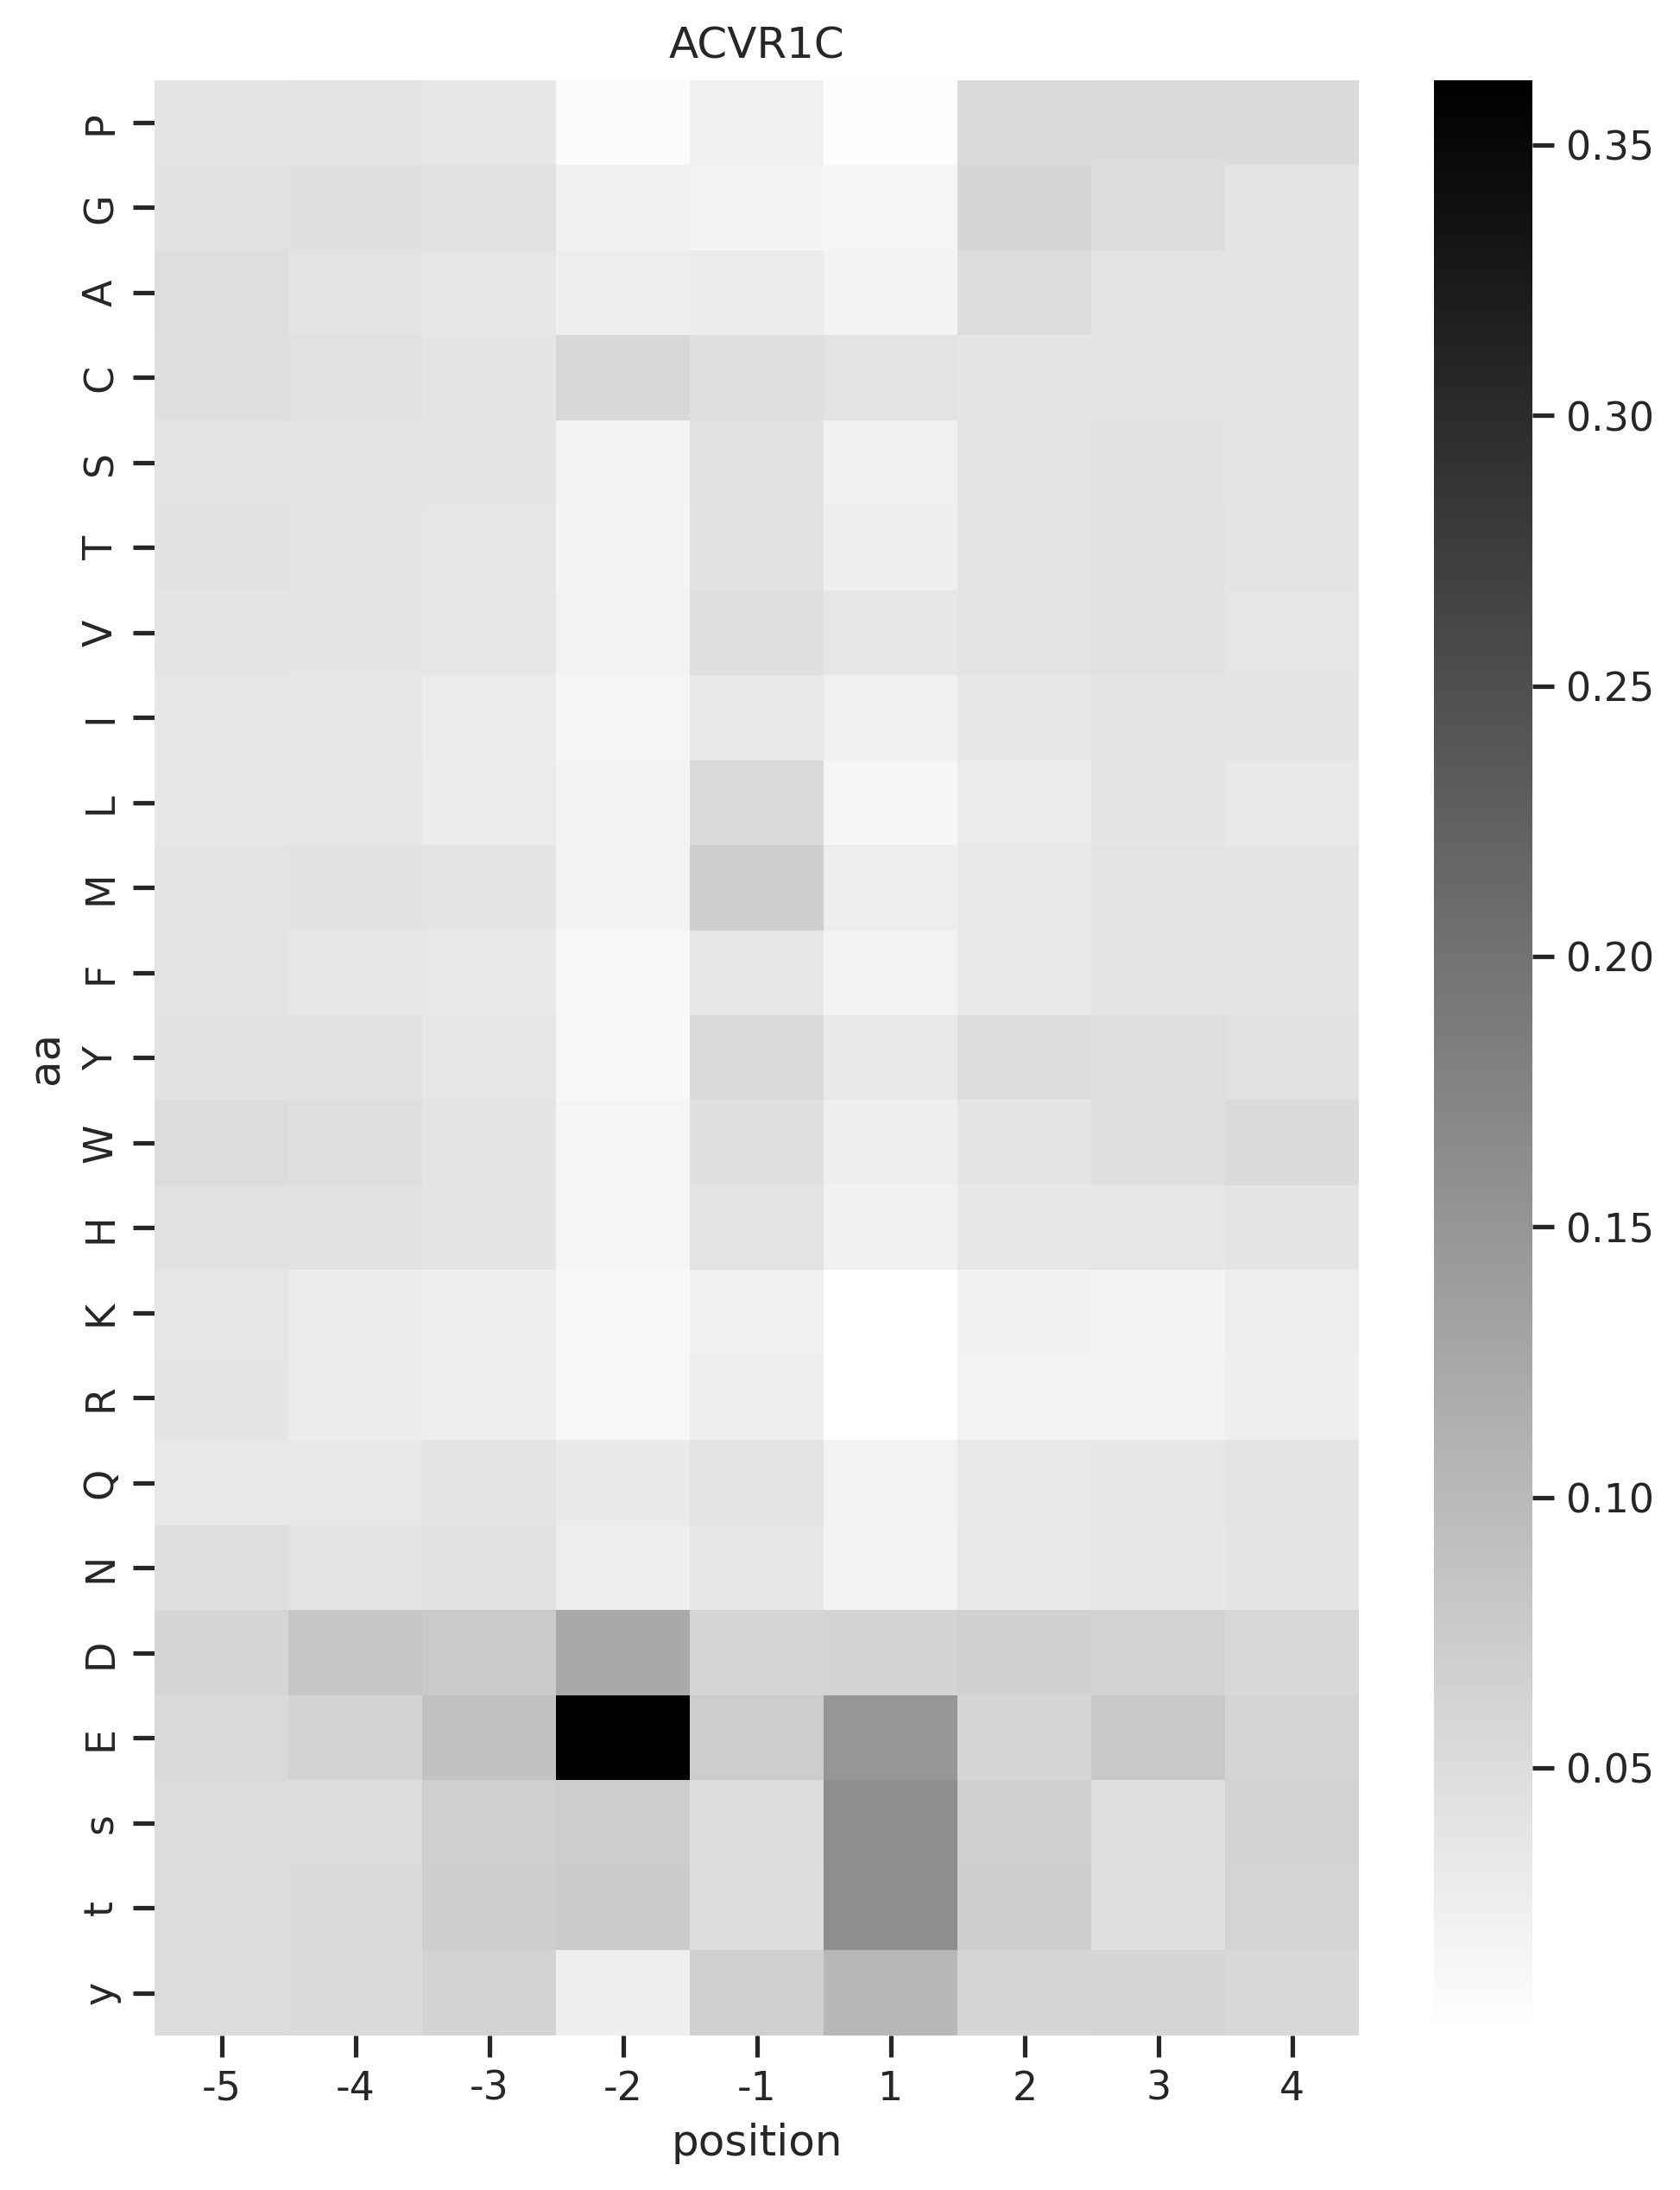

CDK:0.9232645242649458


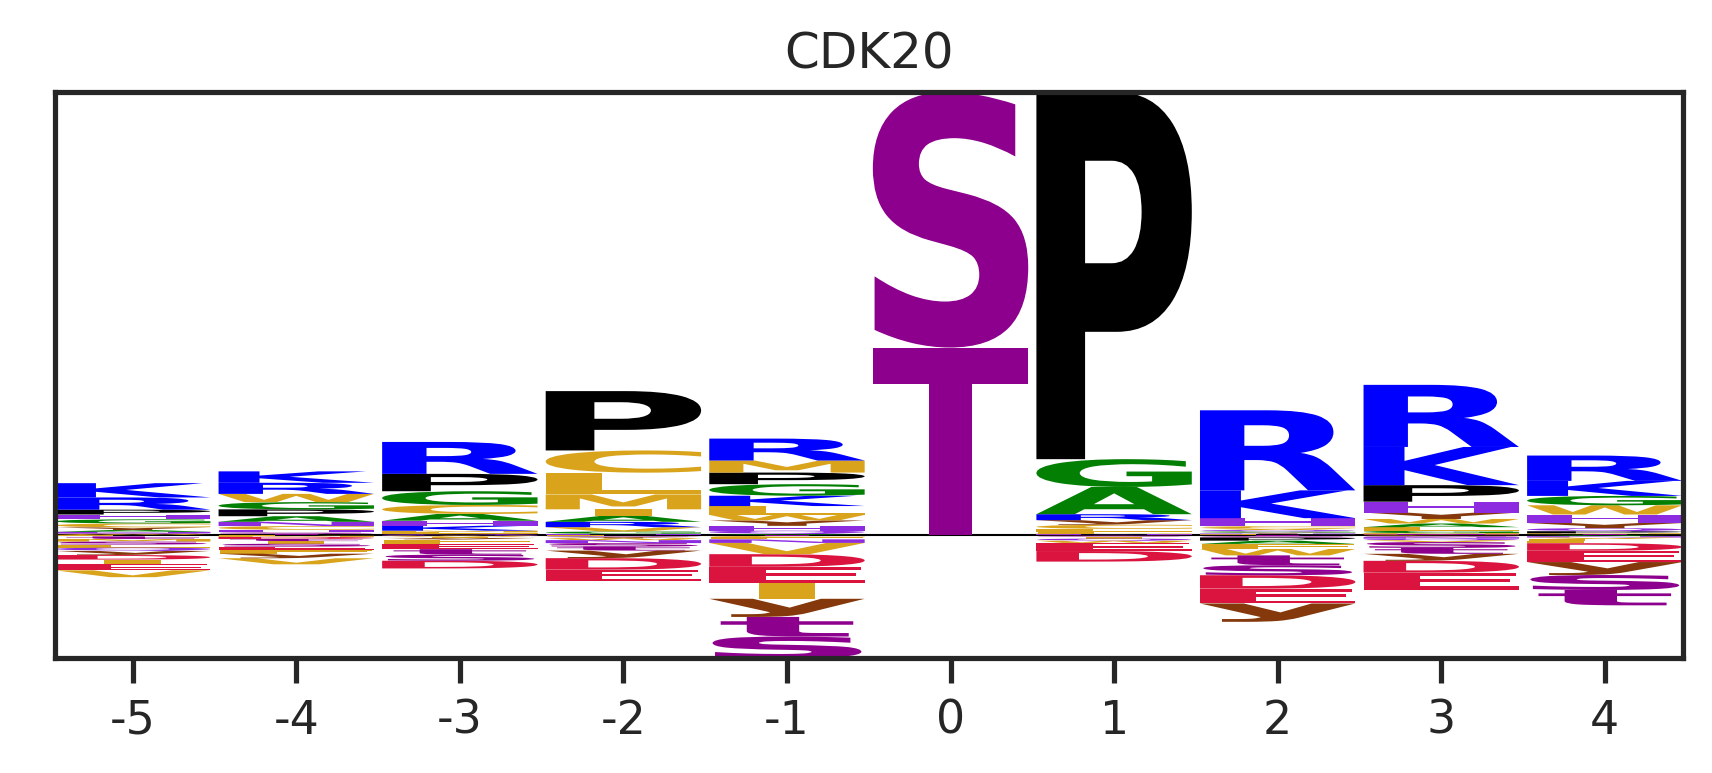

CDKL:0.76311665060942


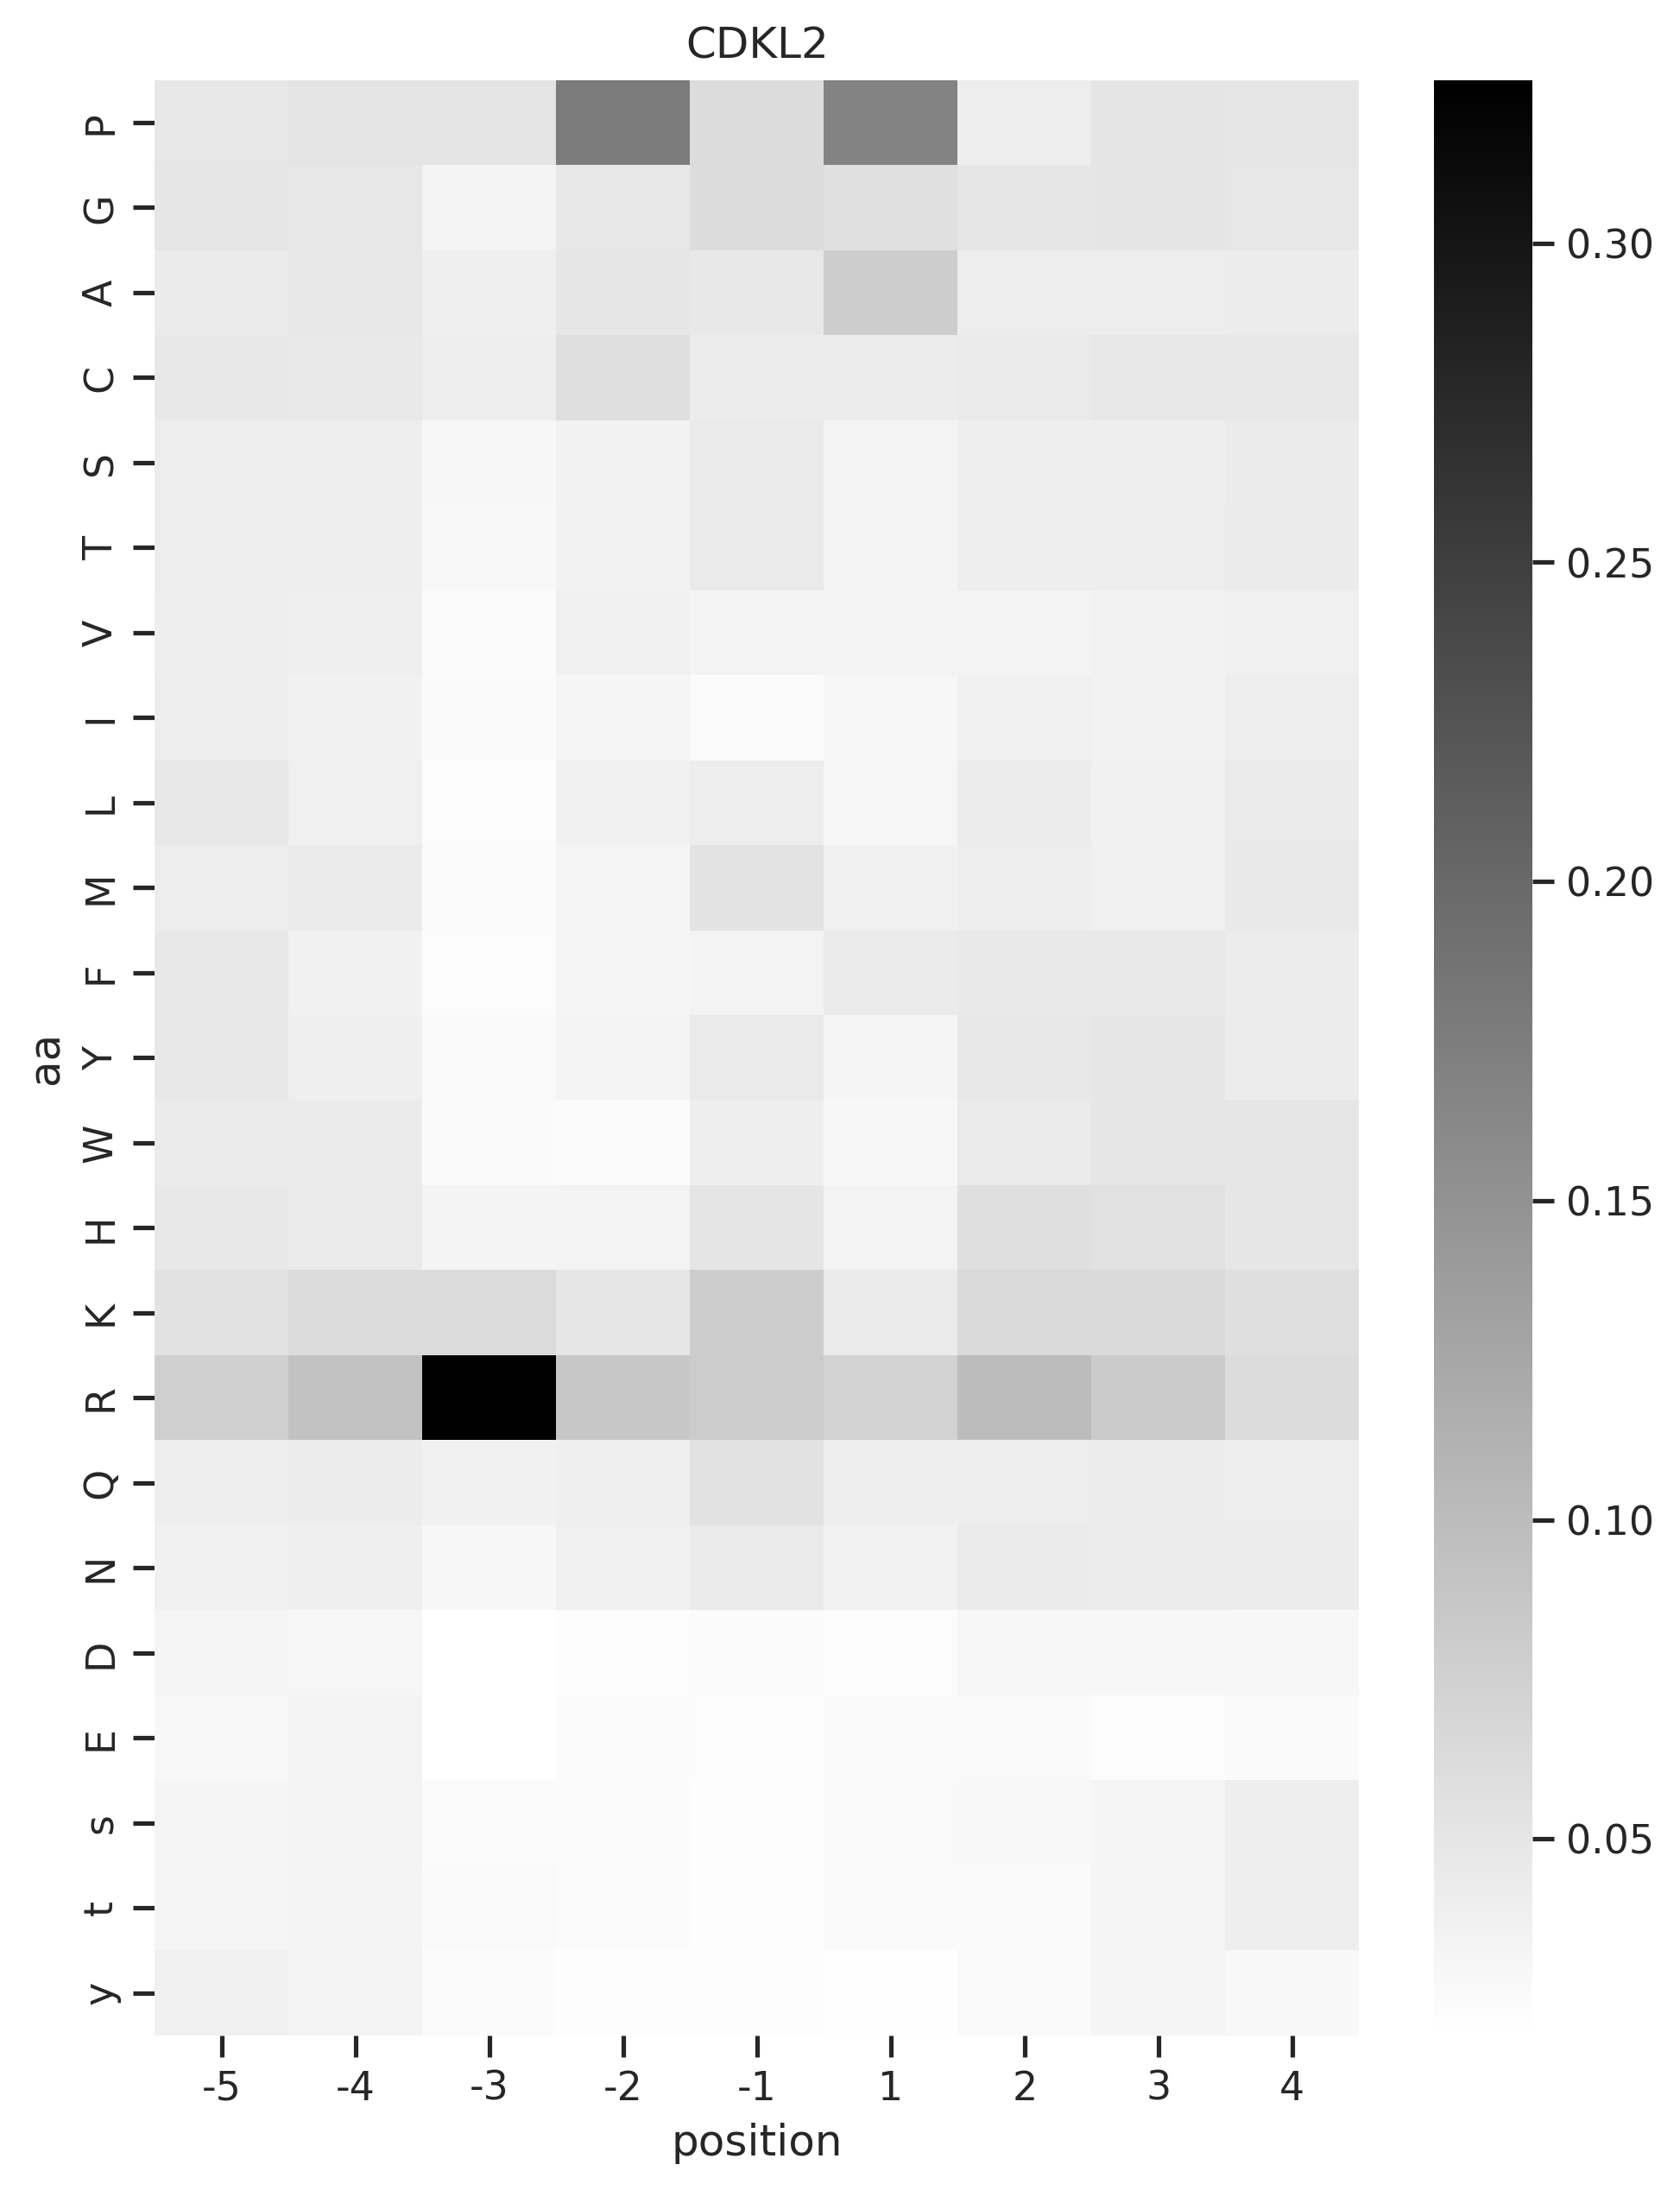

CDKL:0.76311665060942


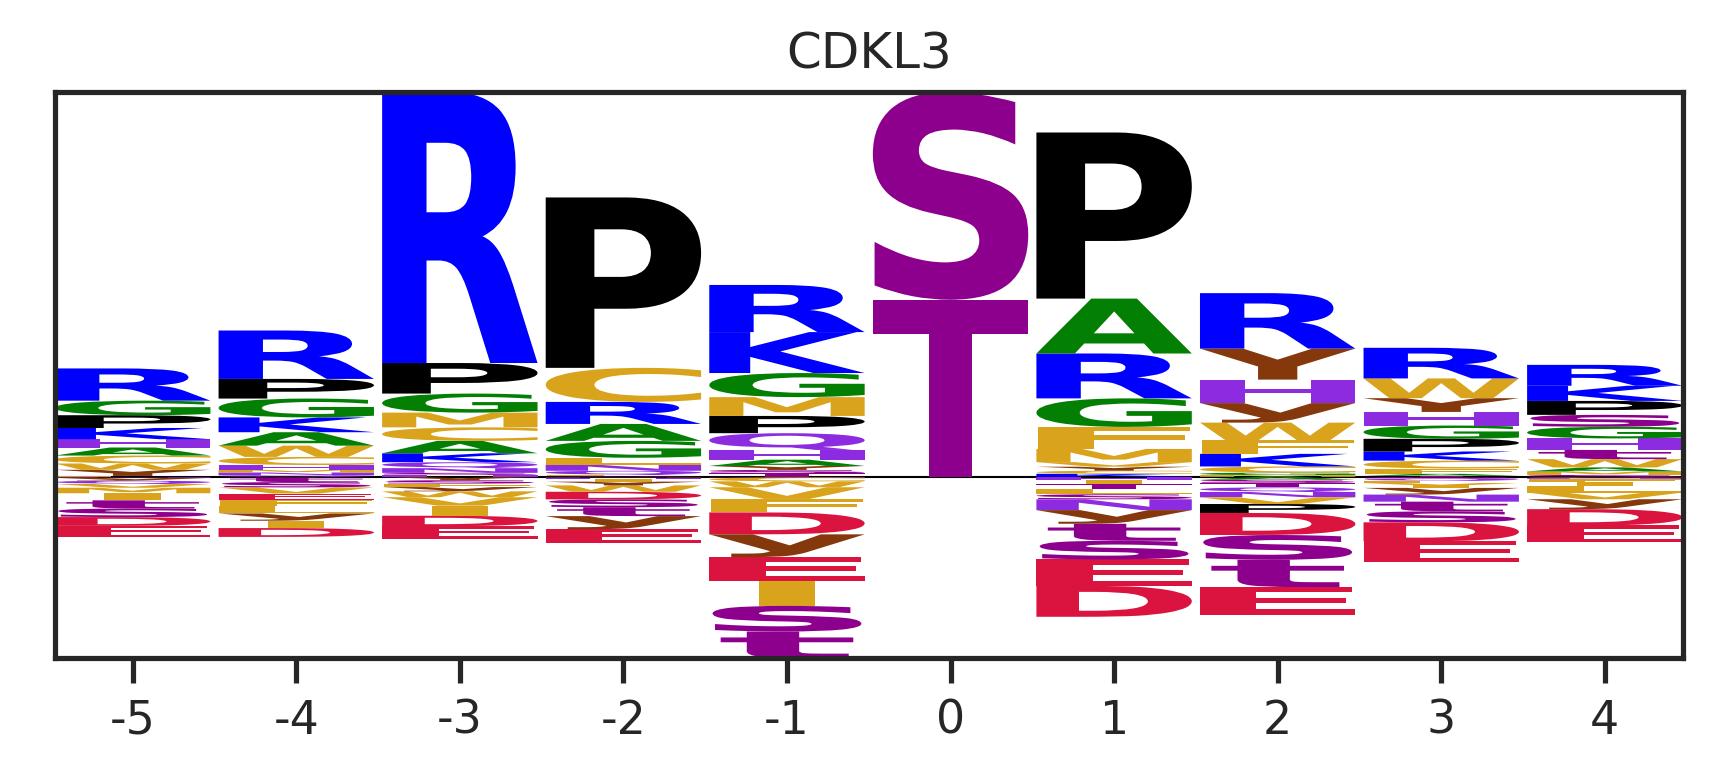

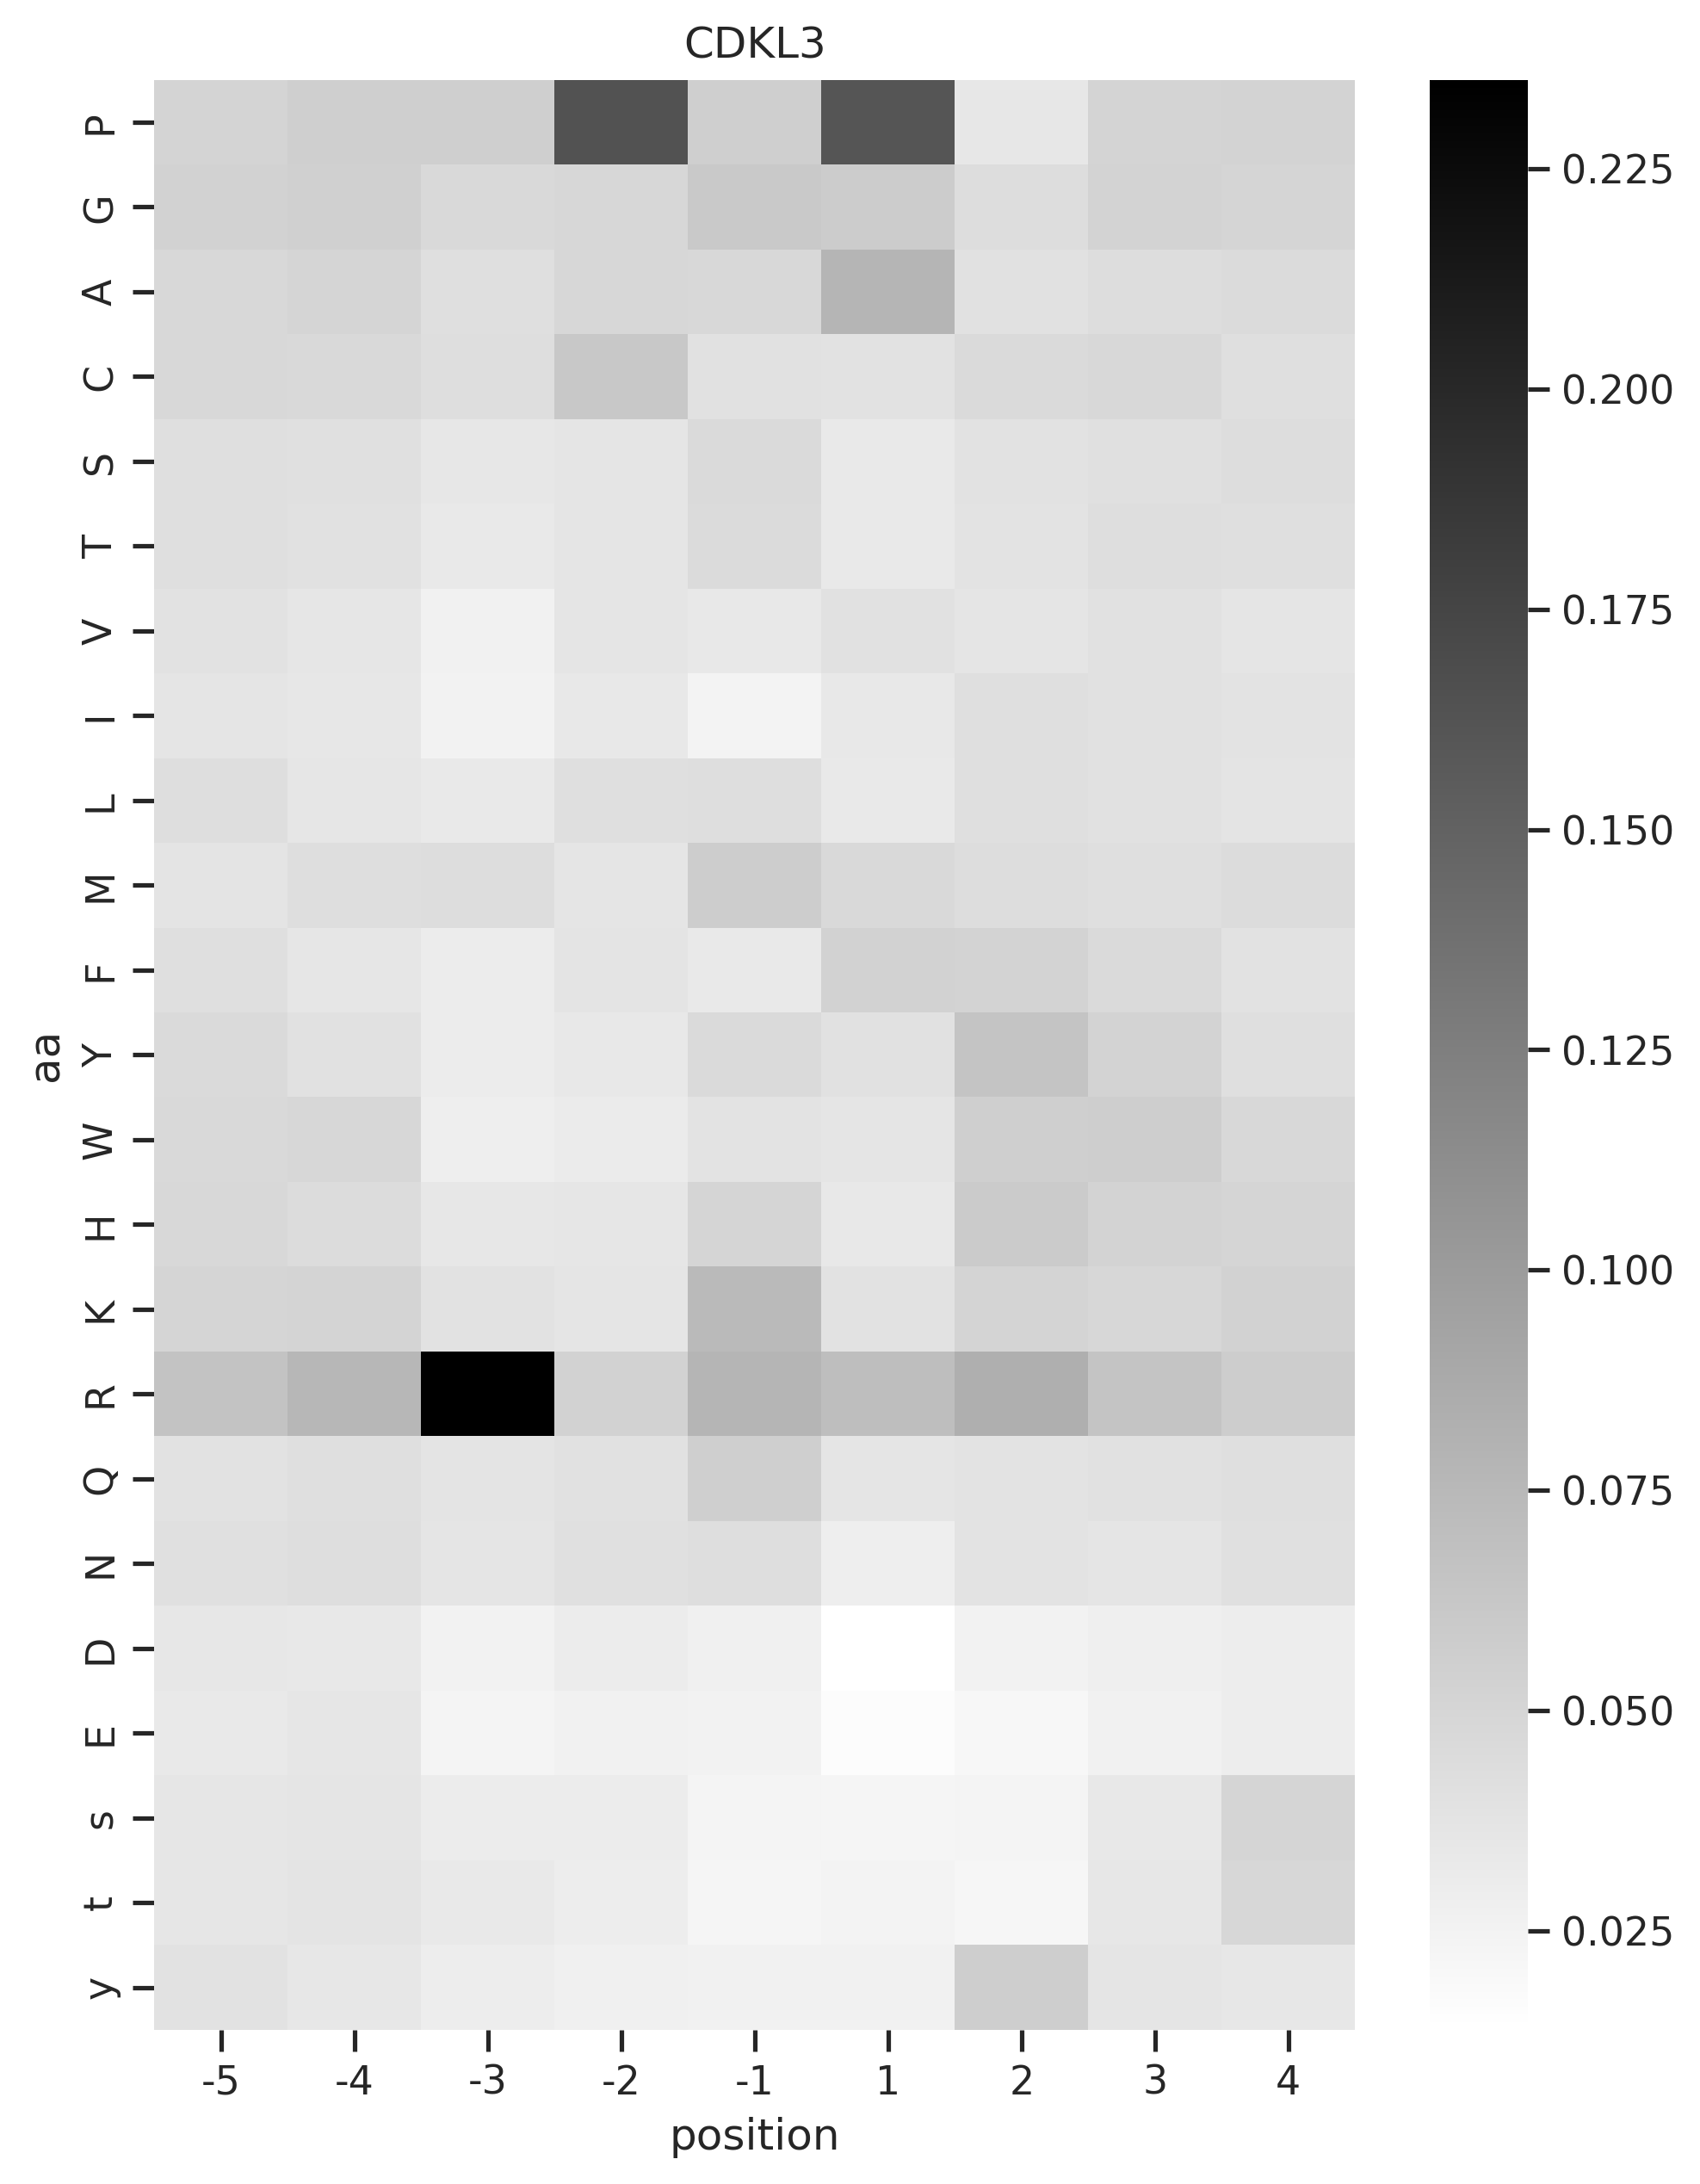

CDKL:0.76311665060942


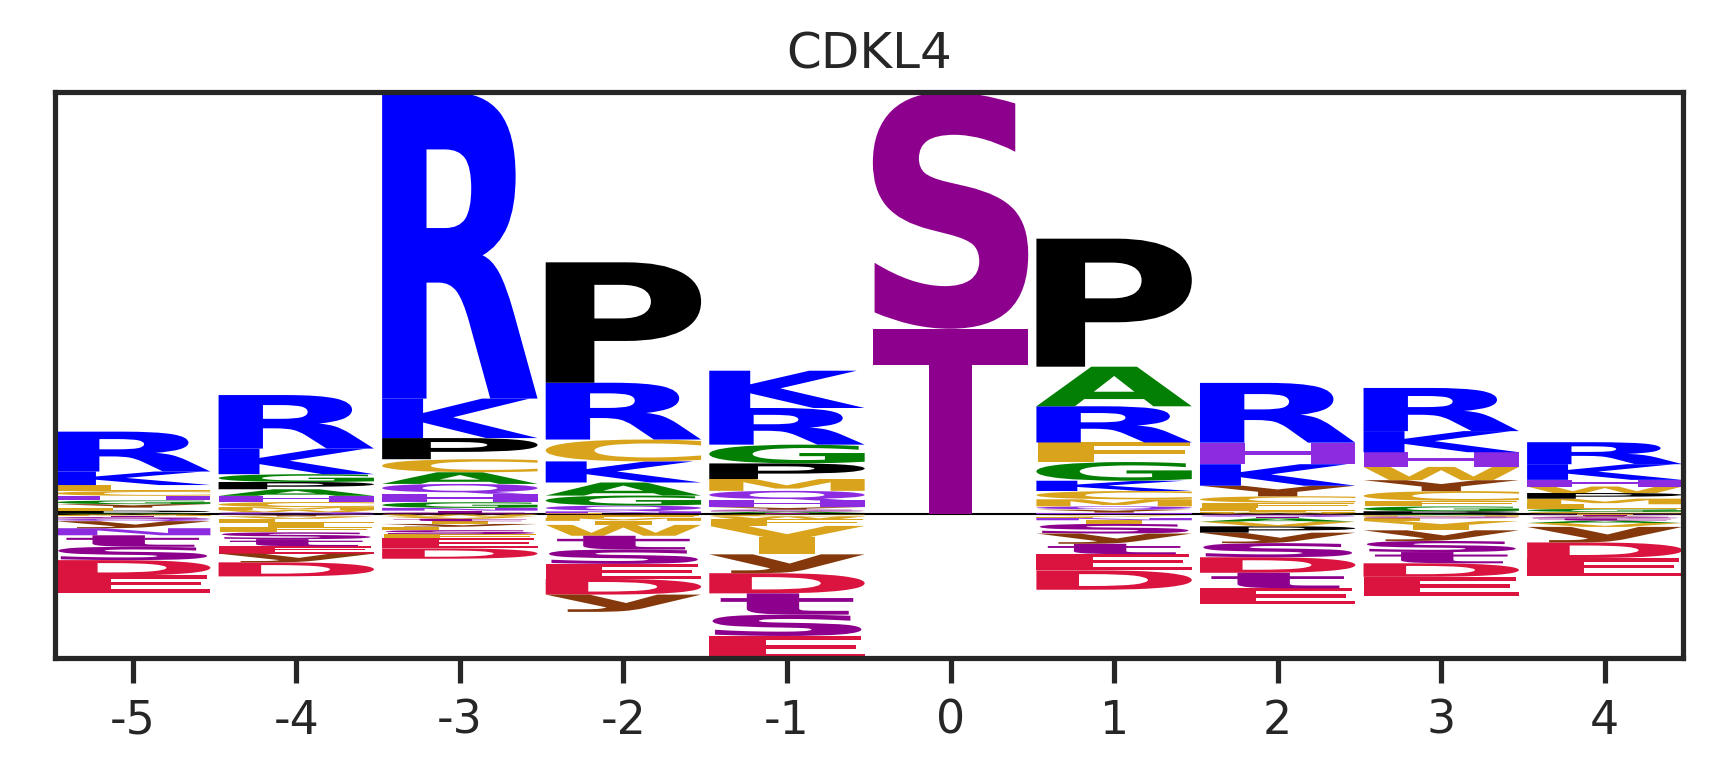

DCAMKL:0.9019845007257056


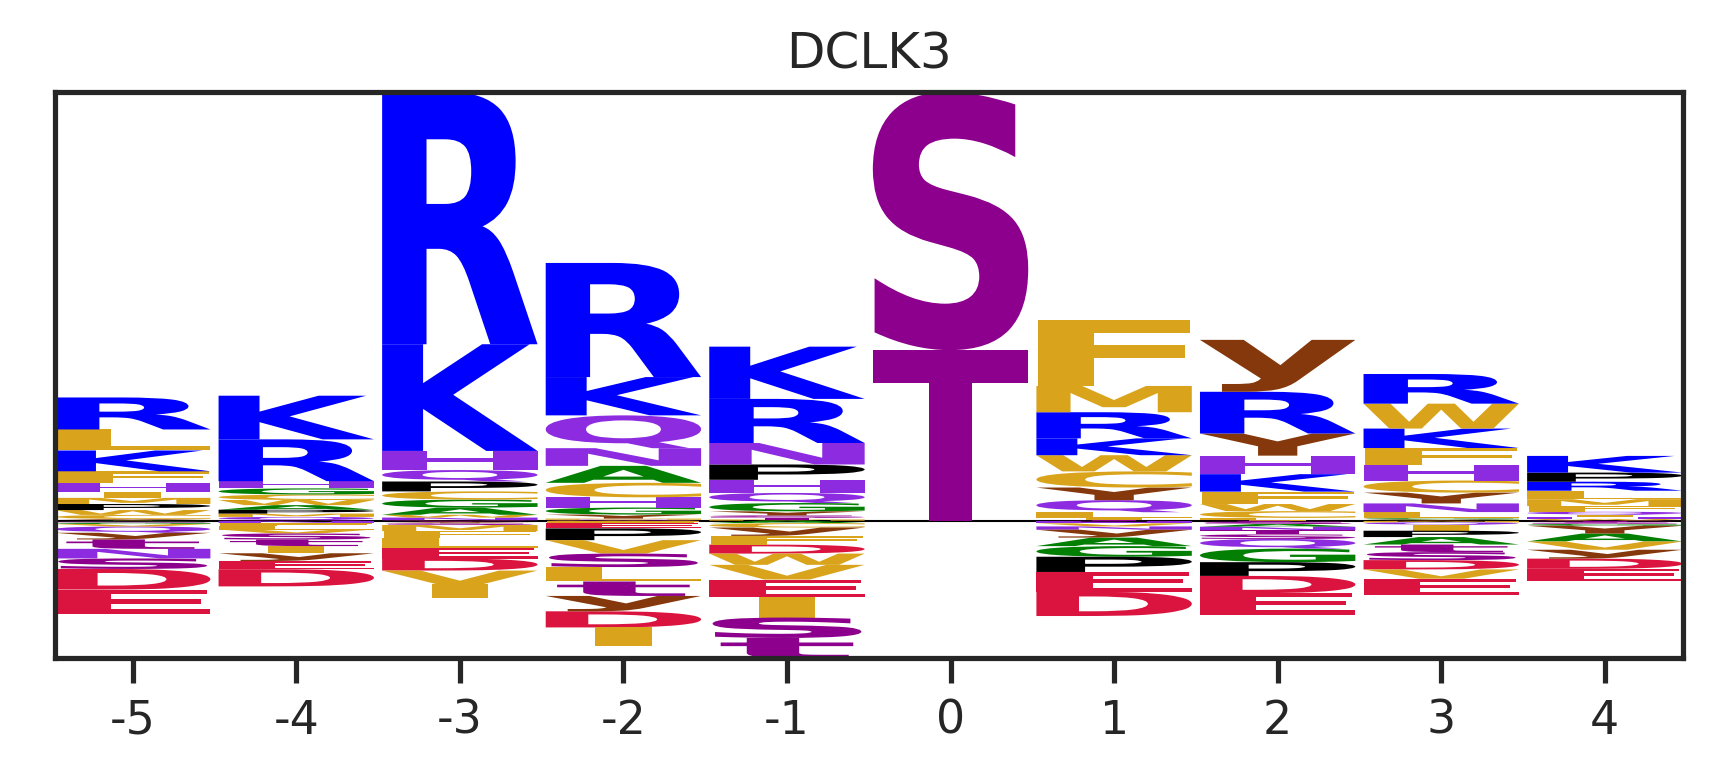

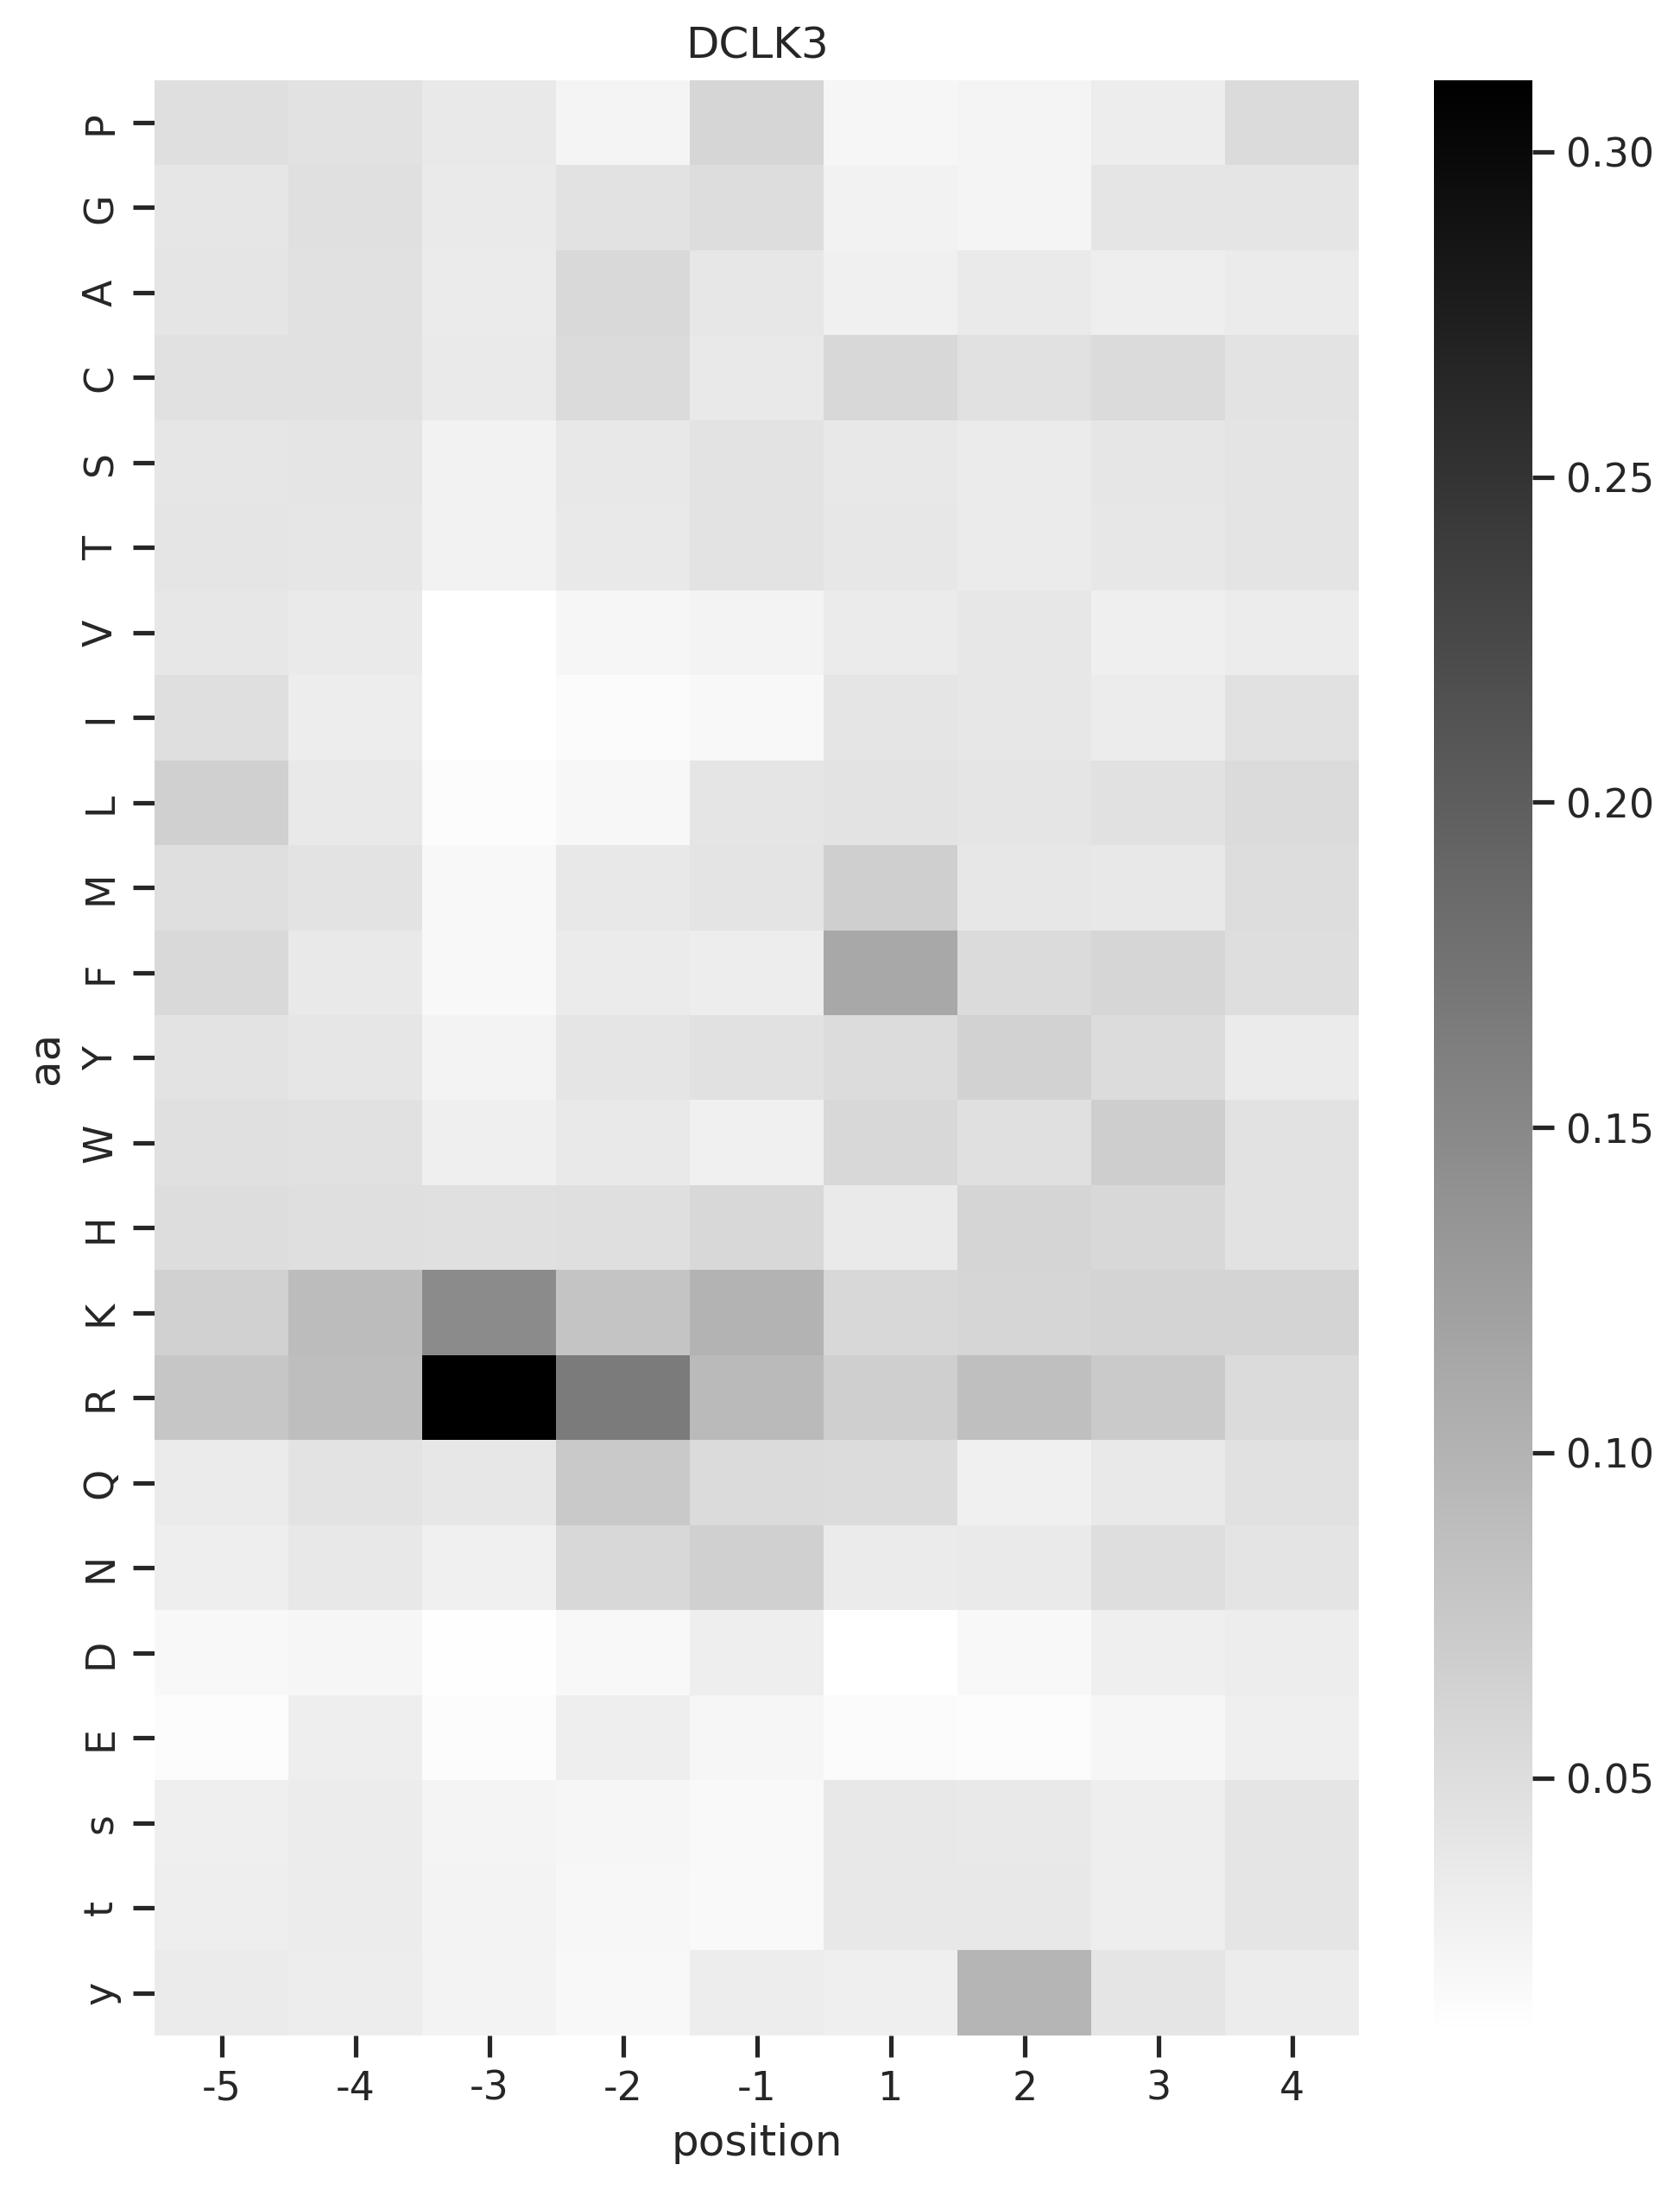

DMPK:0.9546690741027648


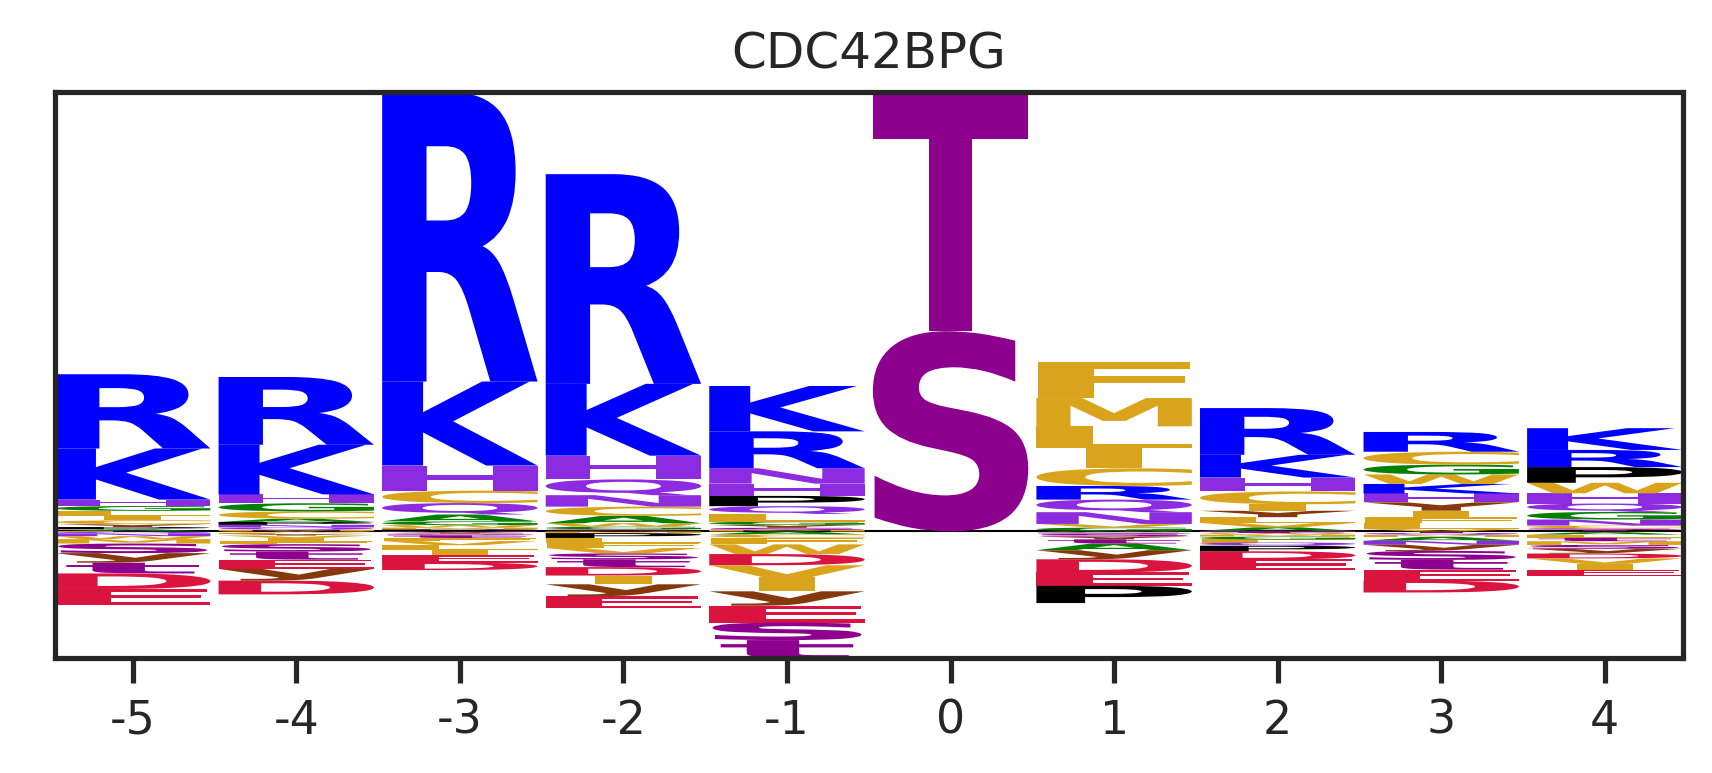

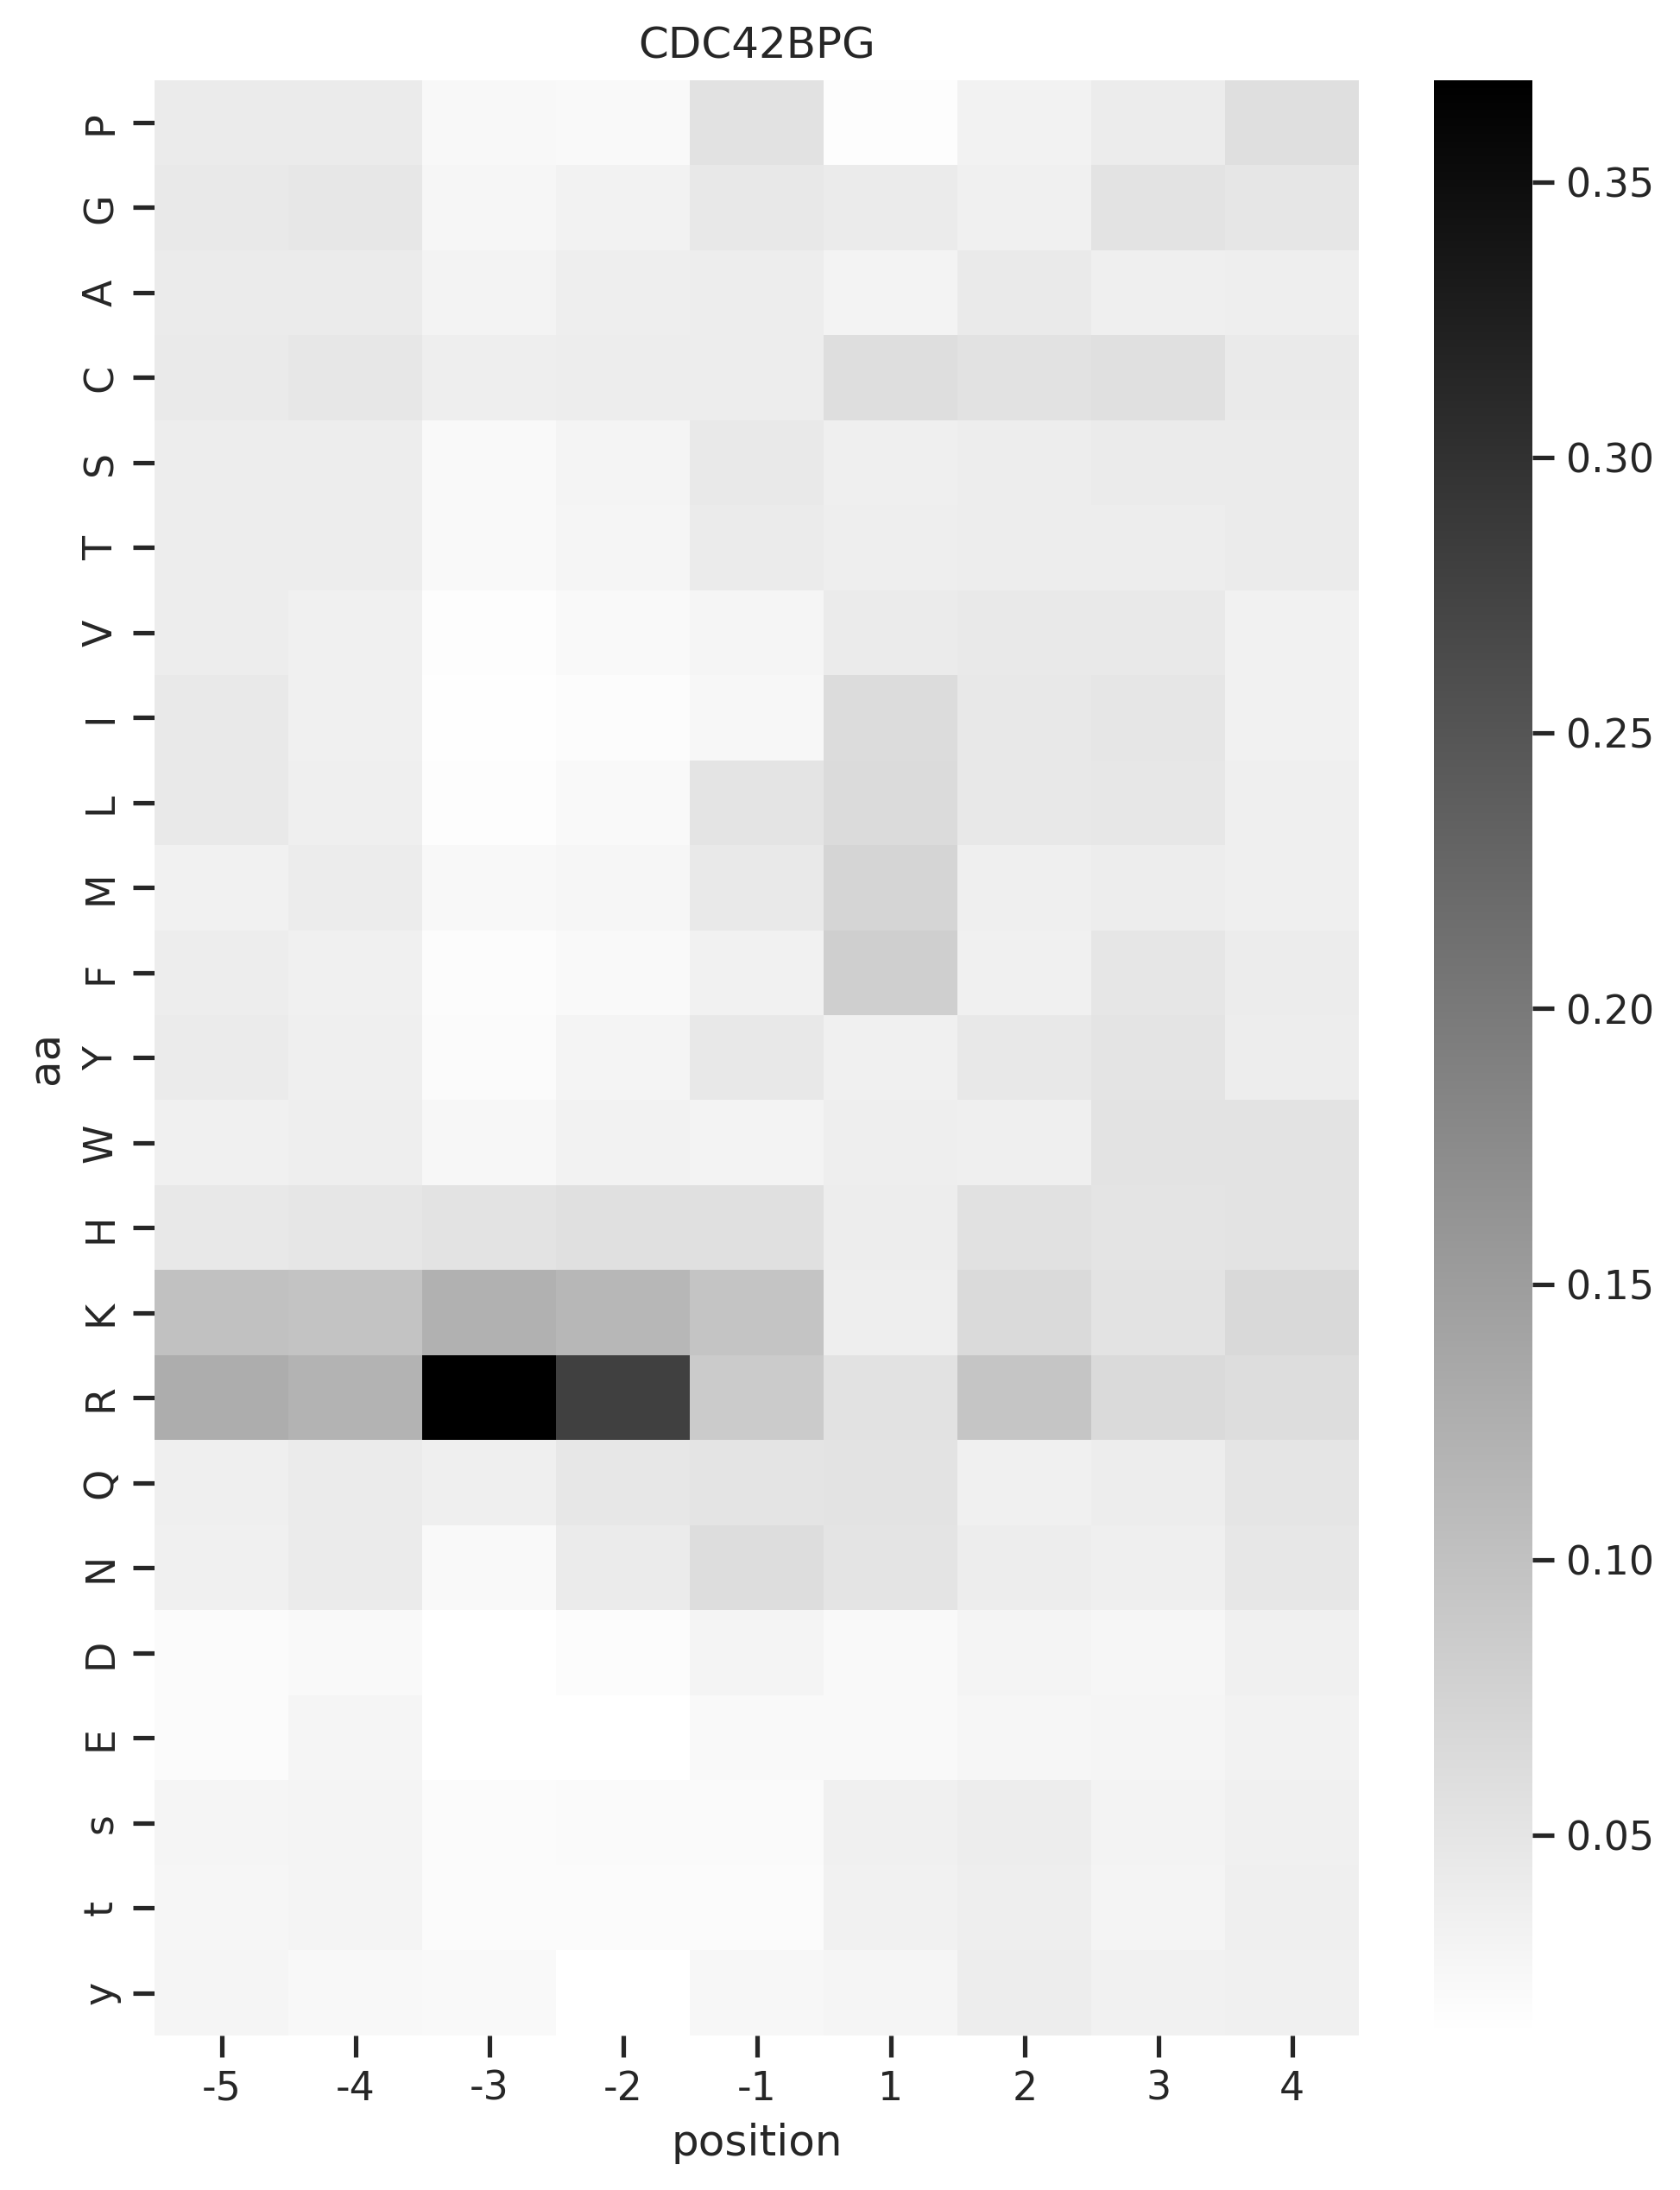

DAPK:0.7920828111362217


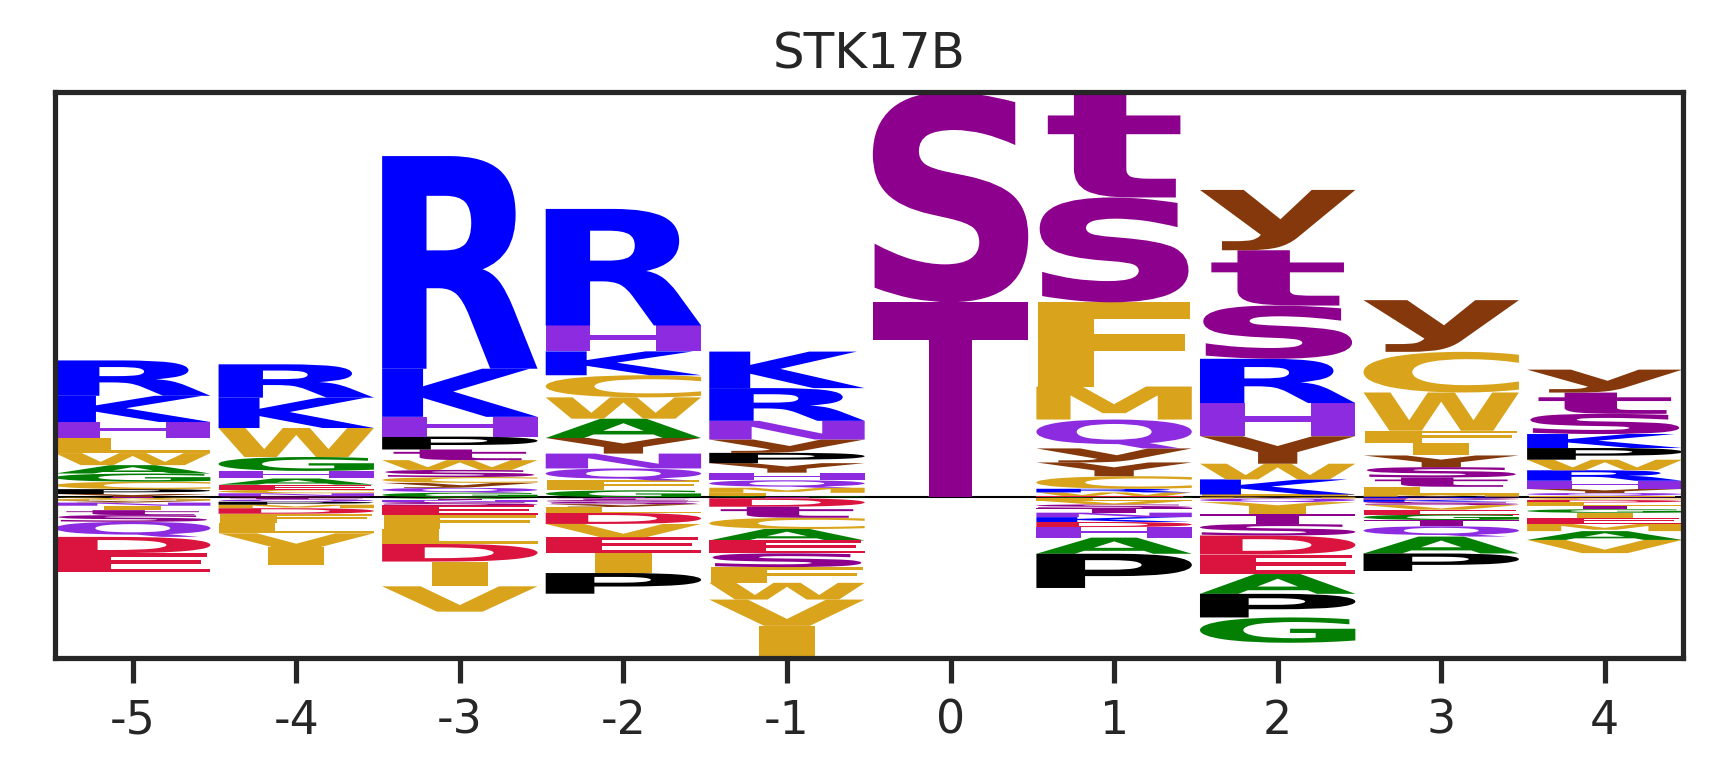

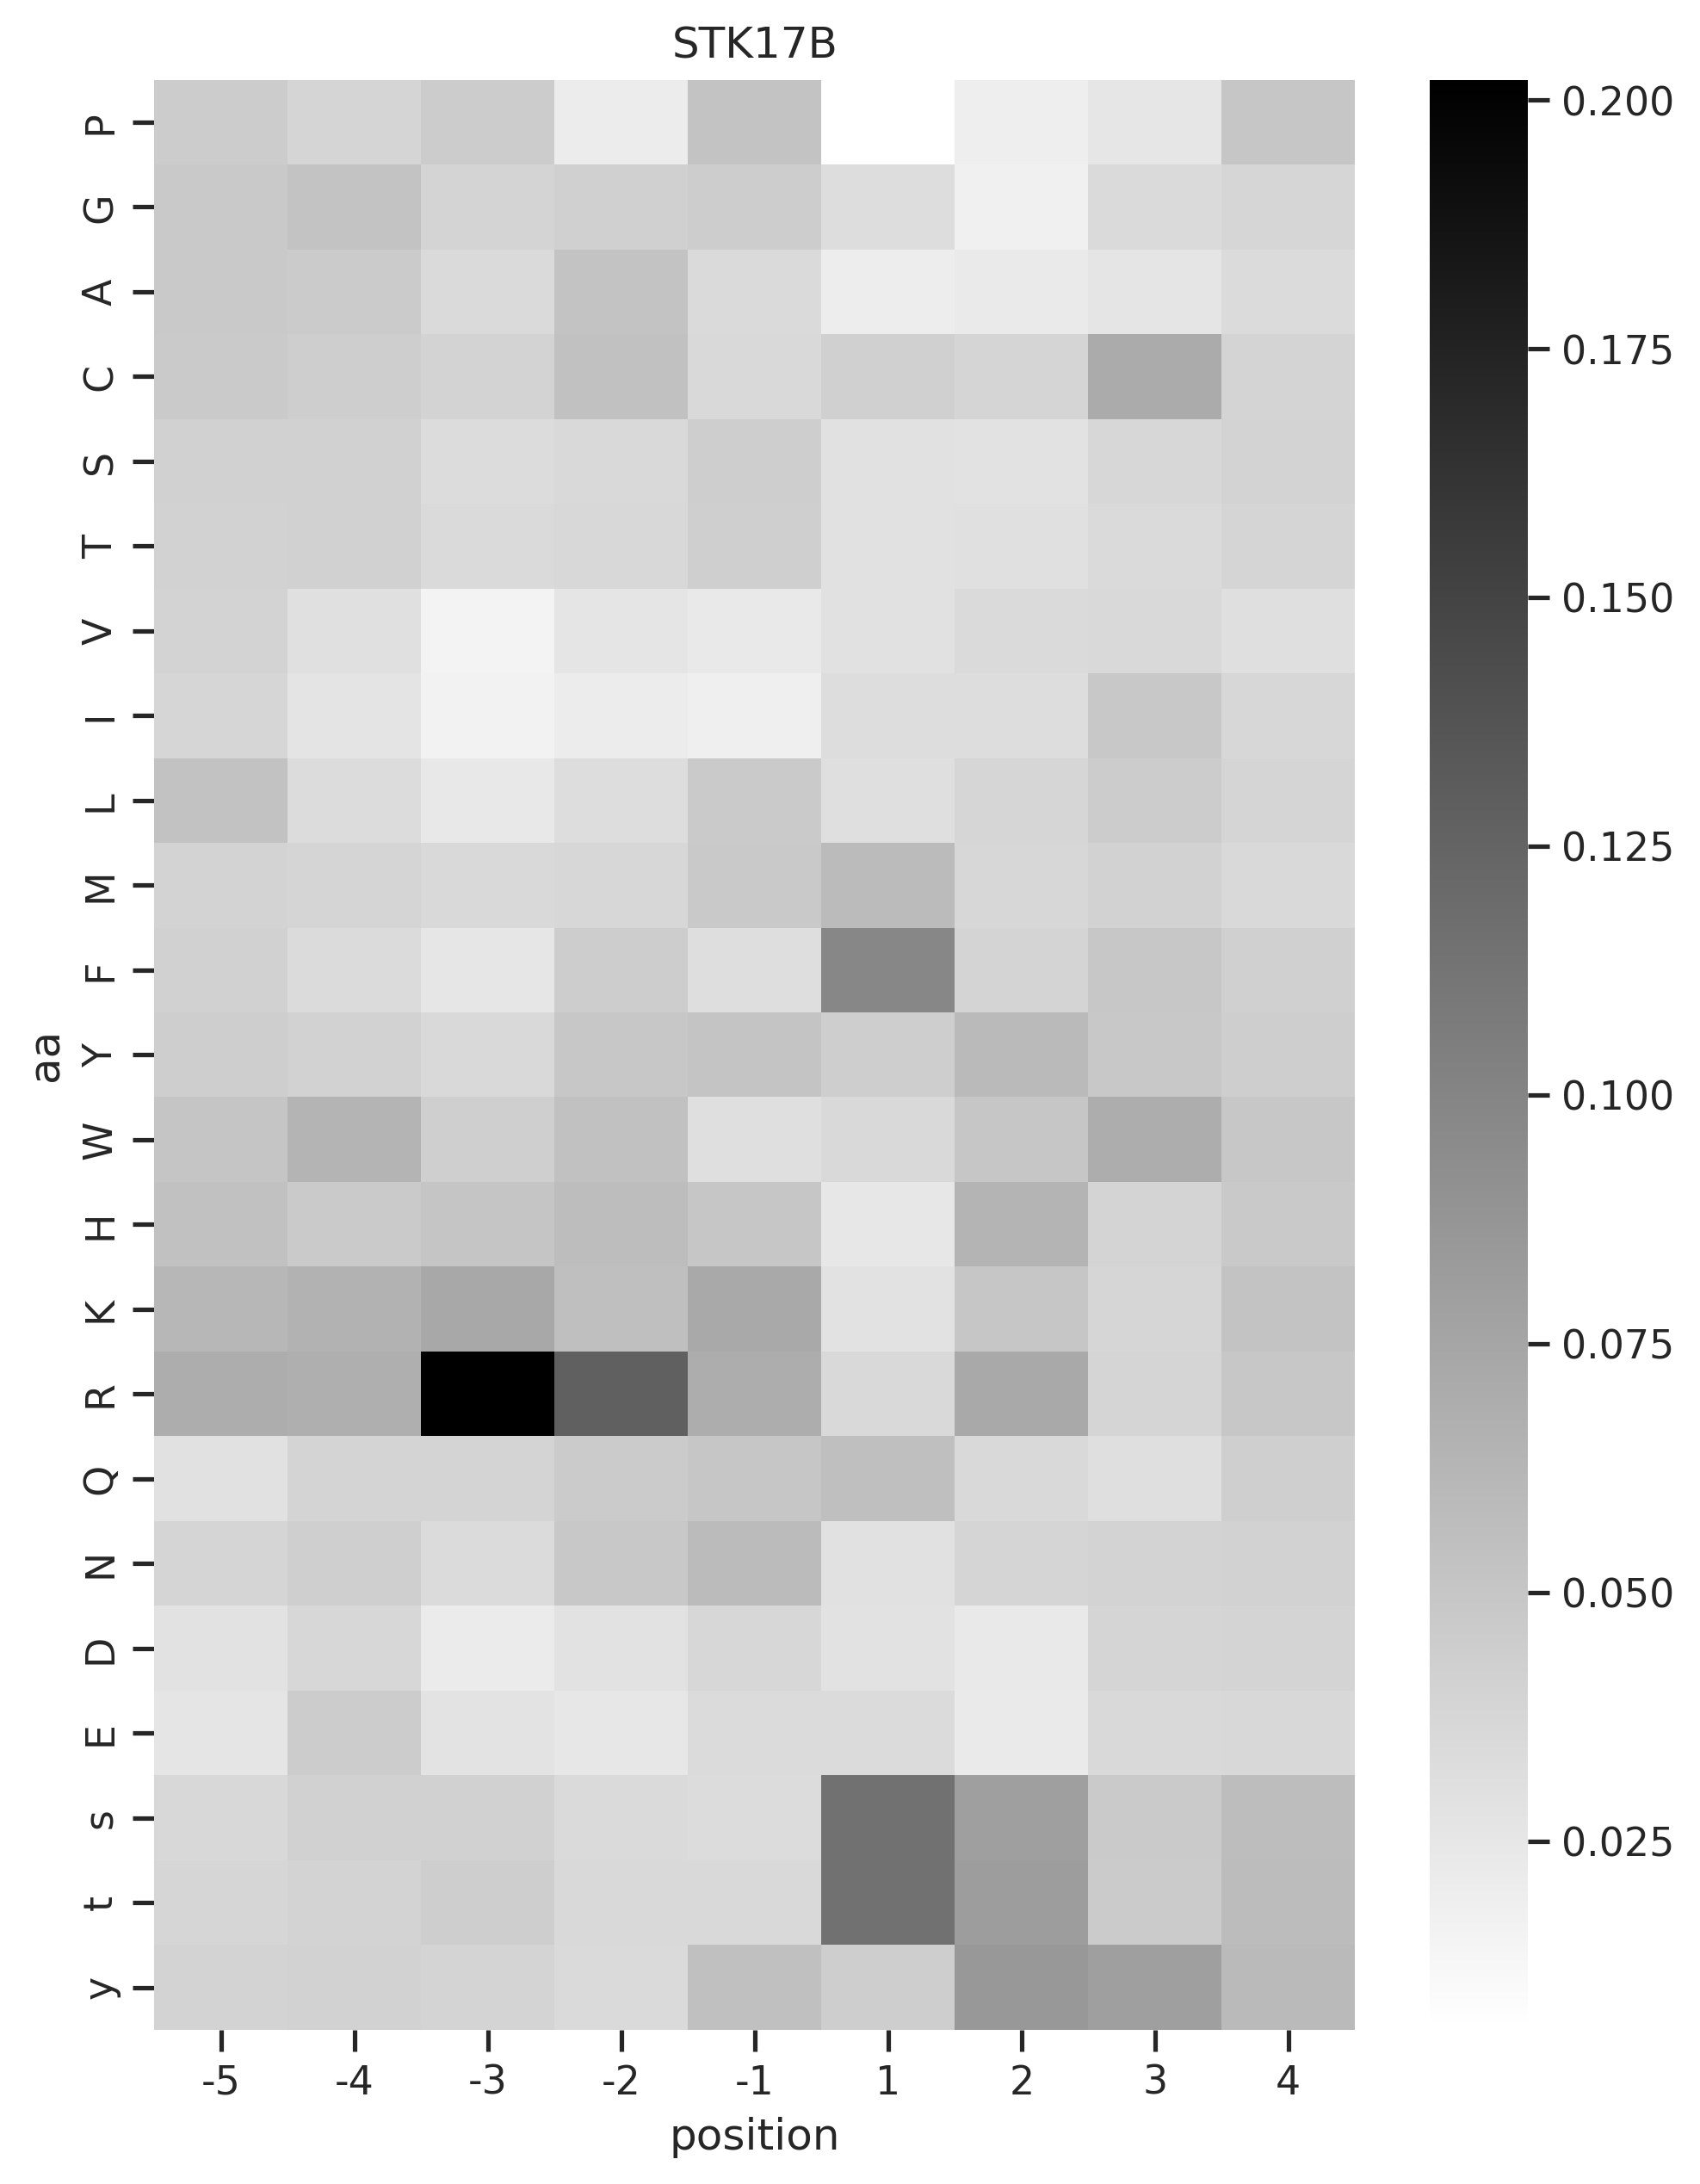

MAPK:0.8818759660317733


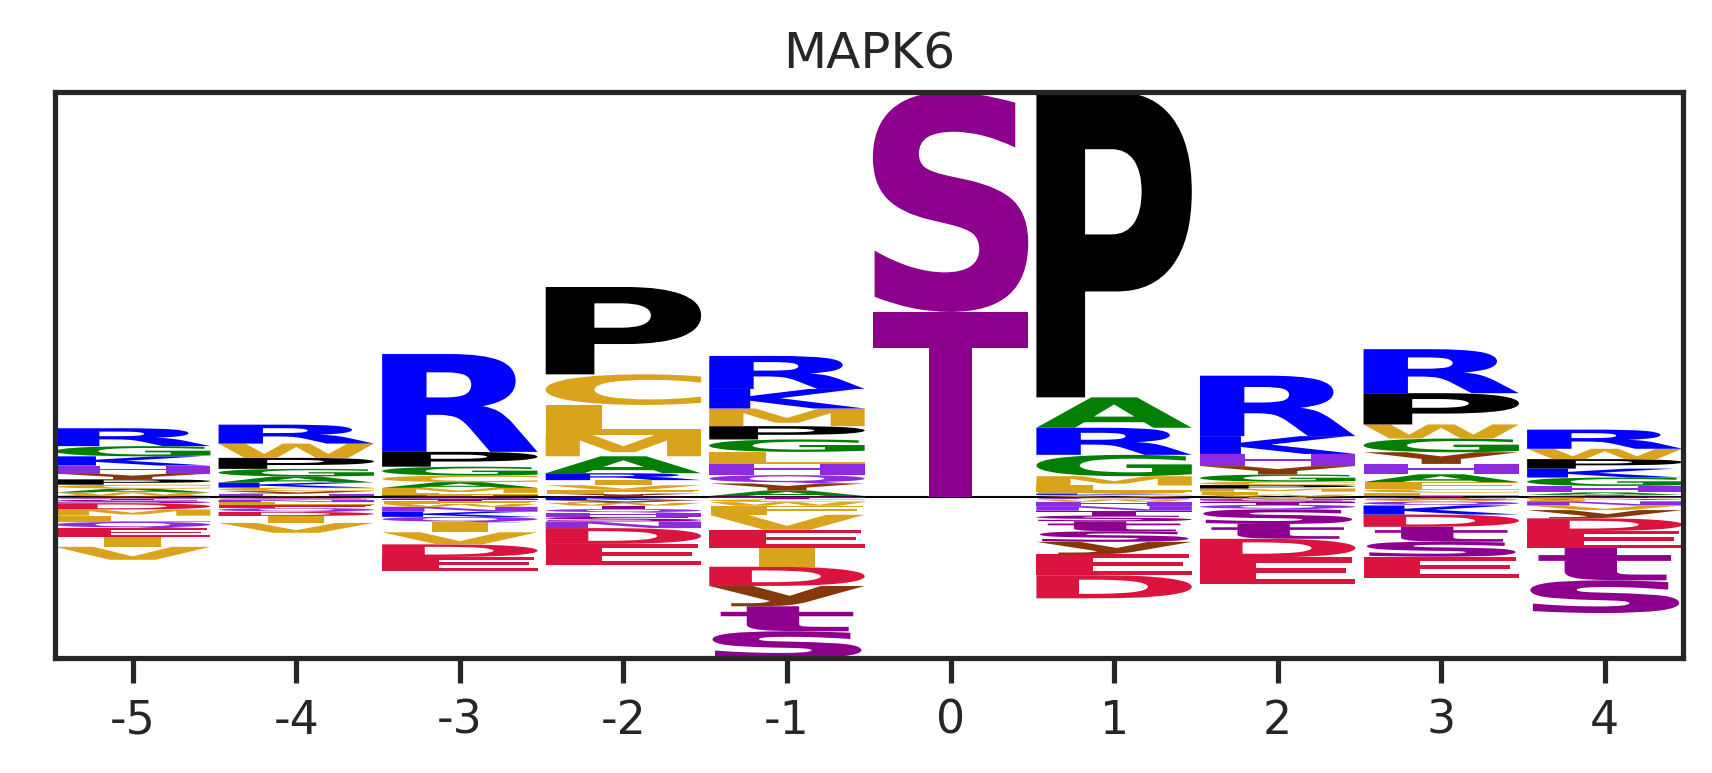

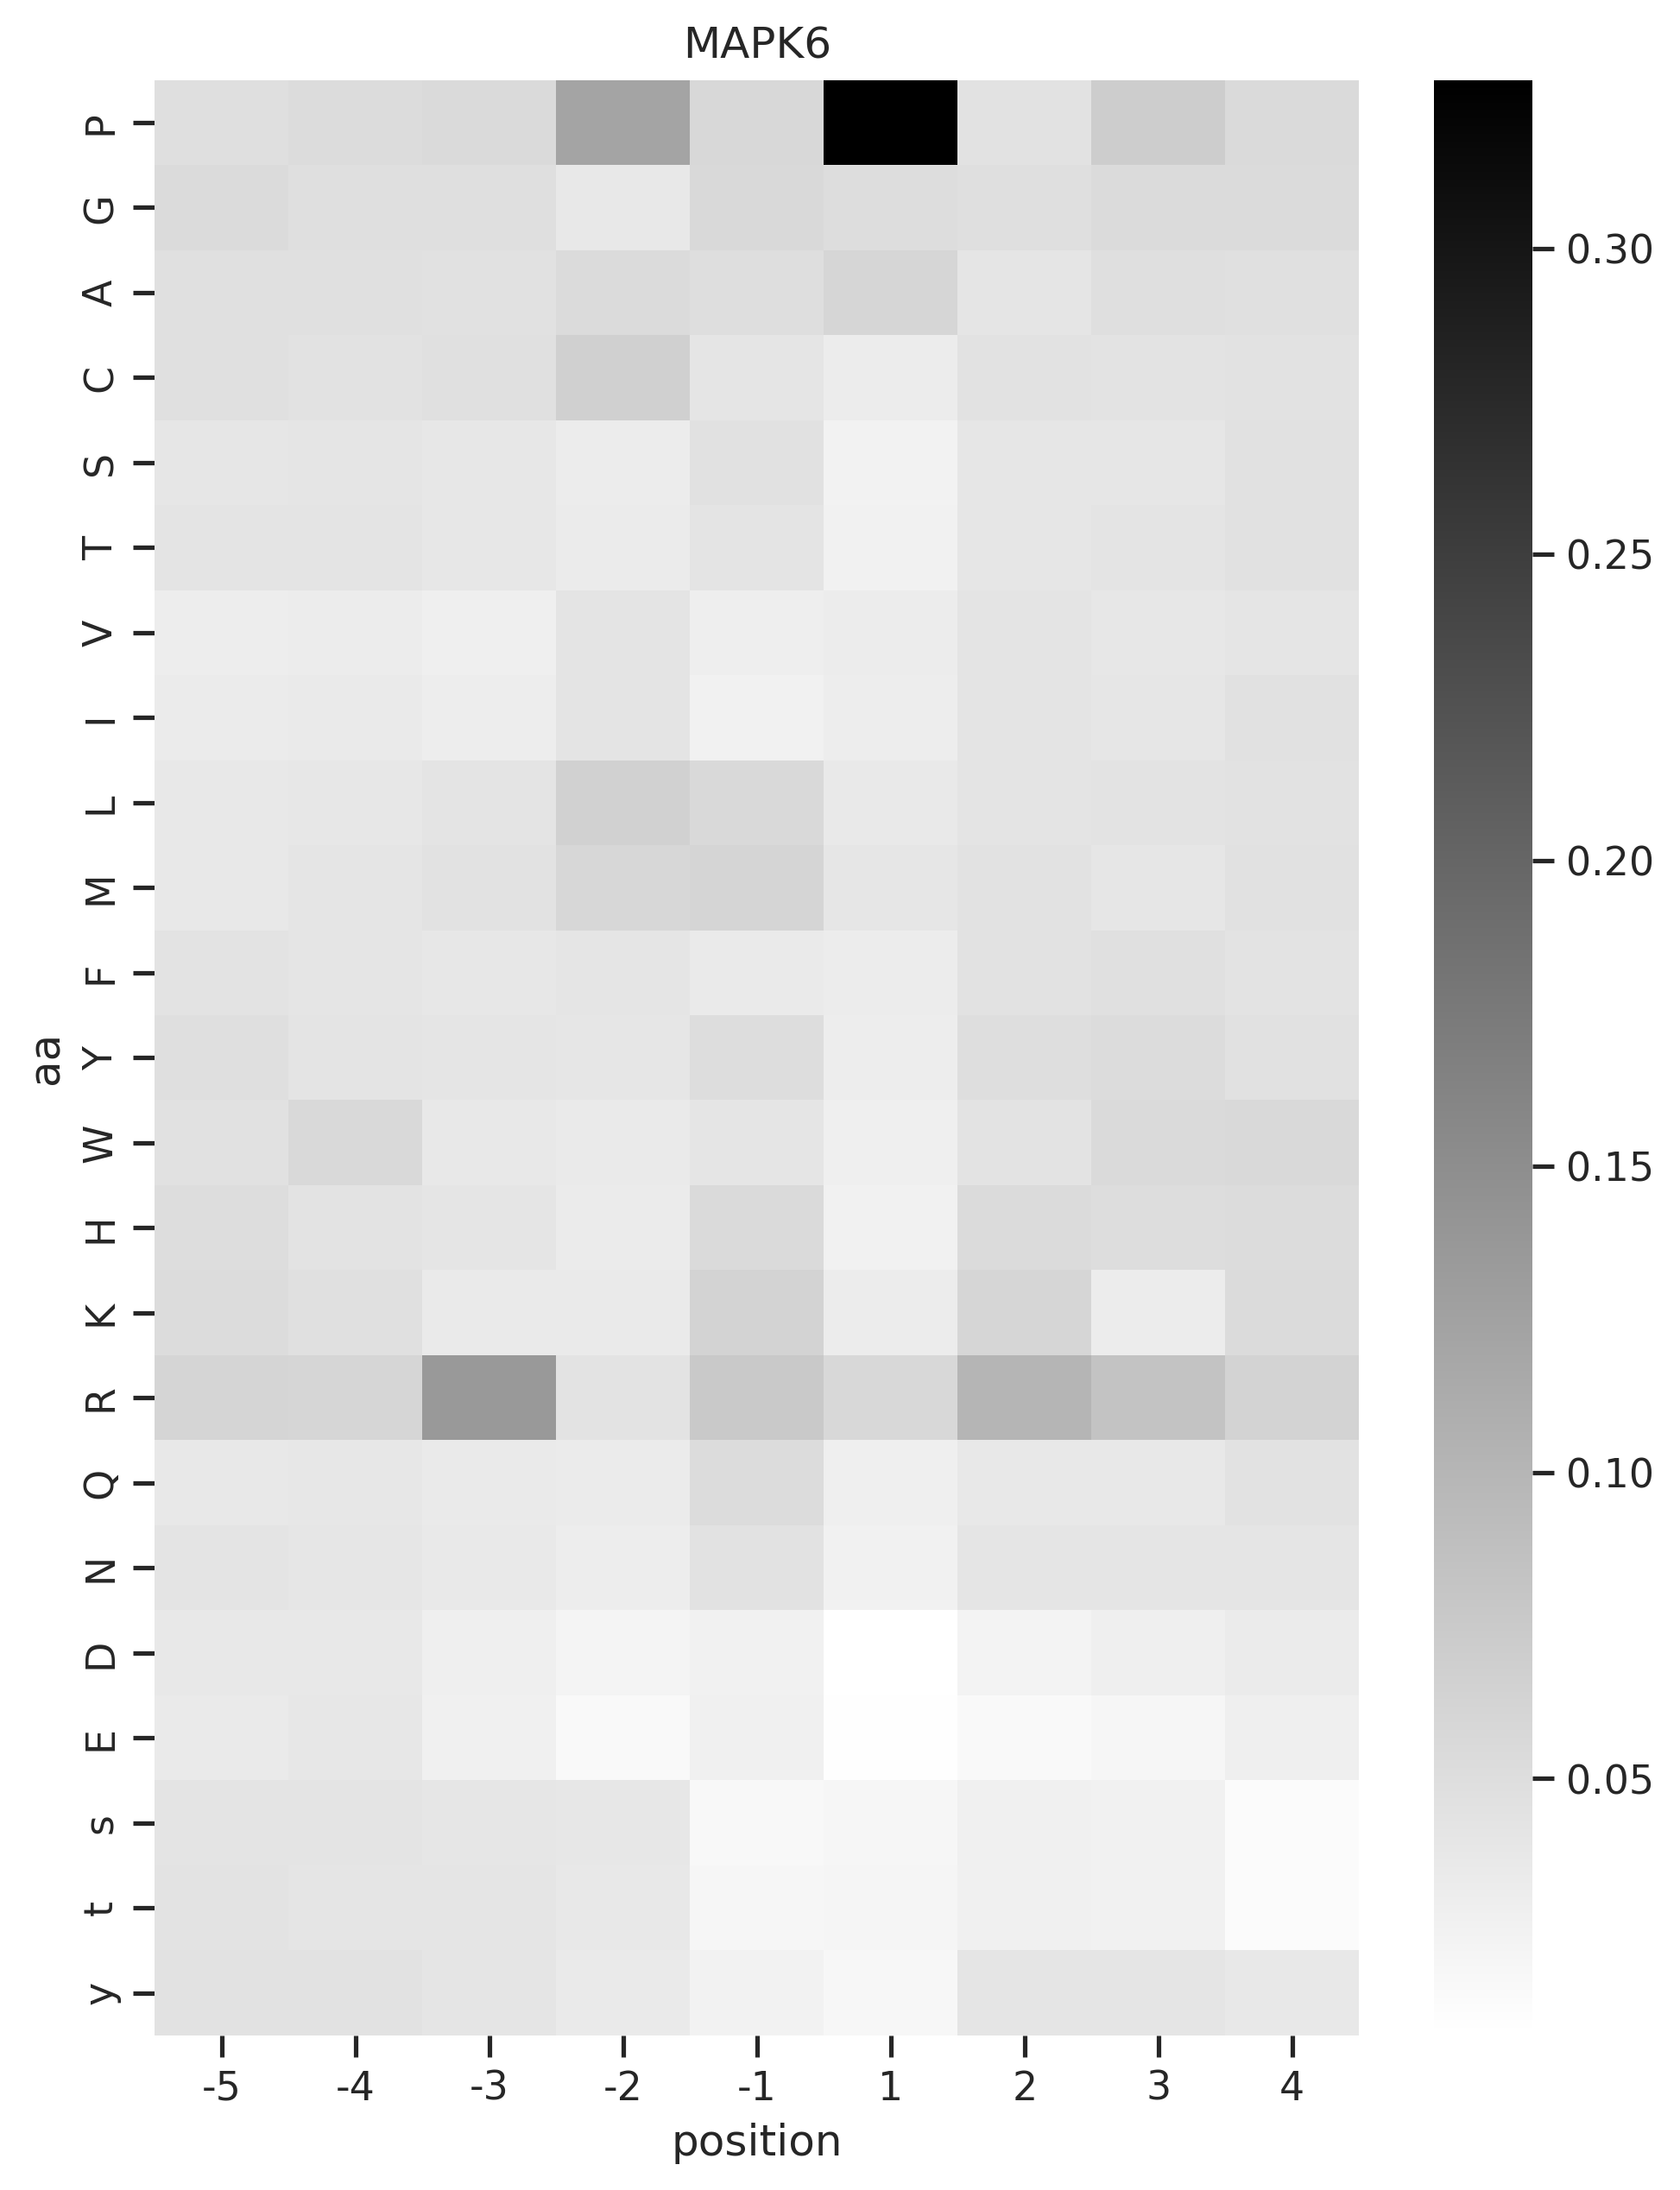

MAPK:0.8818759660317733


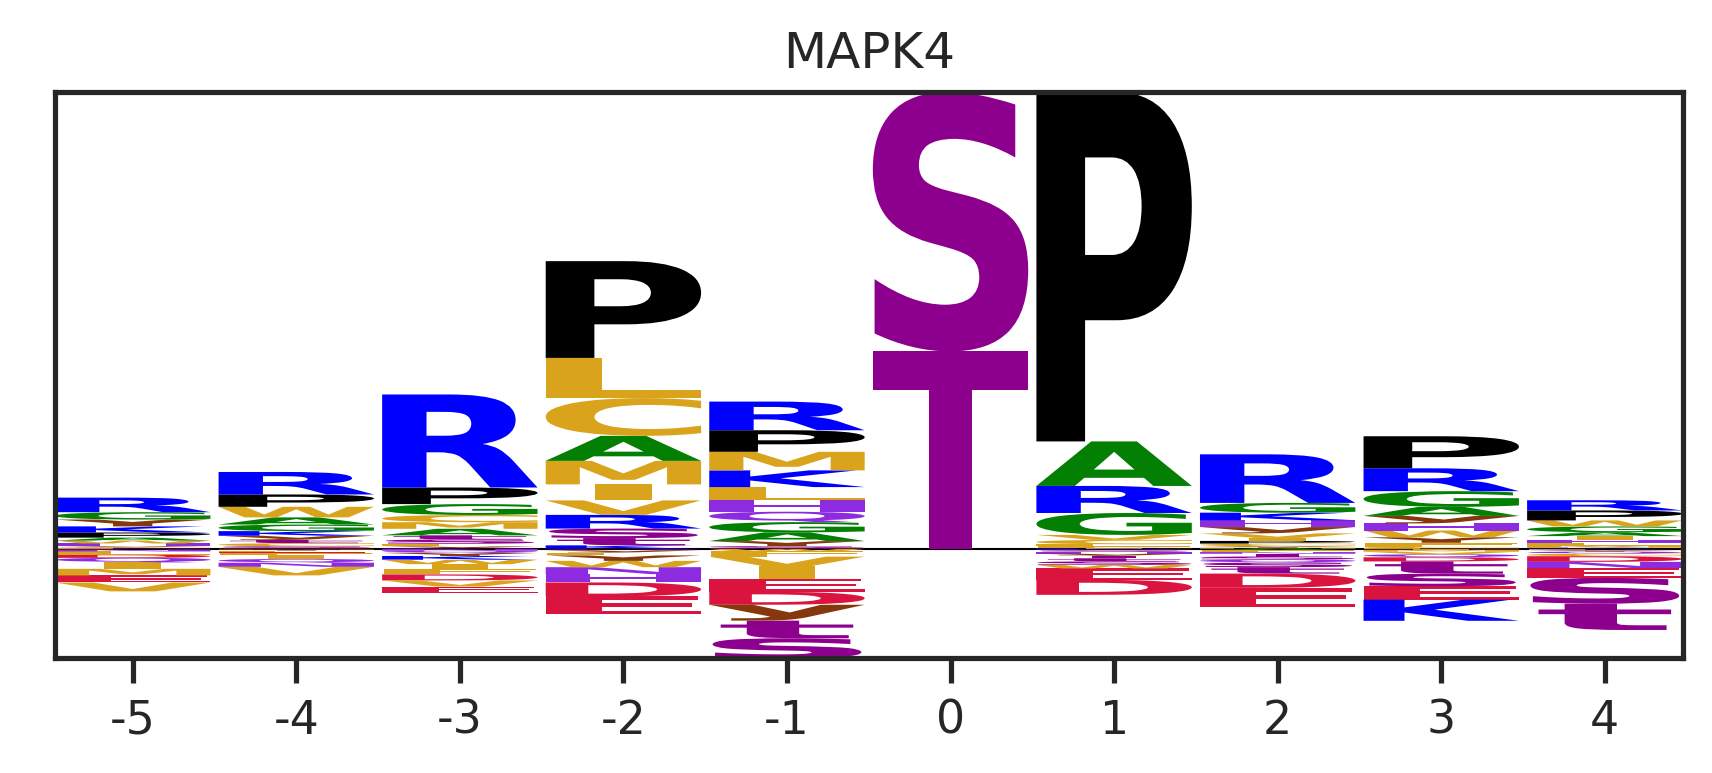

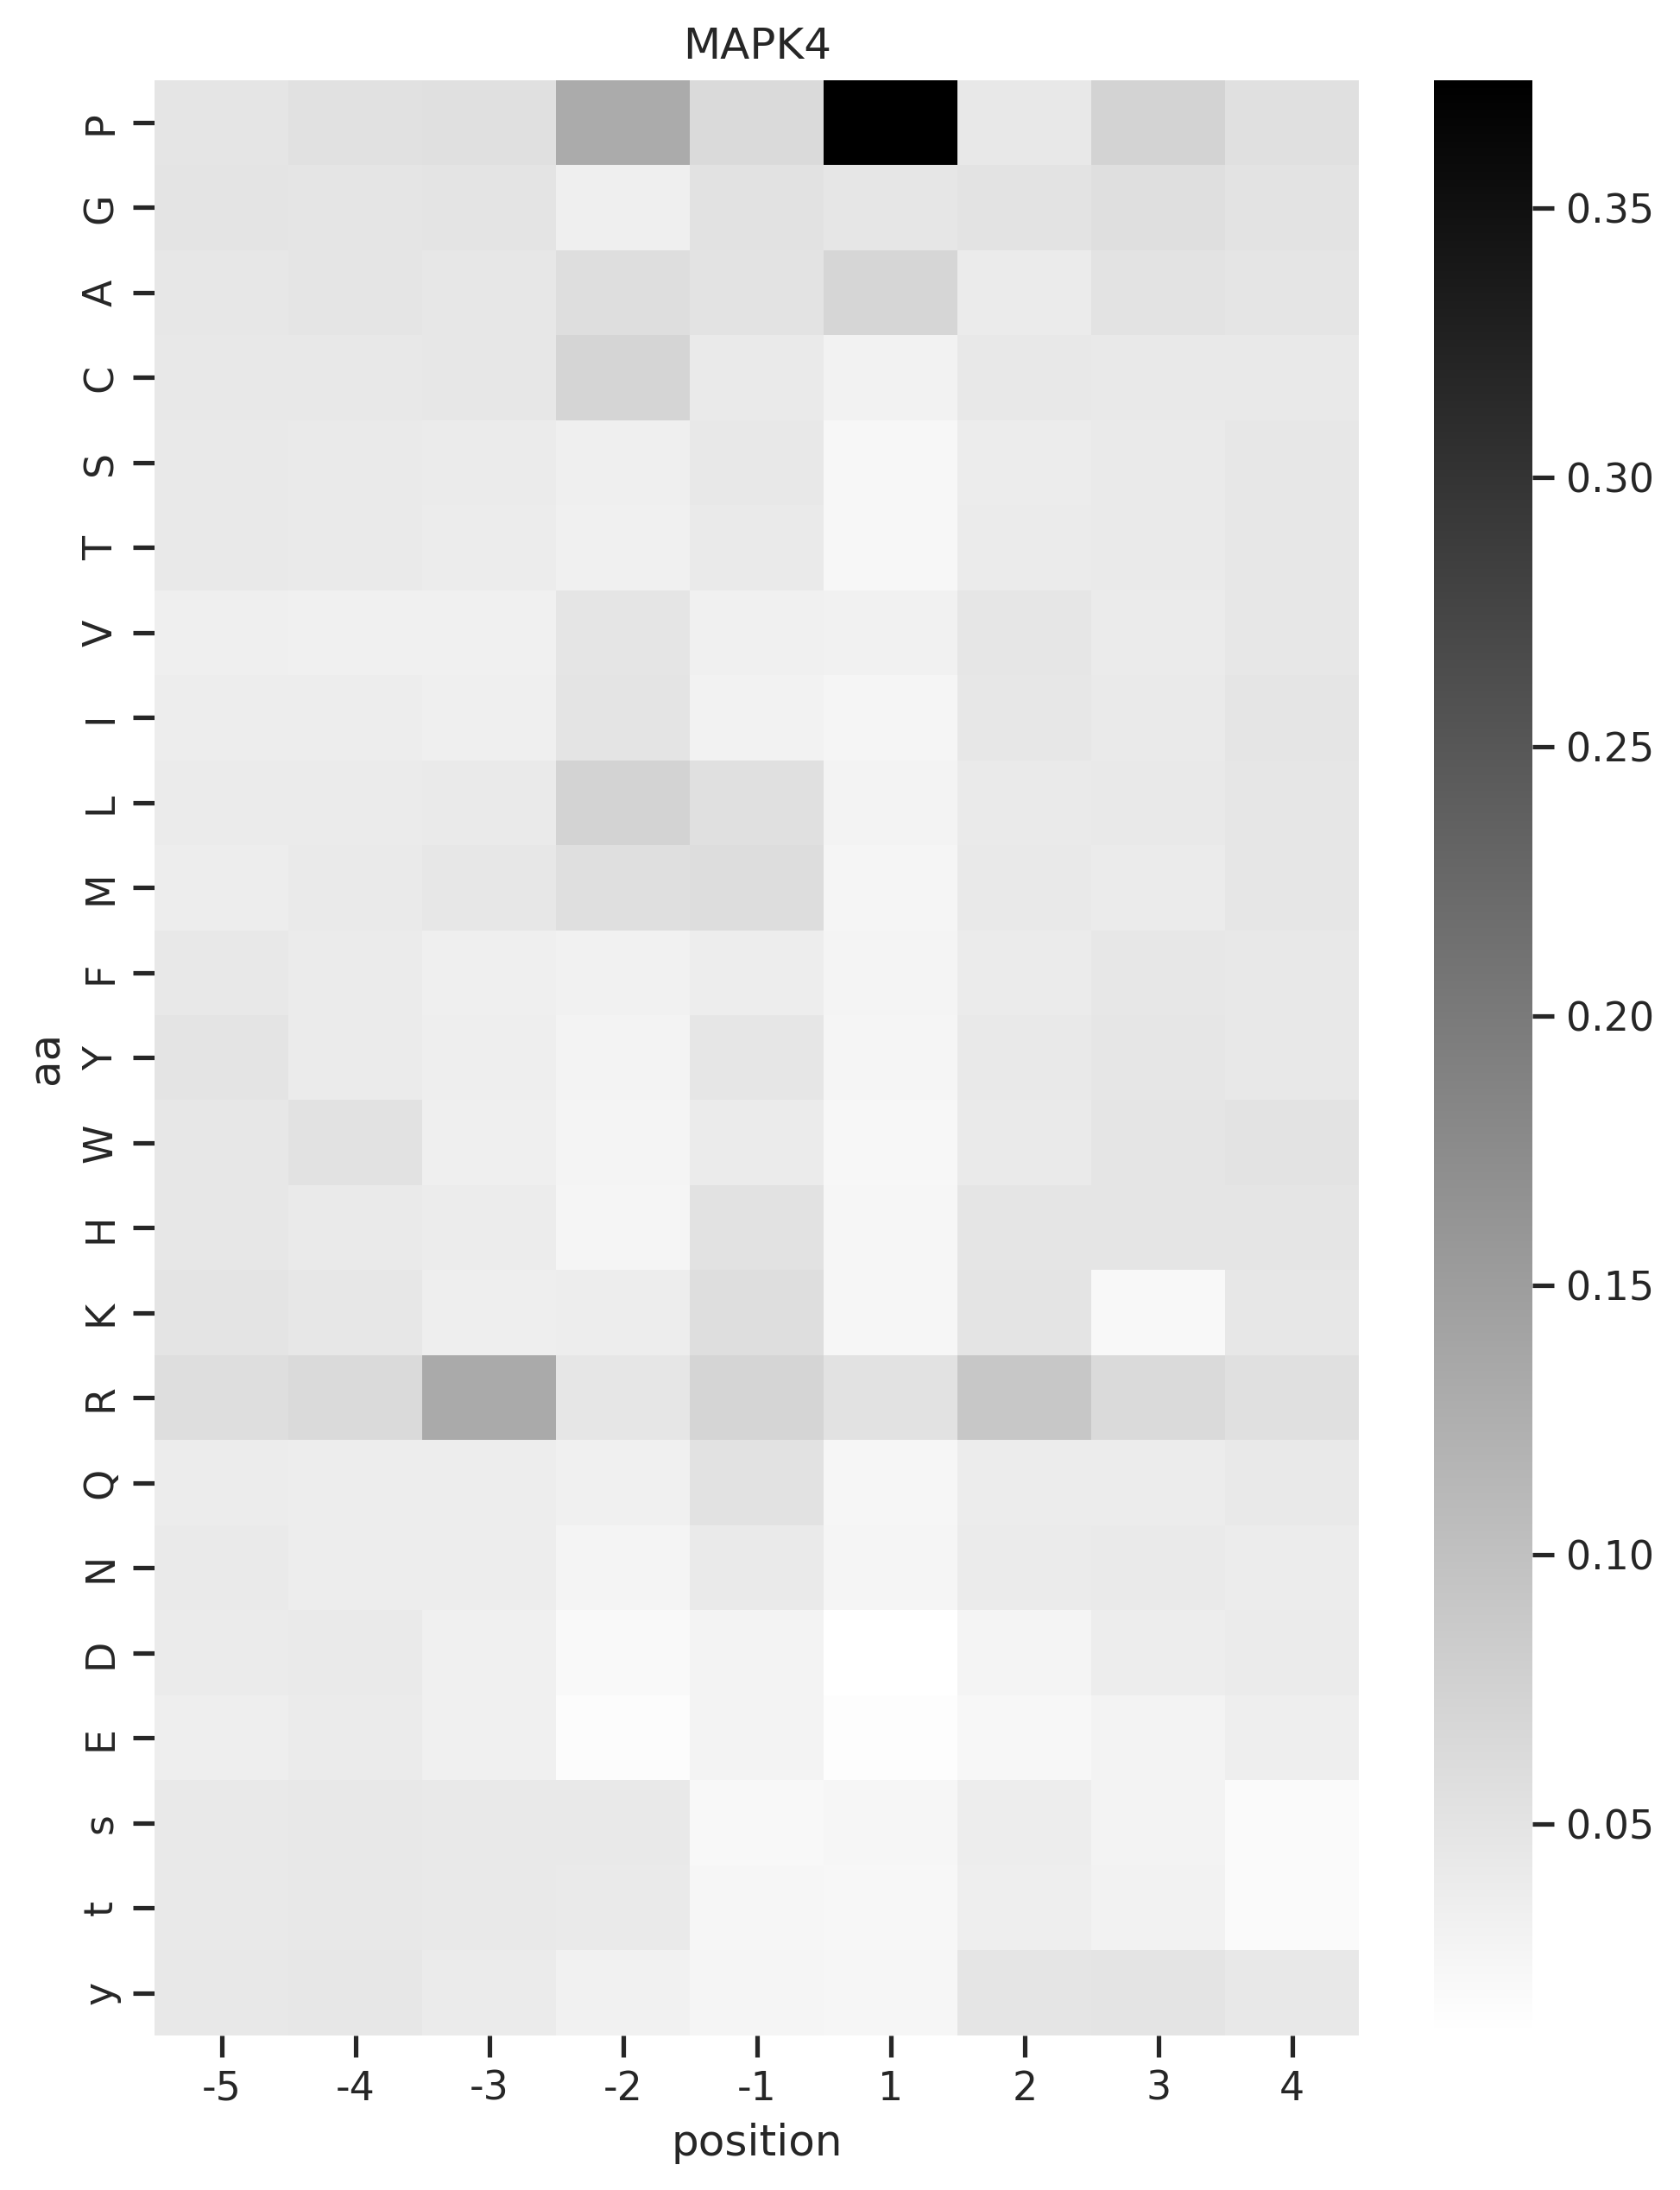

MLK:0.7337835153843144


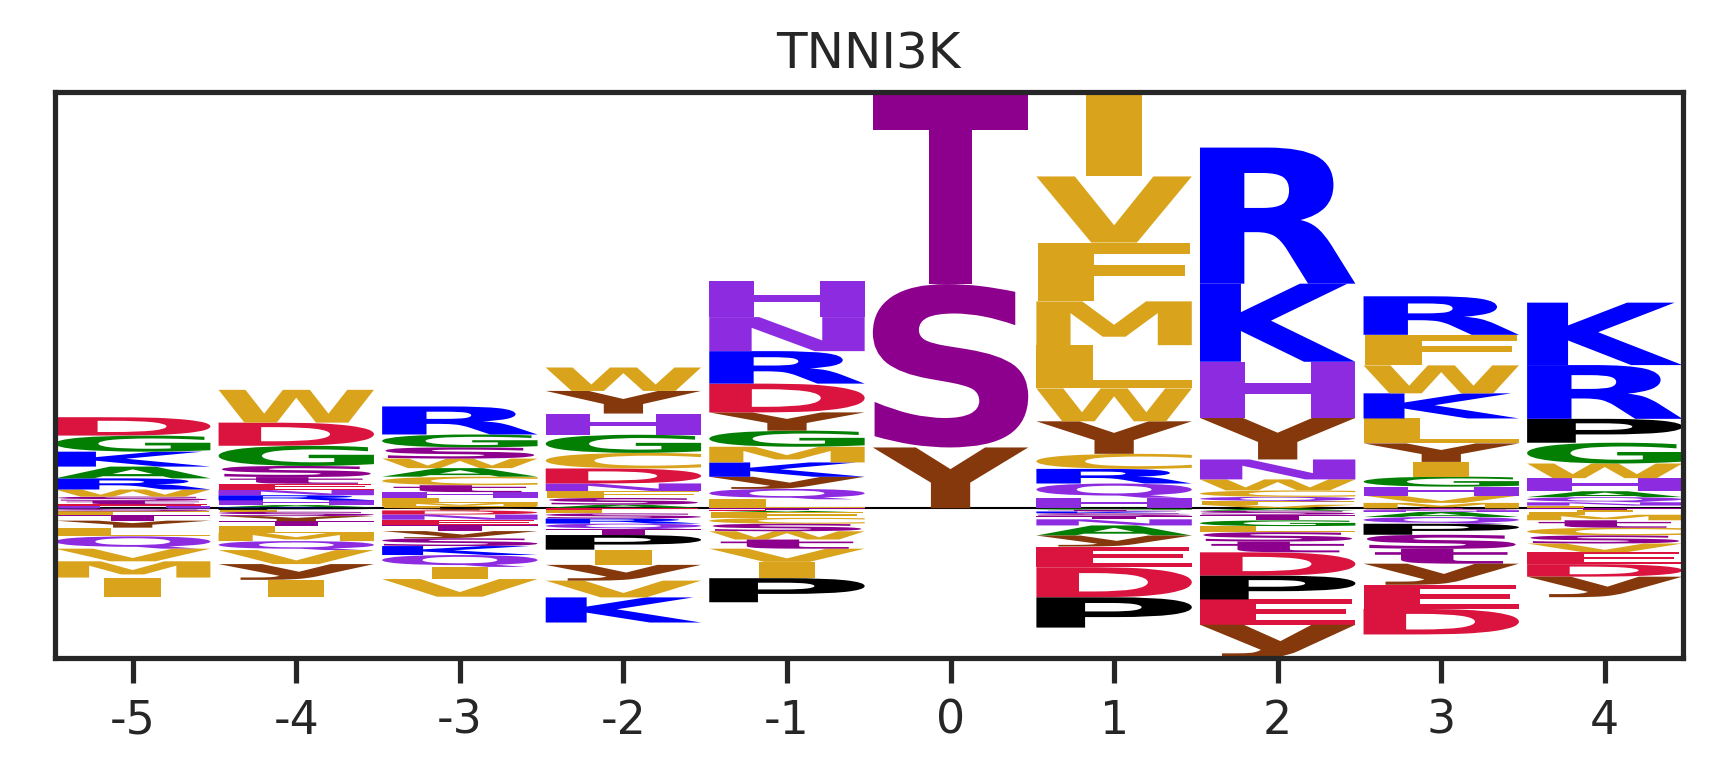

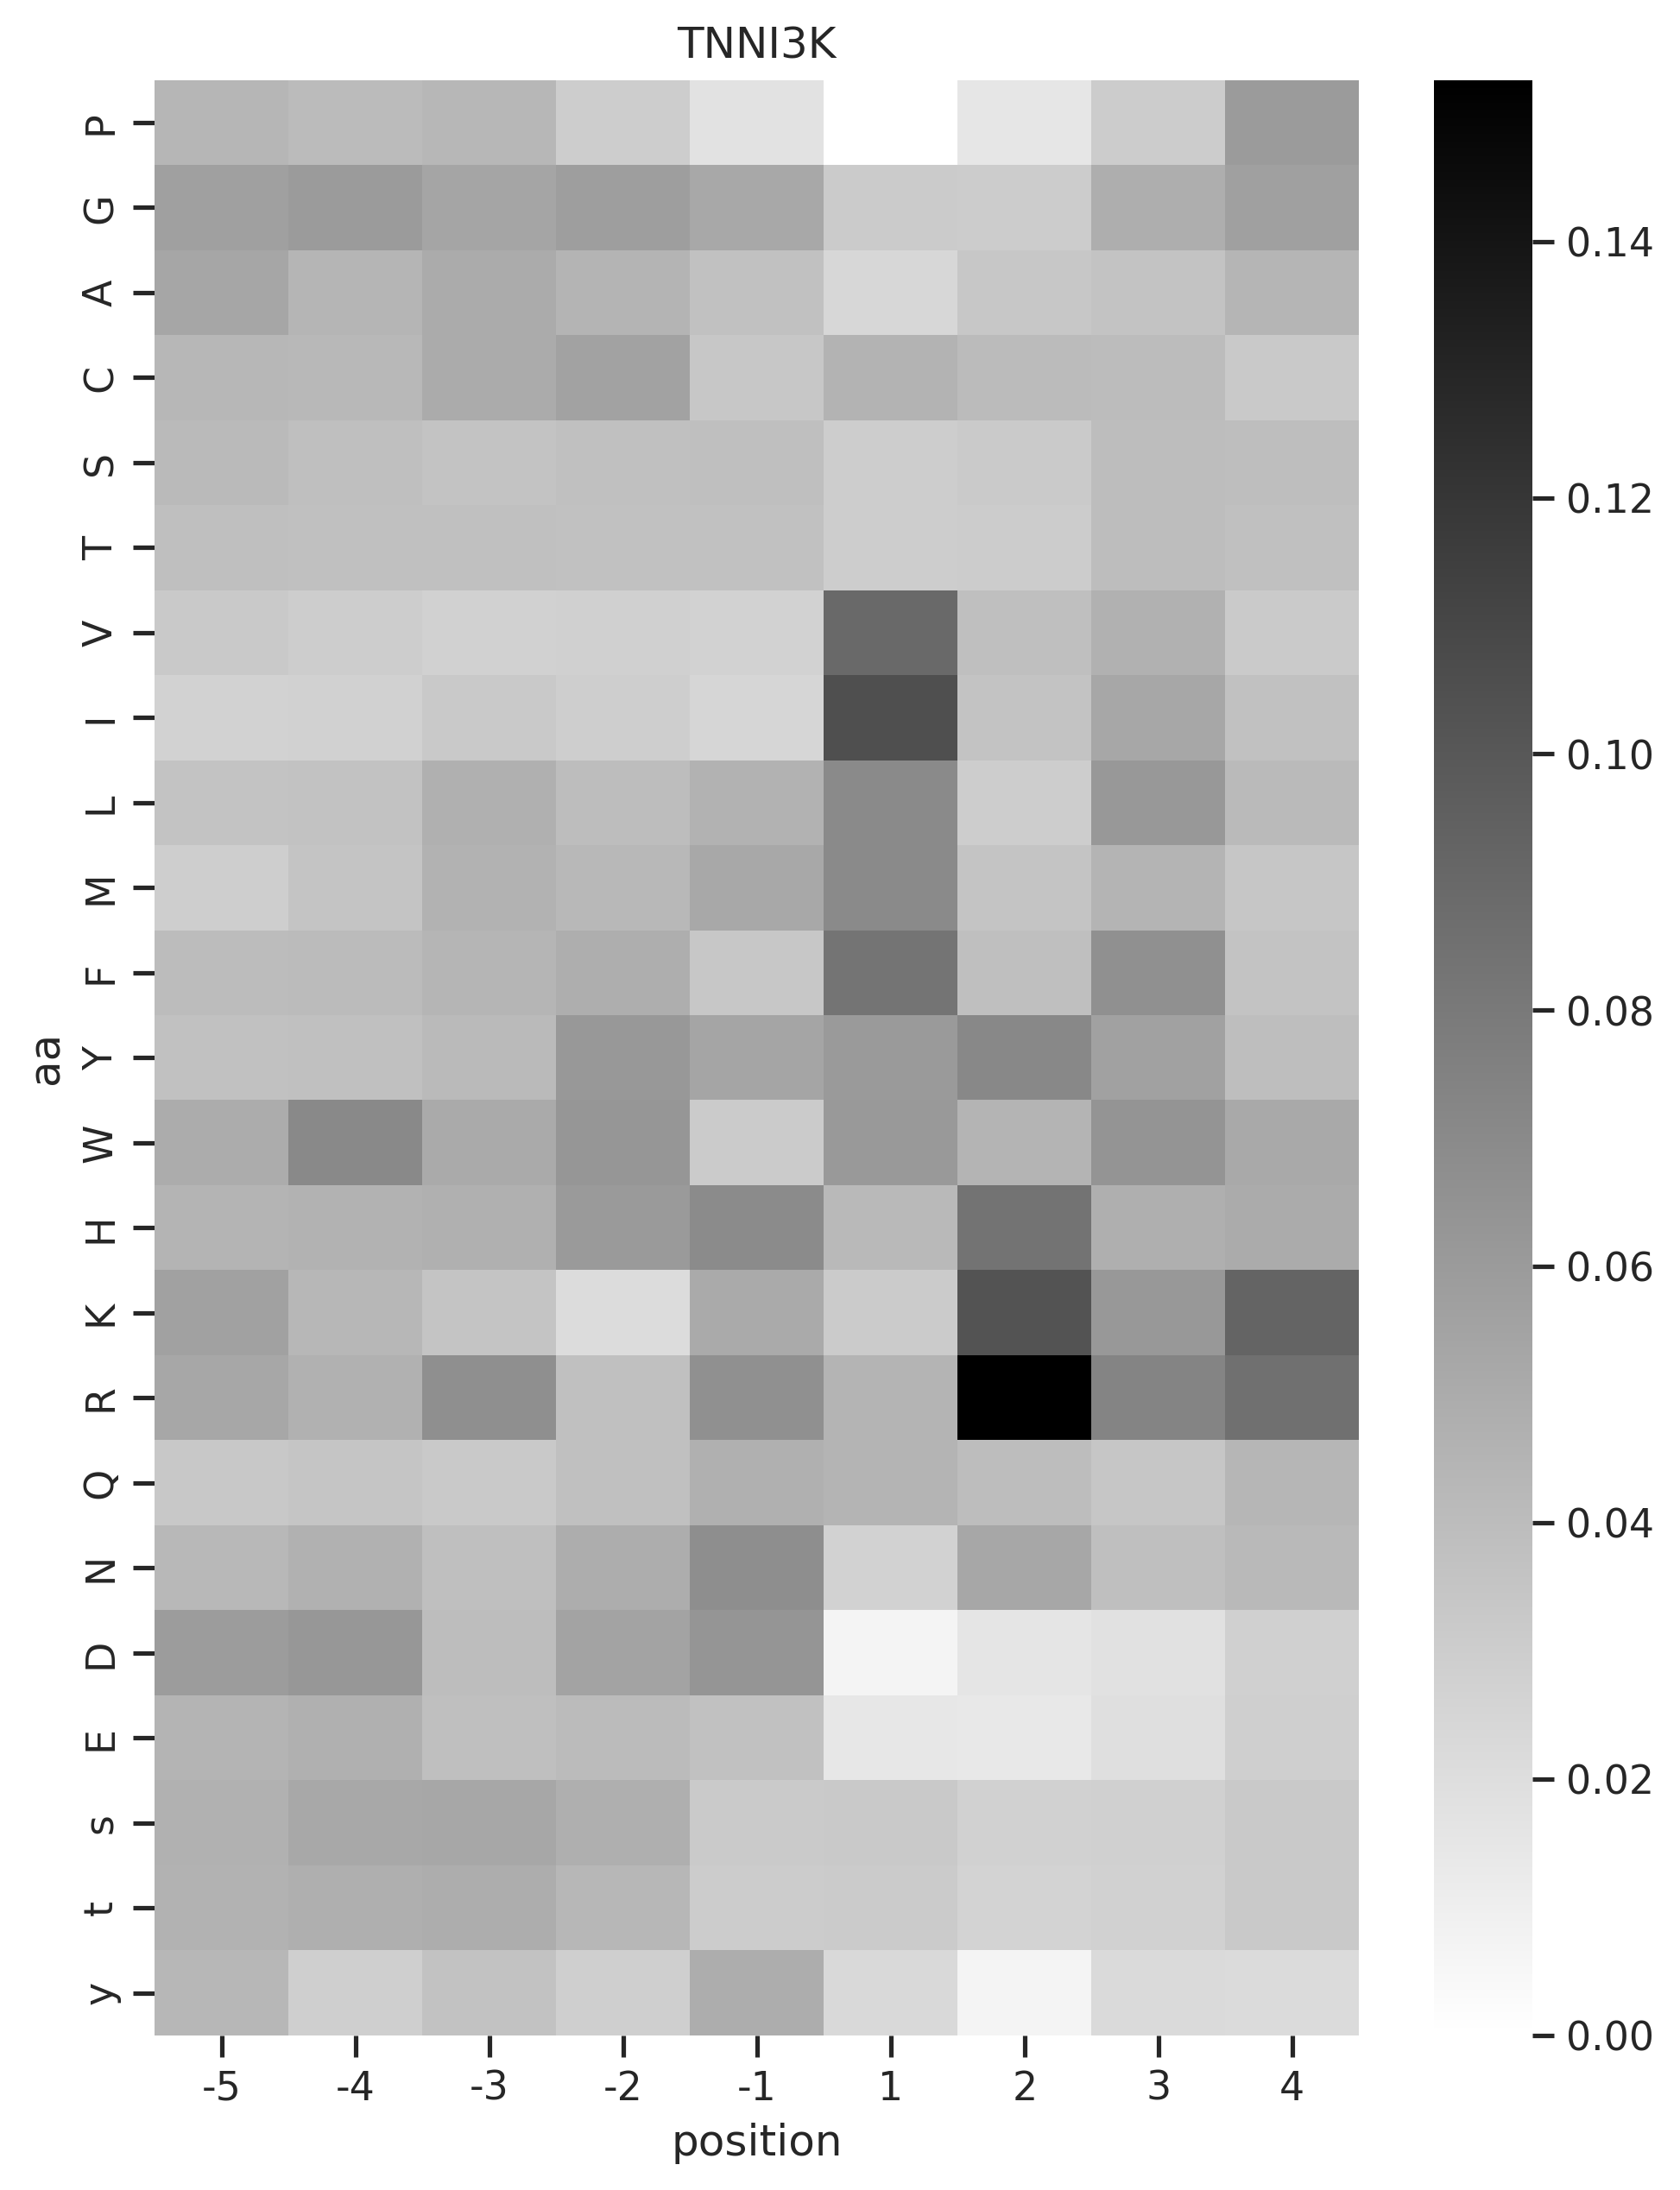

MLK:0.7337835153843144


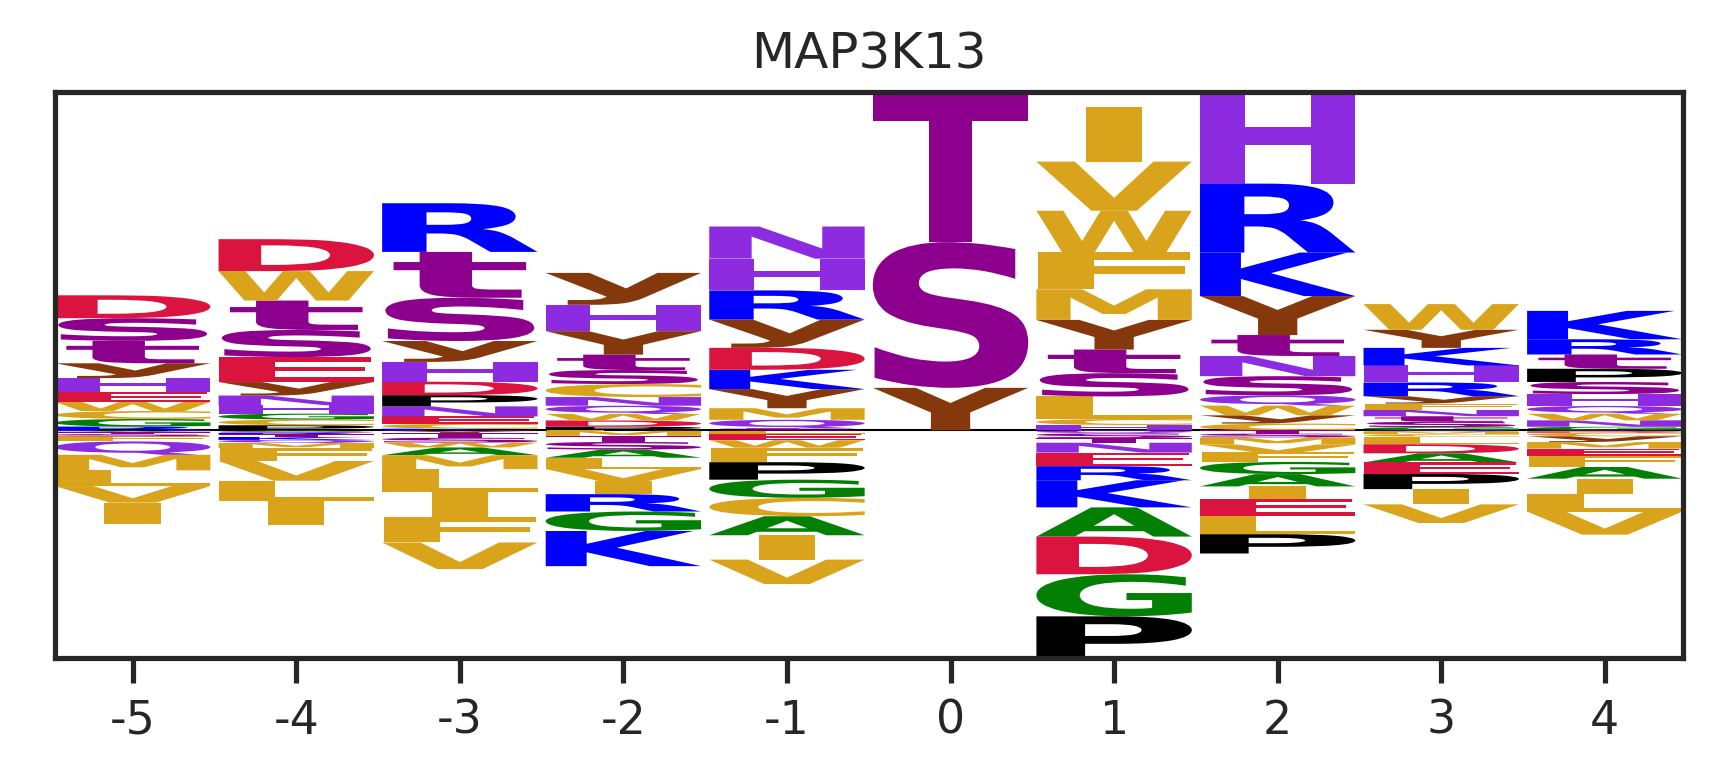

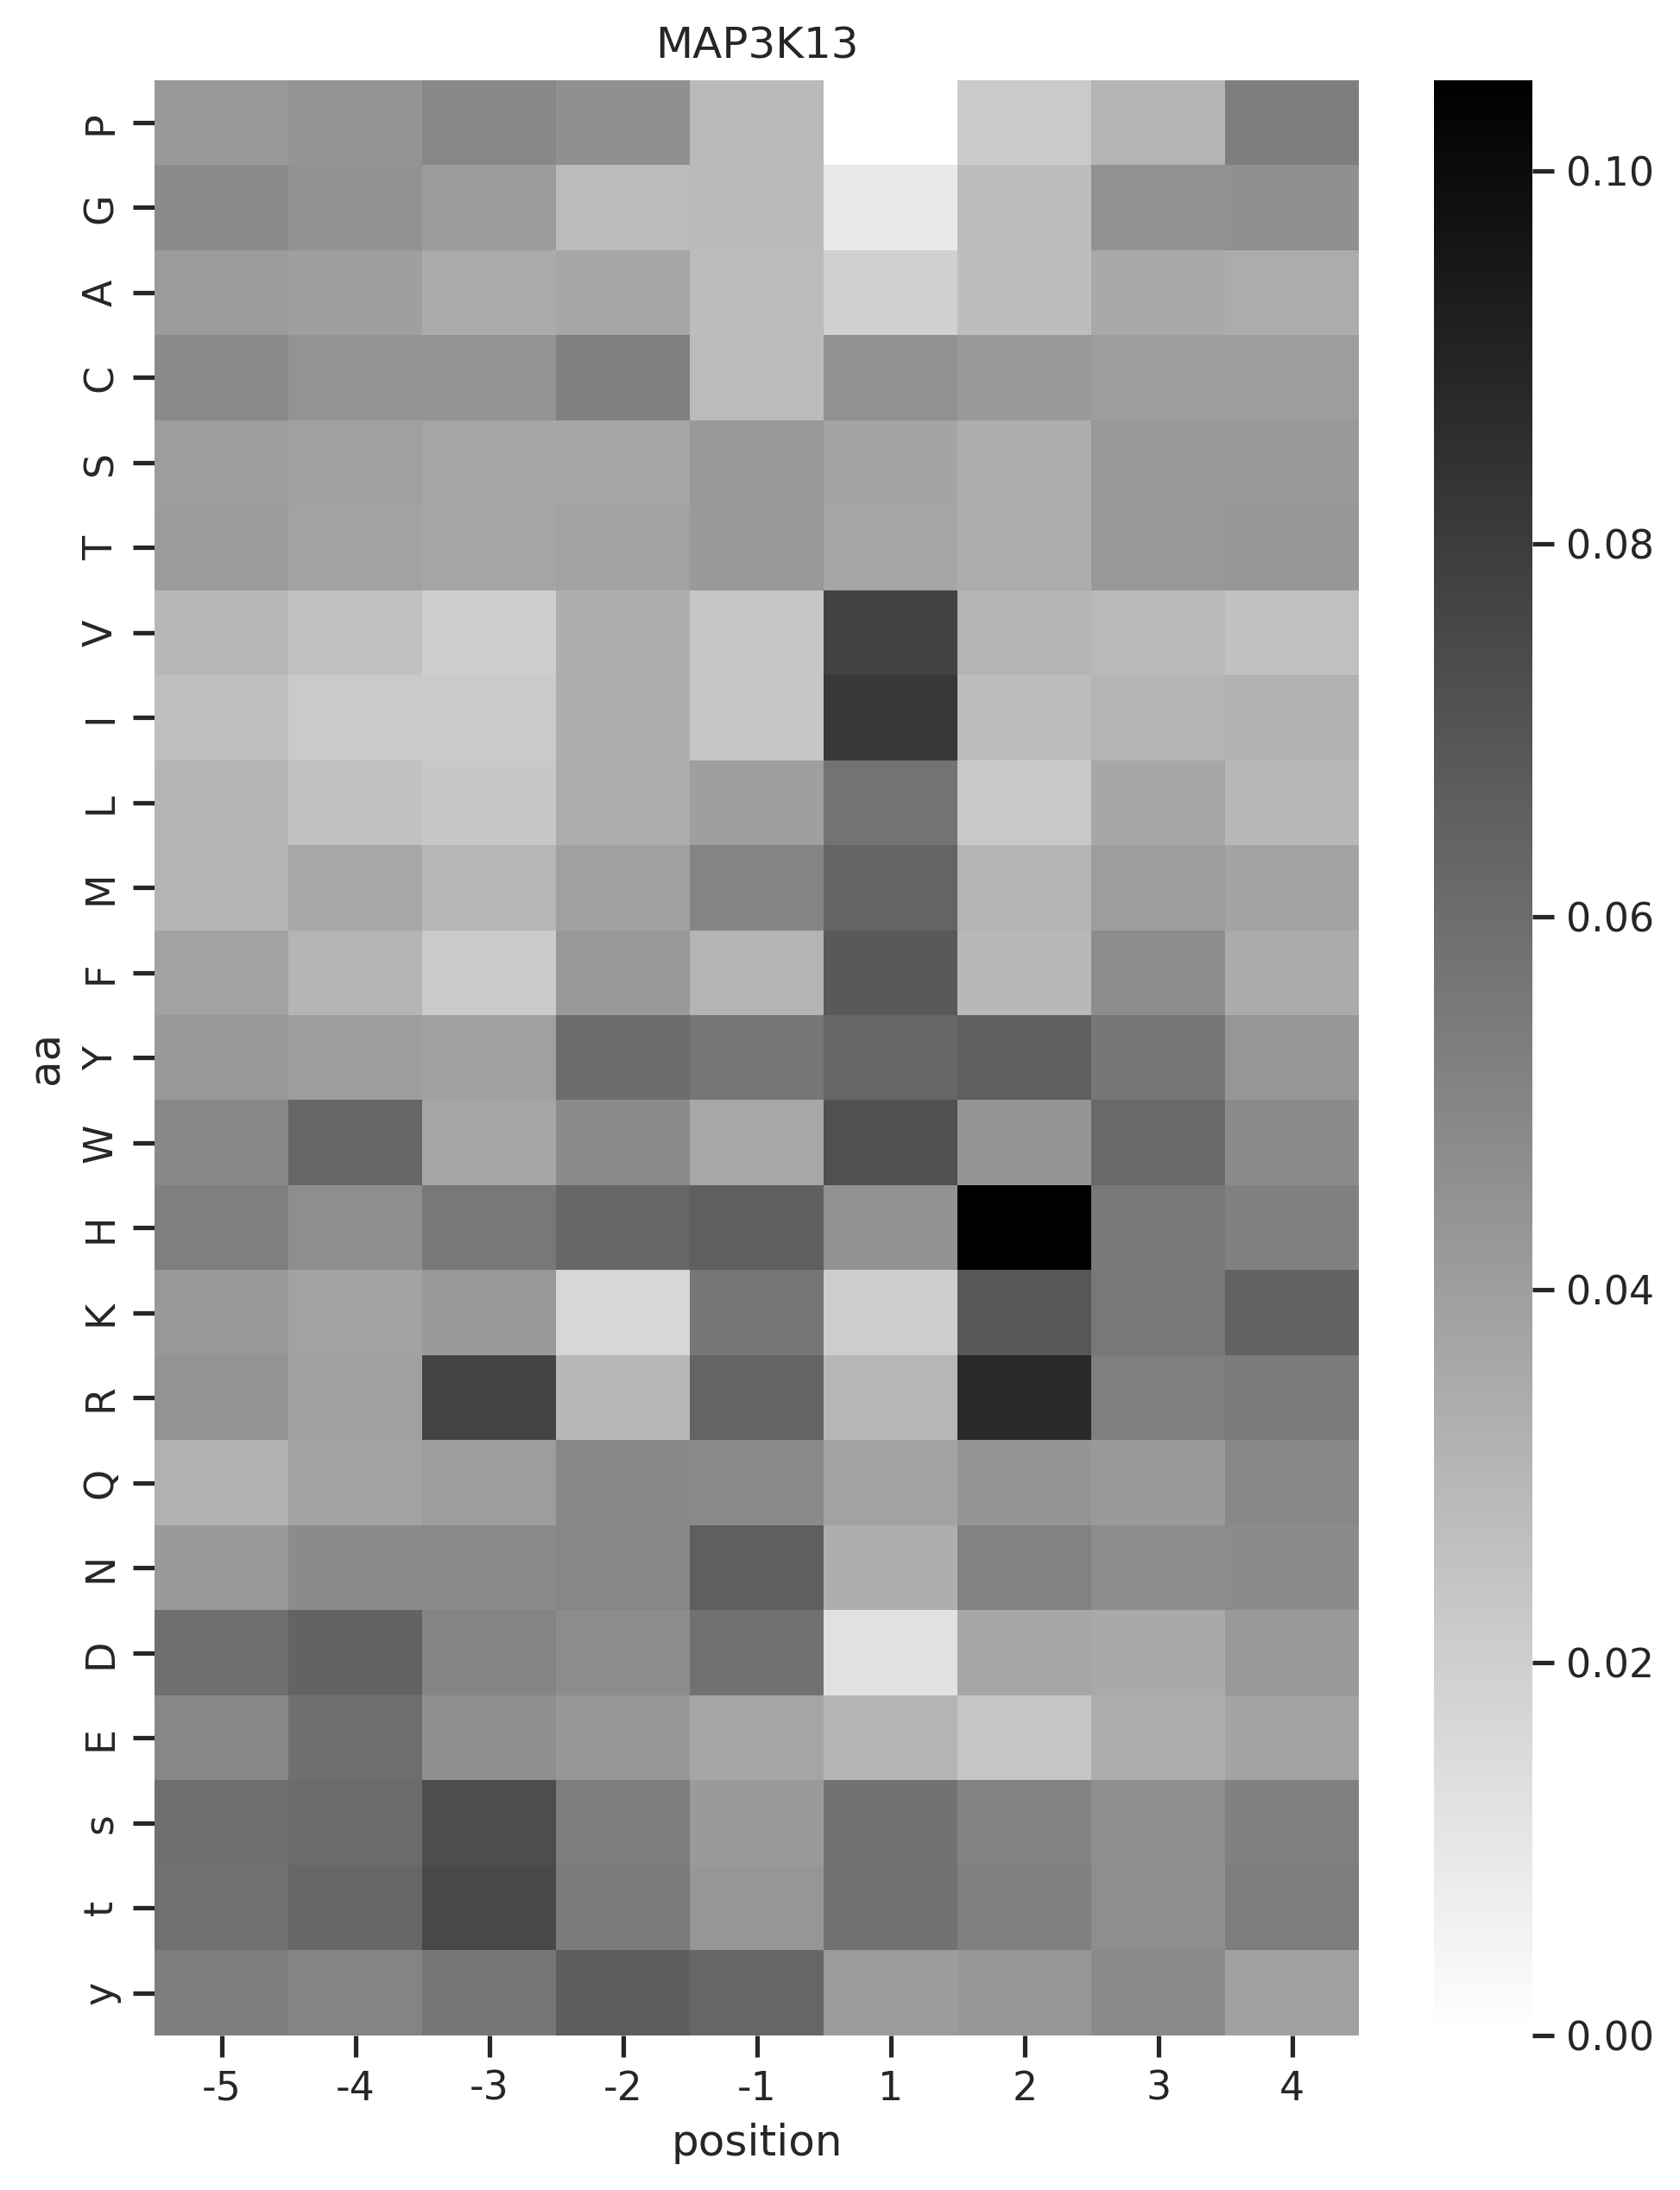

STE11:0.7499031572306992


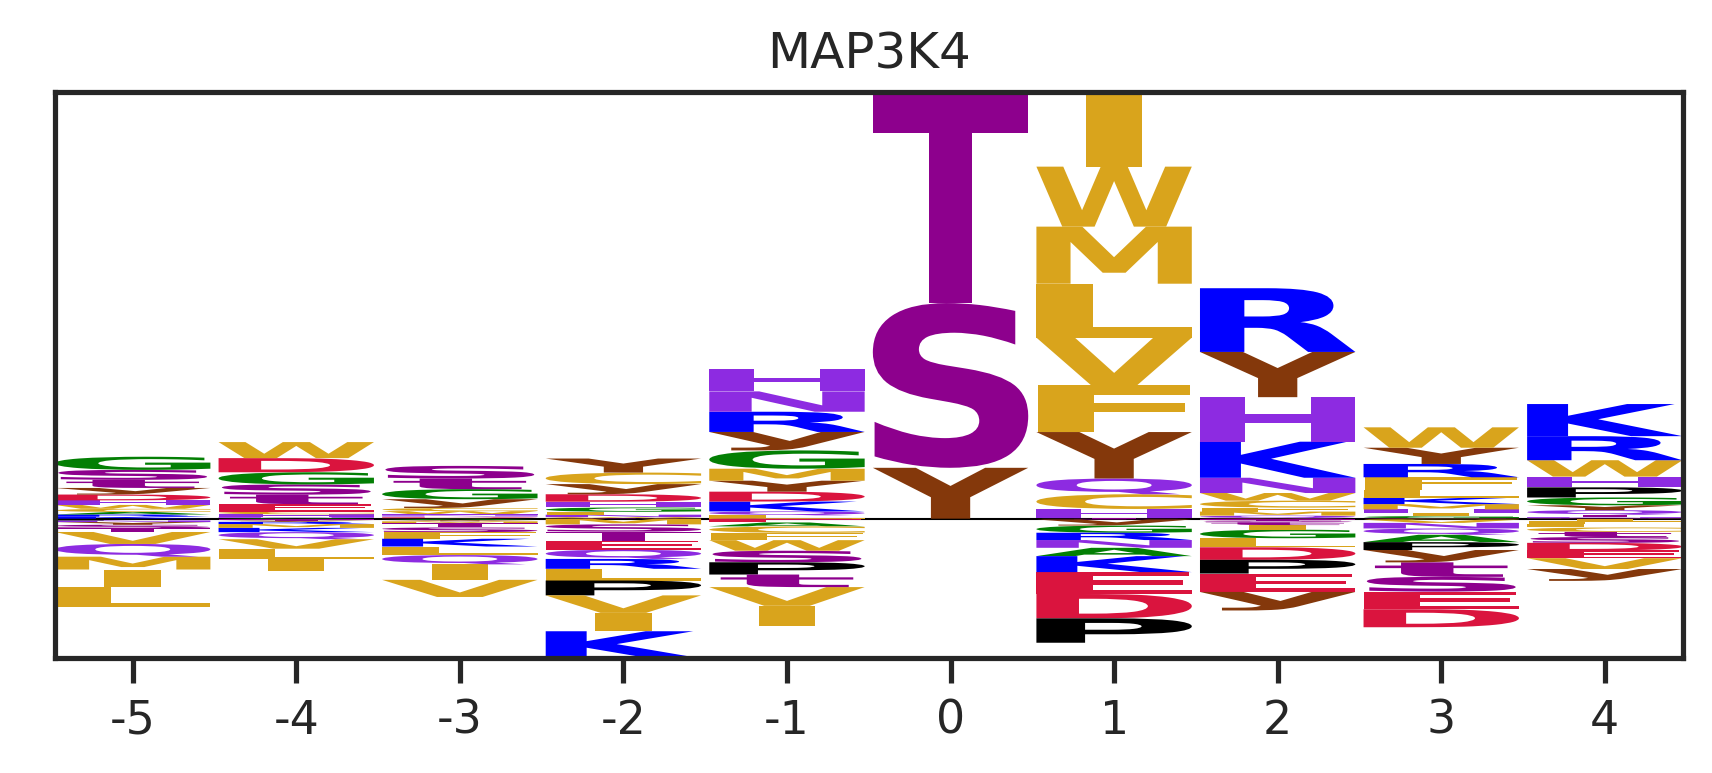

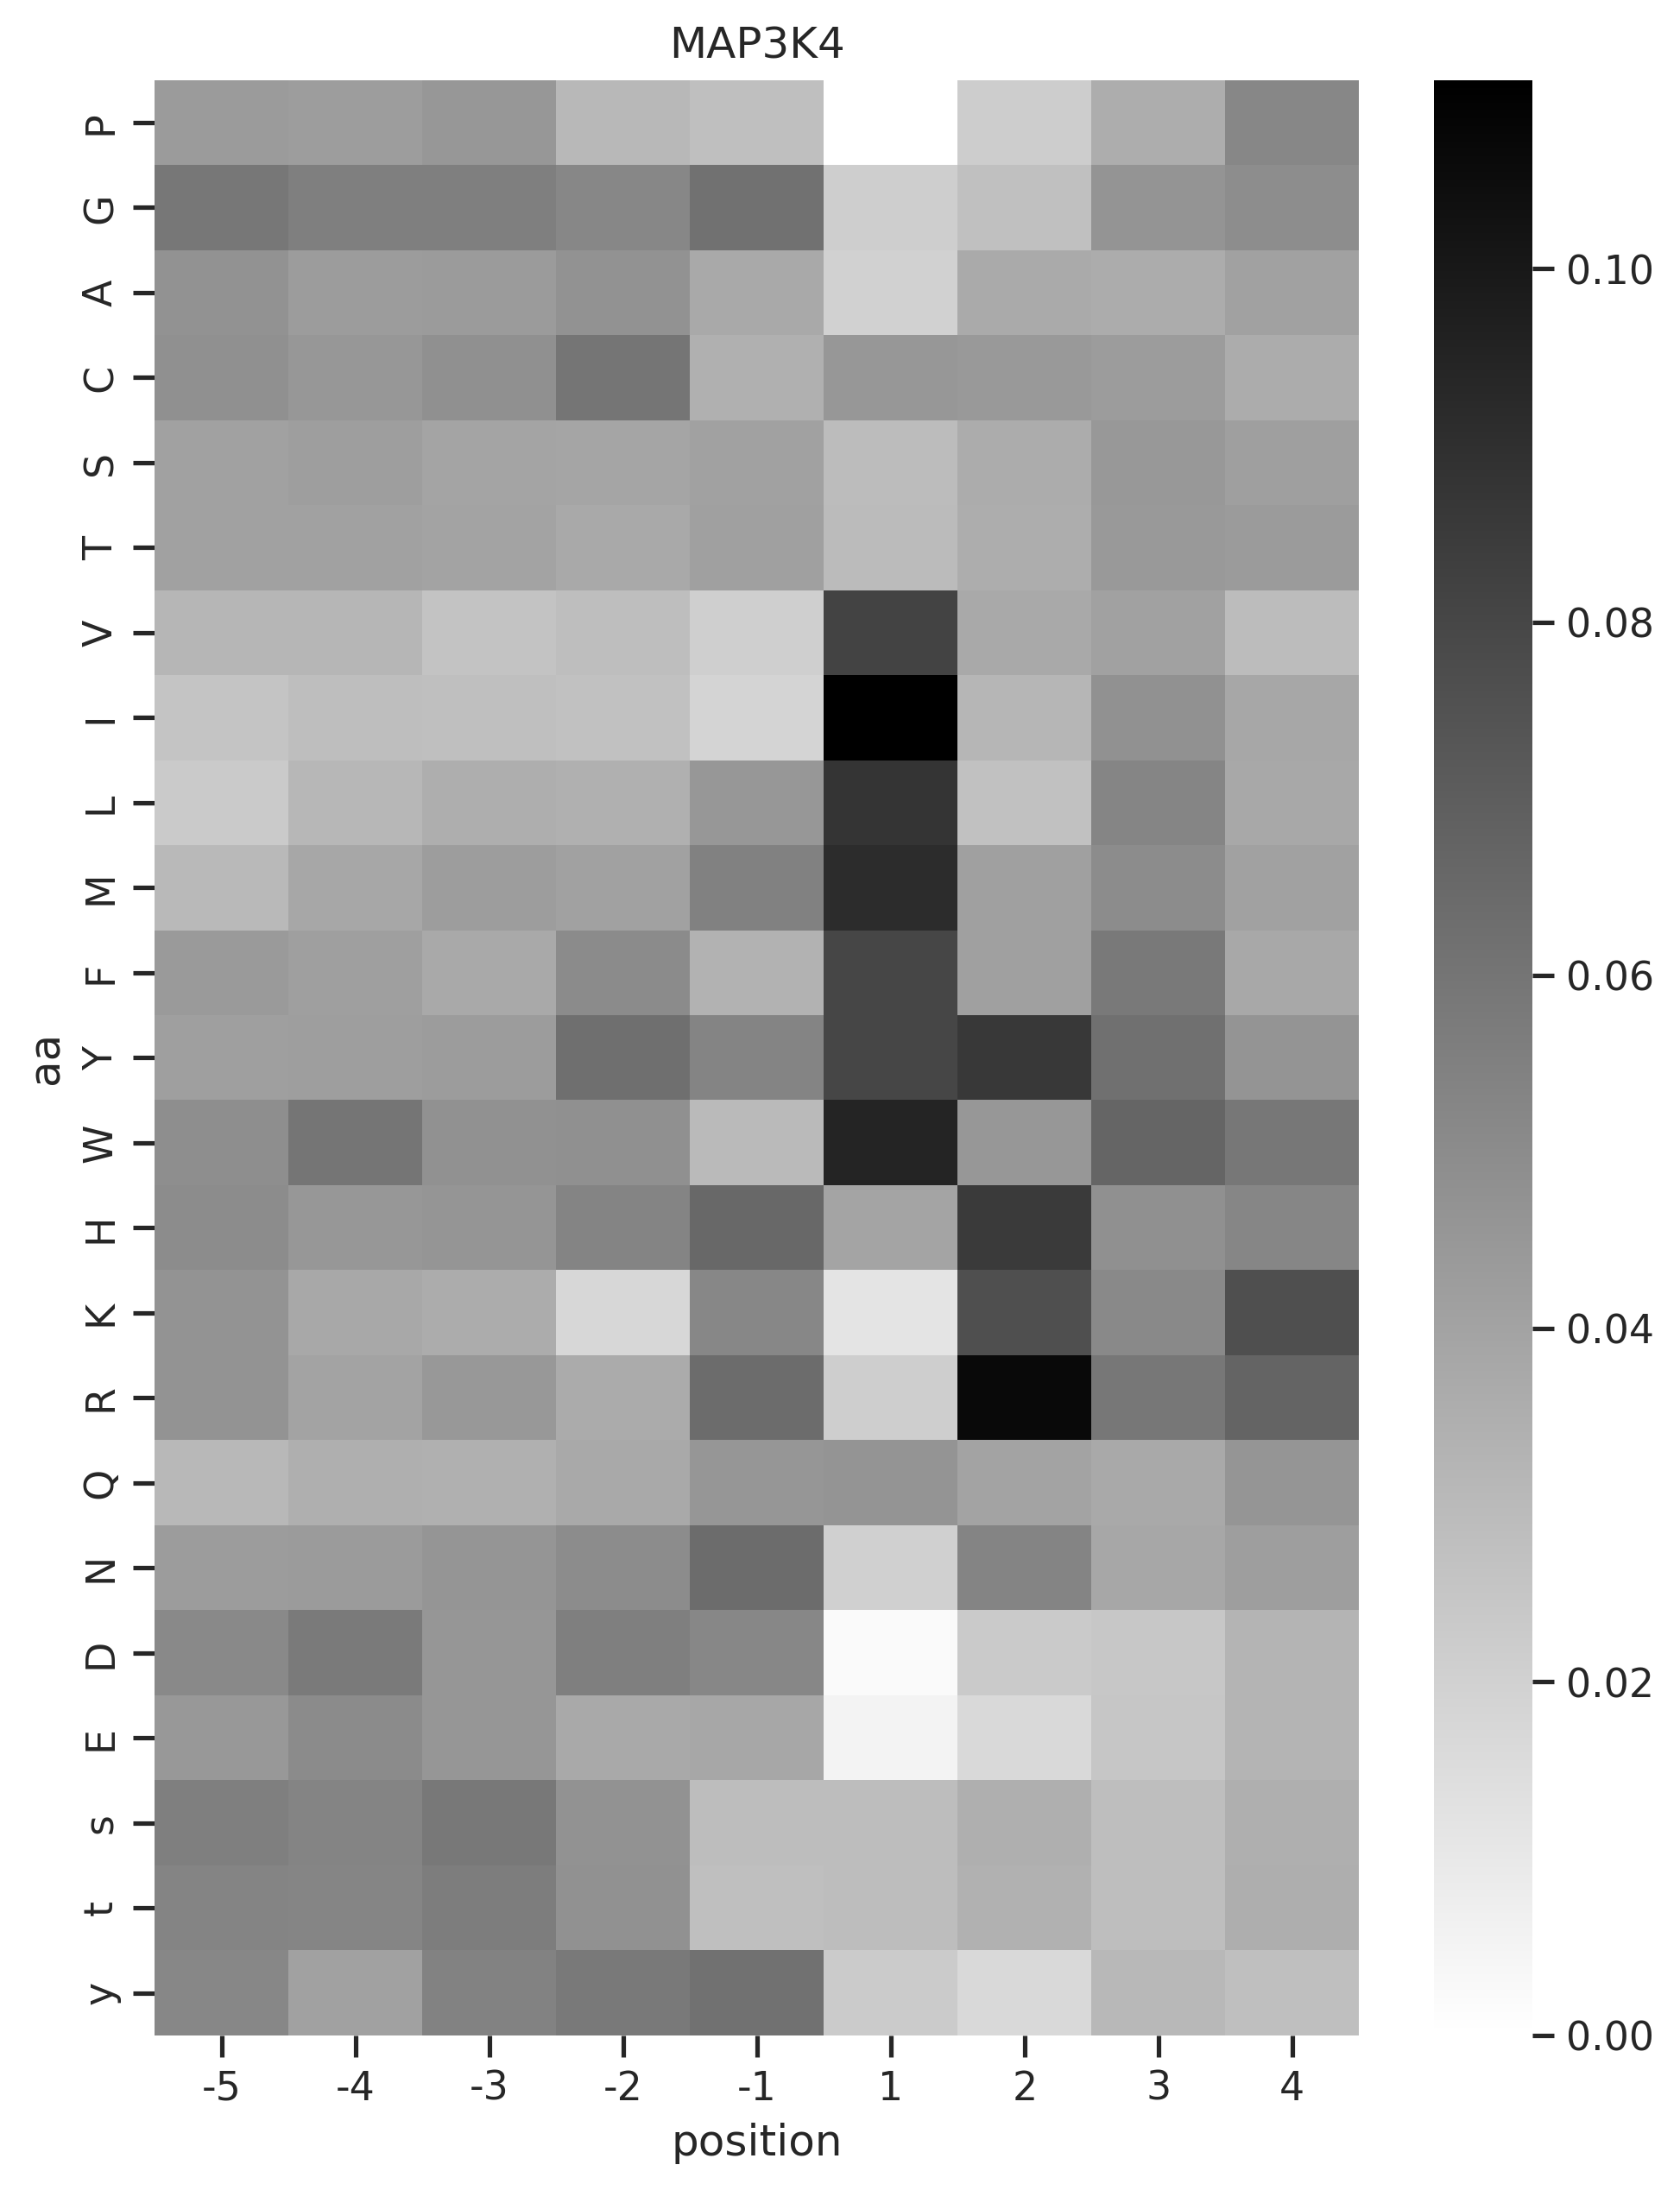

STKR:0.8578397866239376


NEK:0.7782348100131159


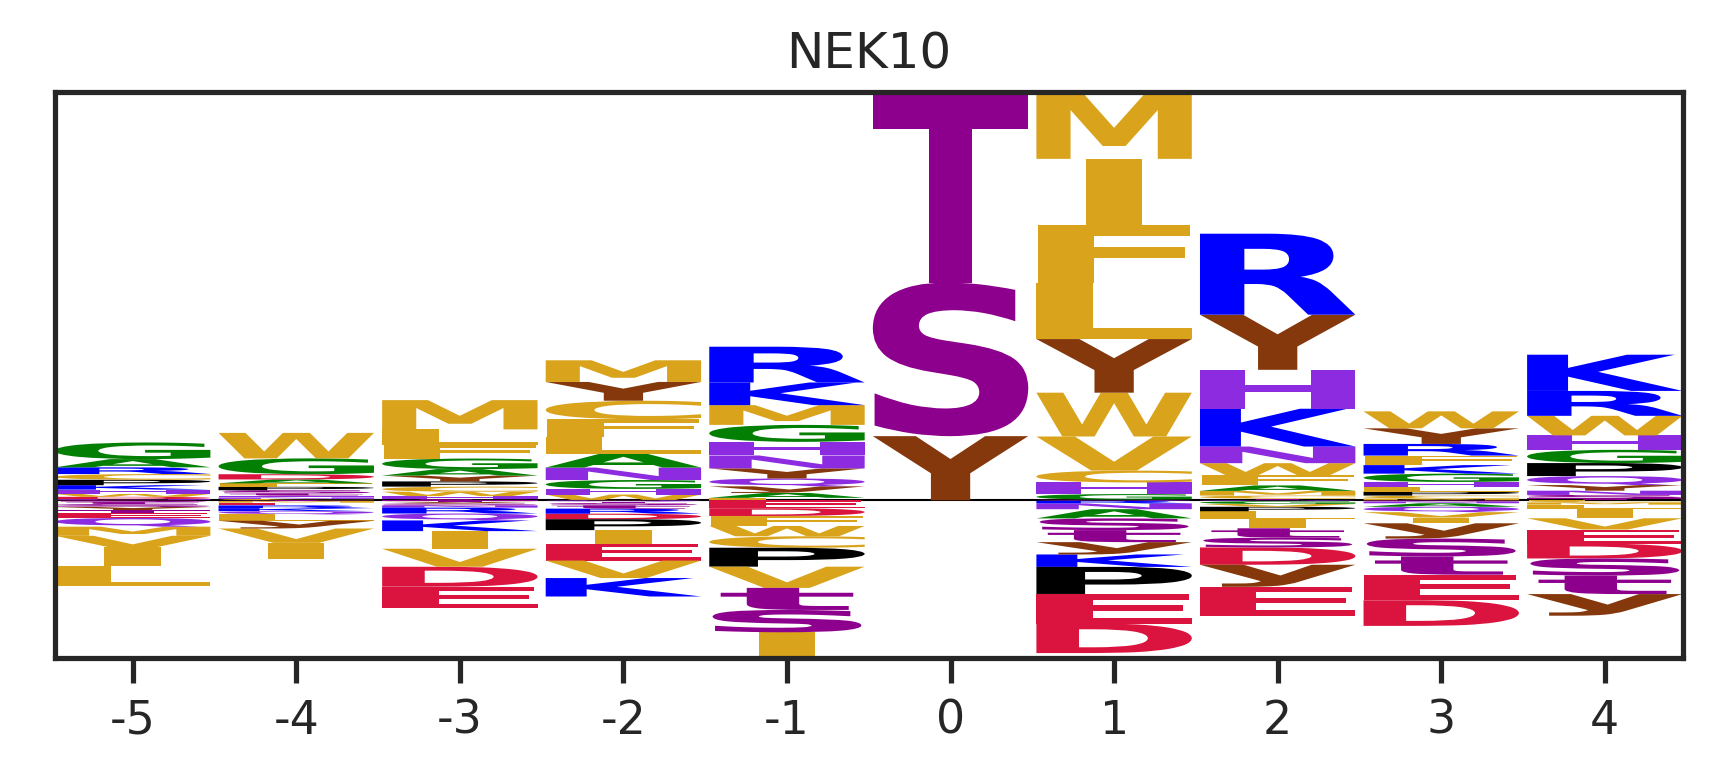

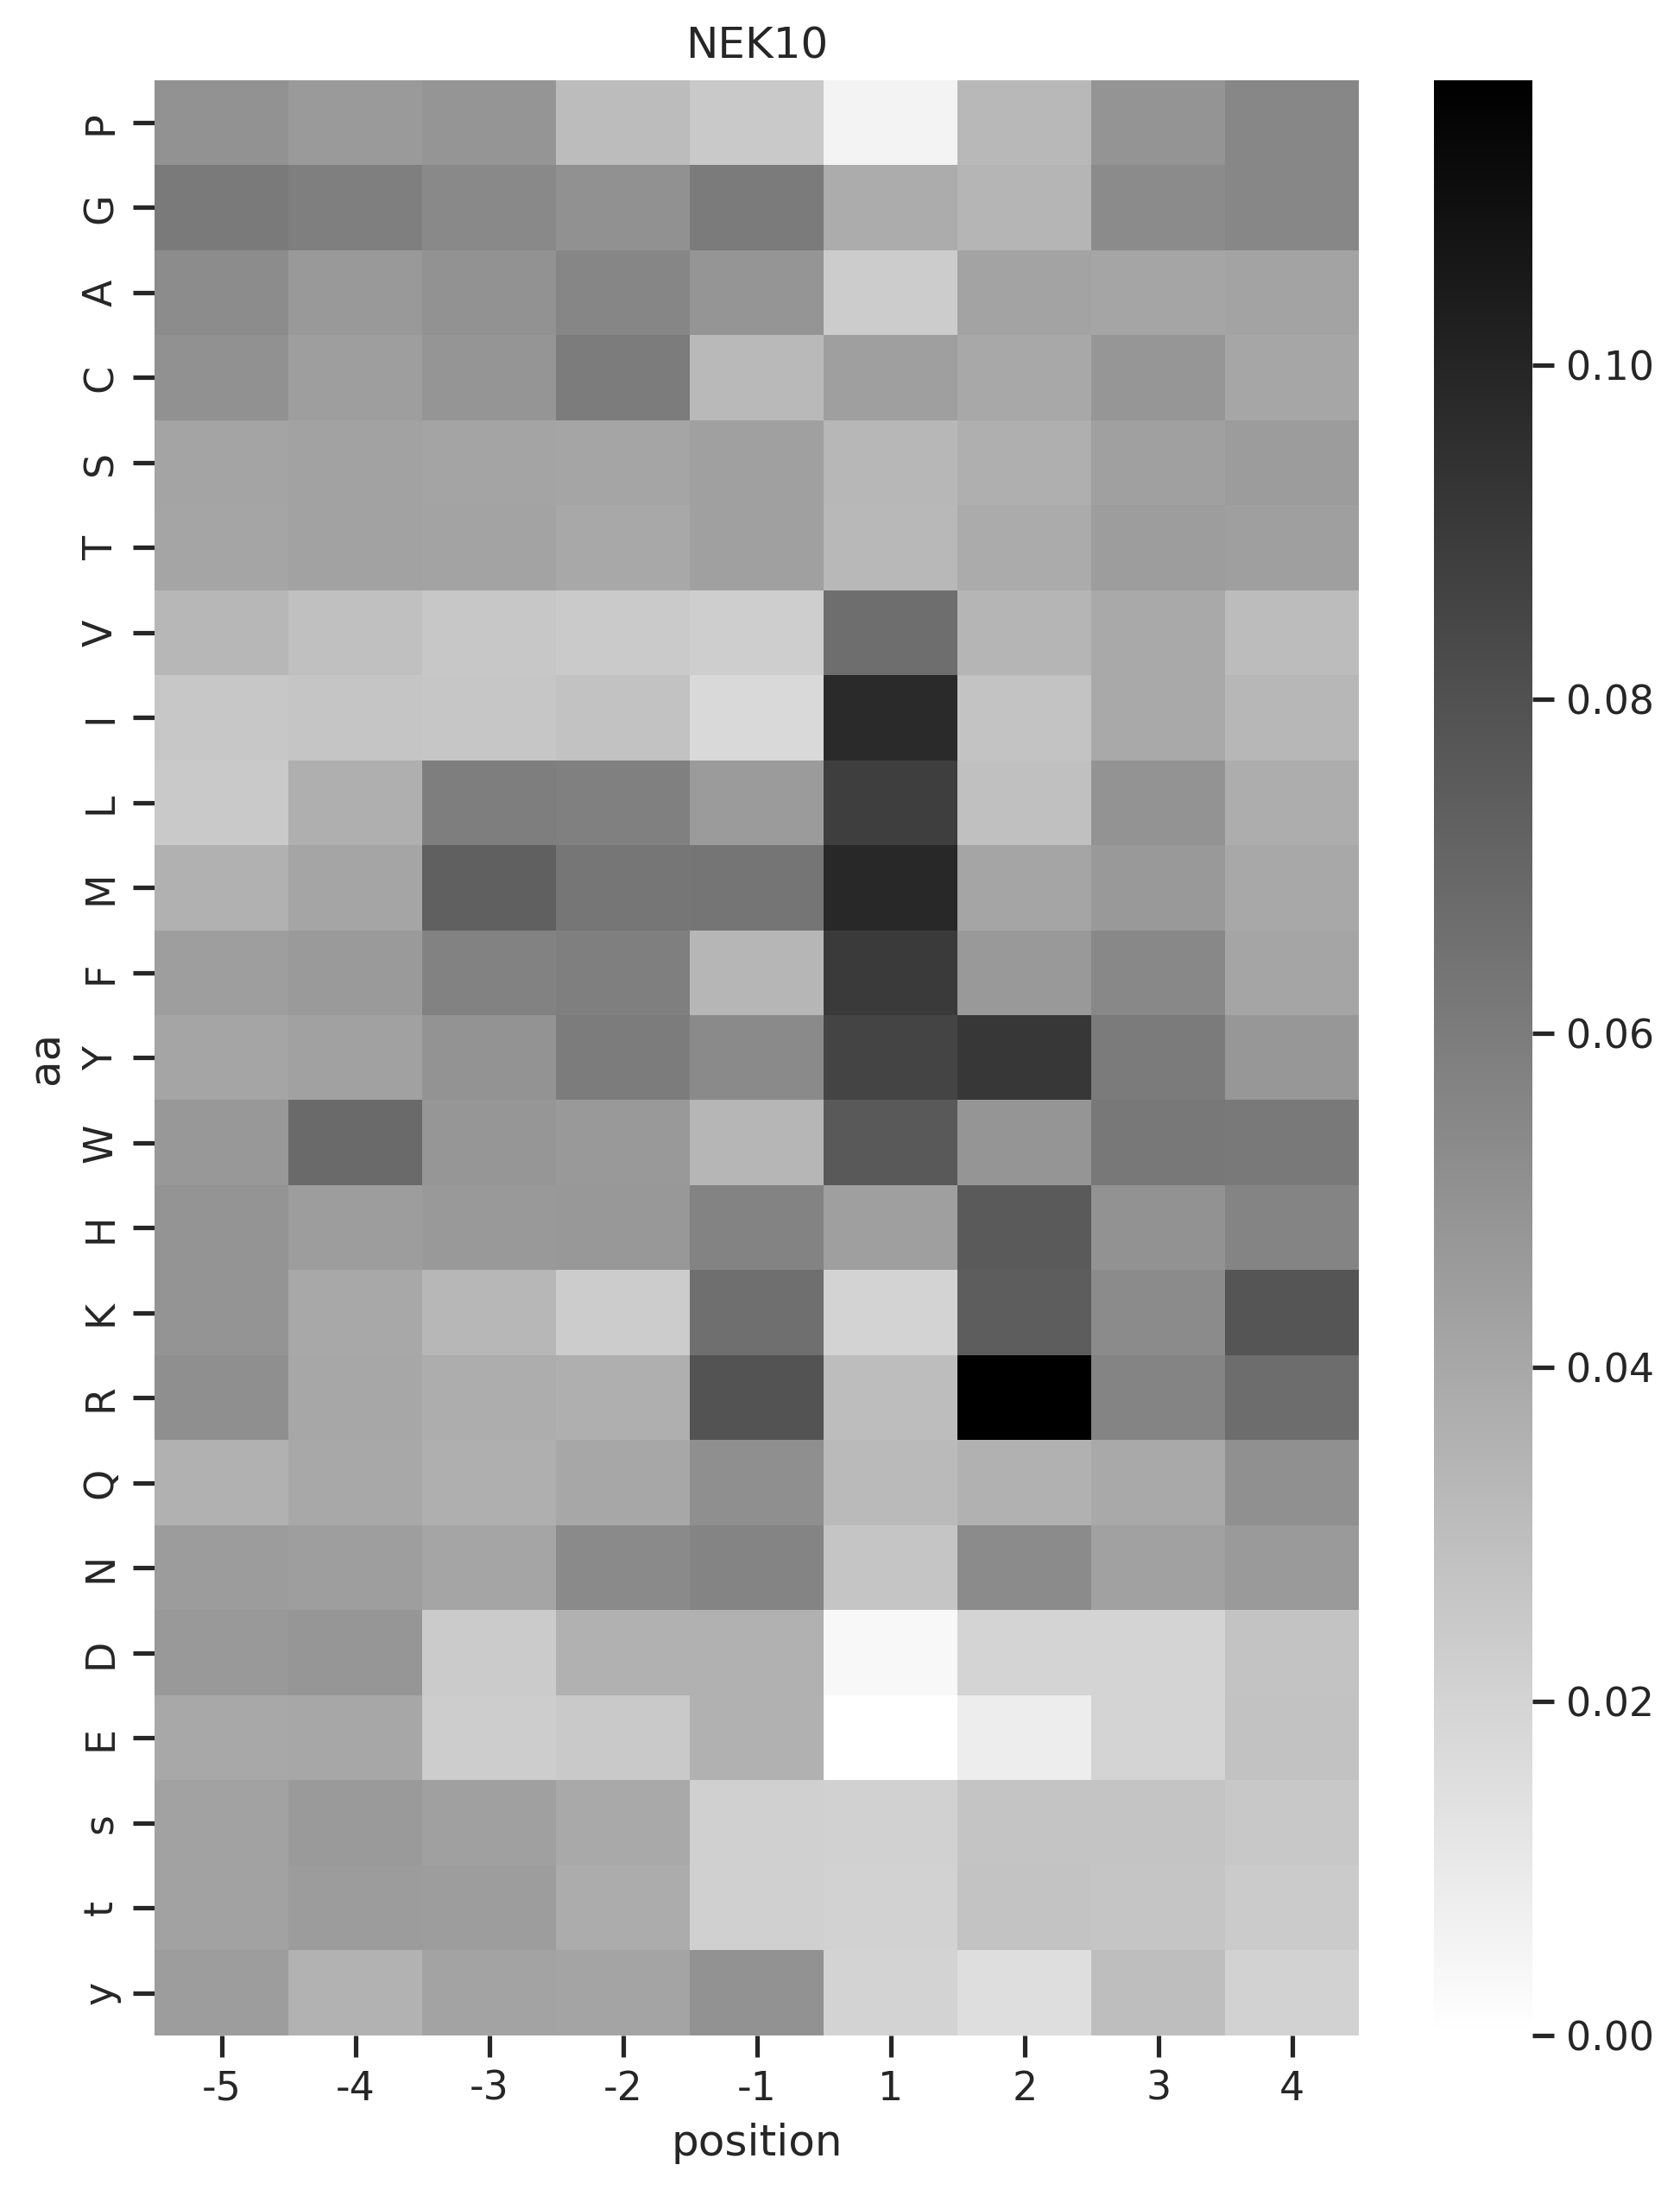

STE20:0.8639317629980943


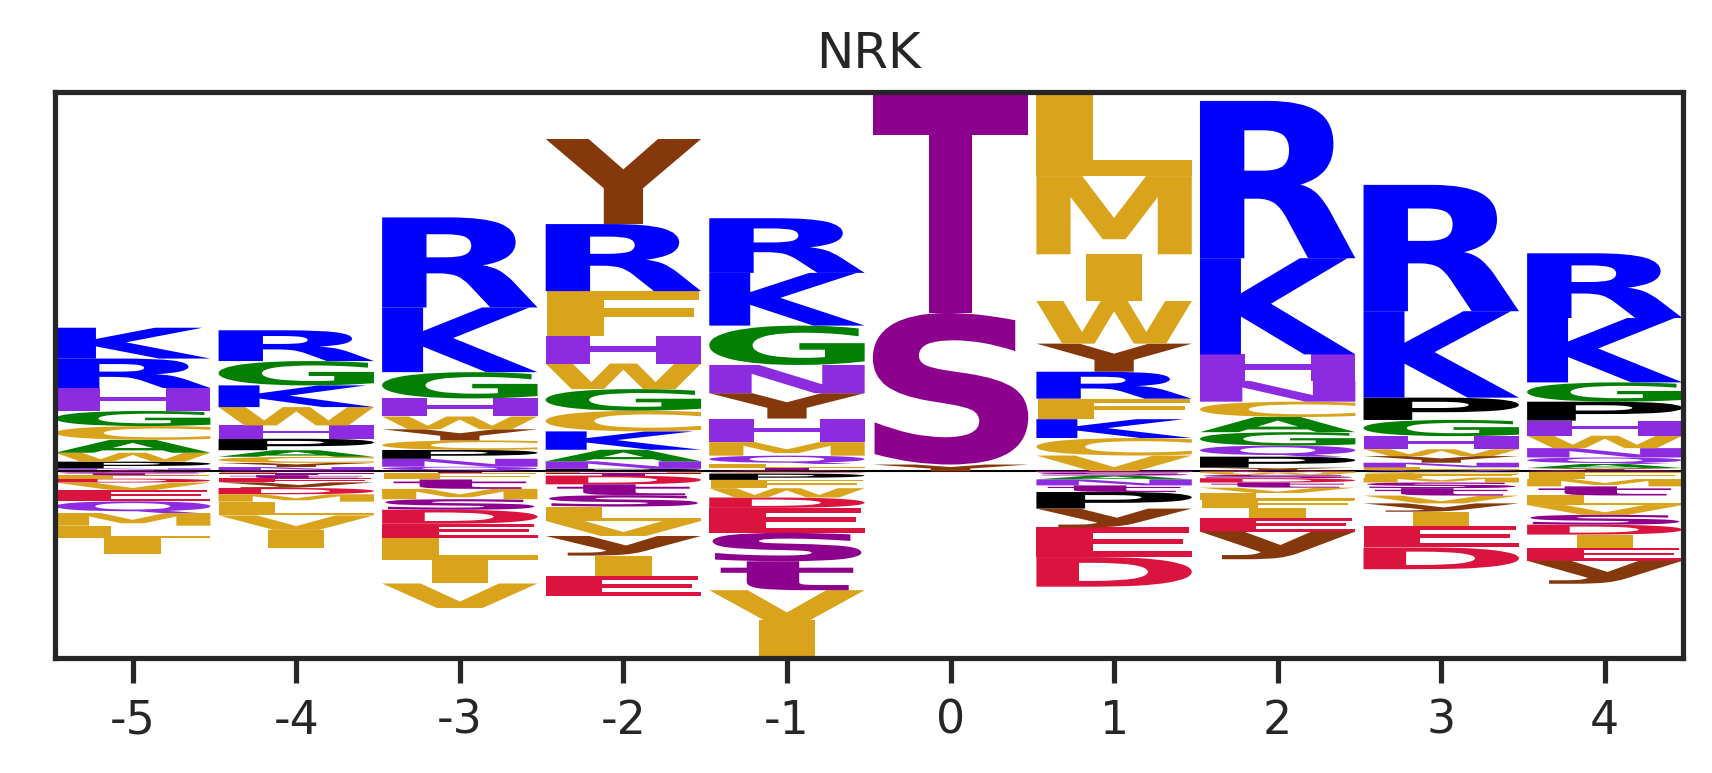

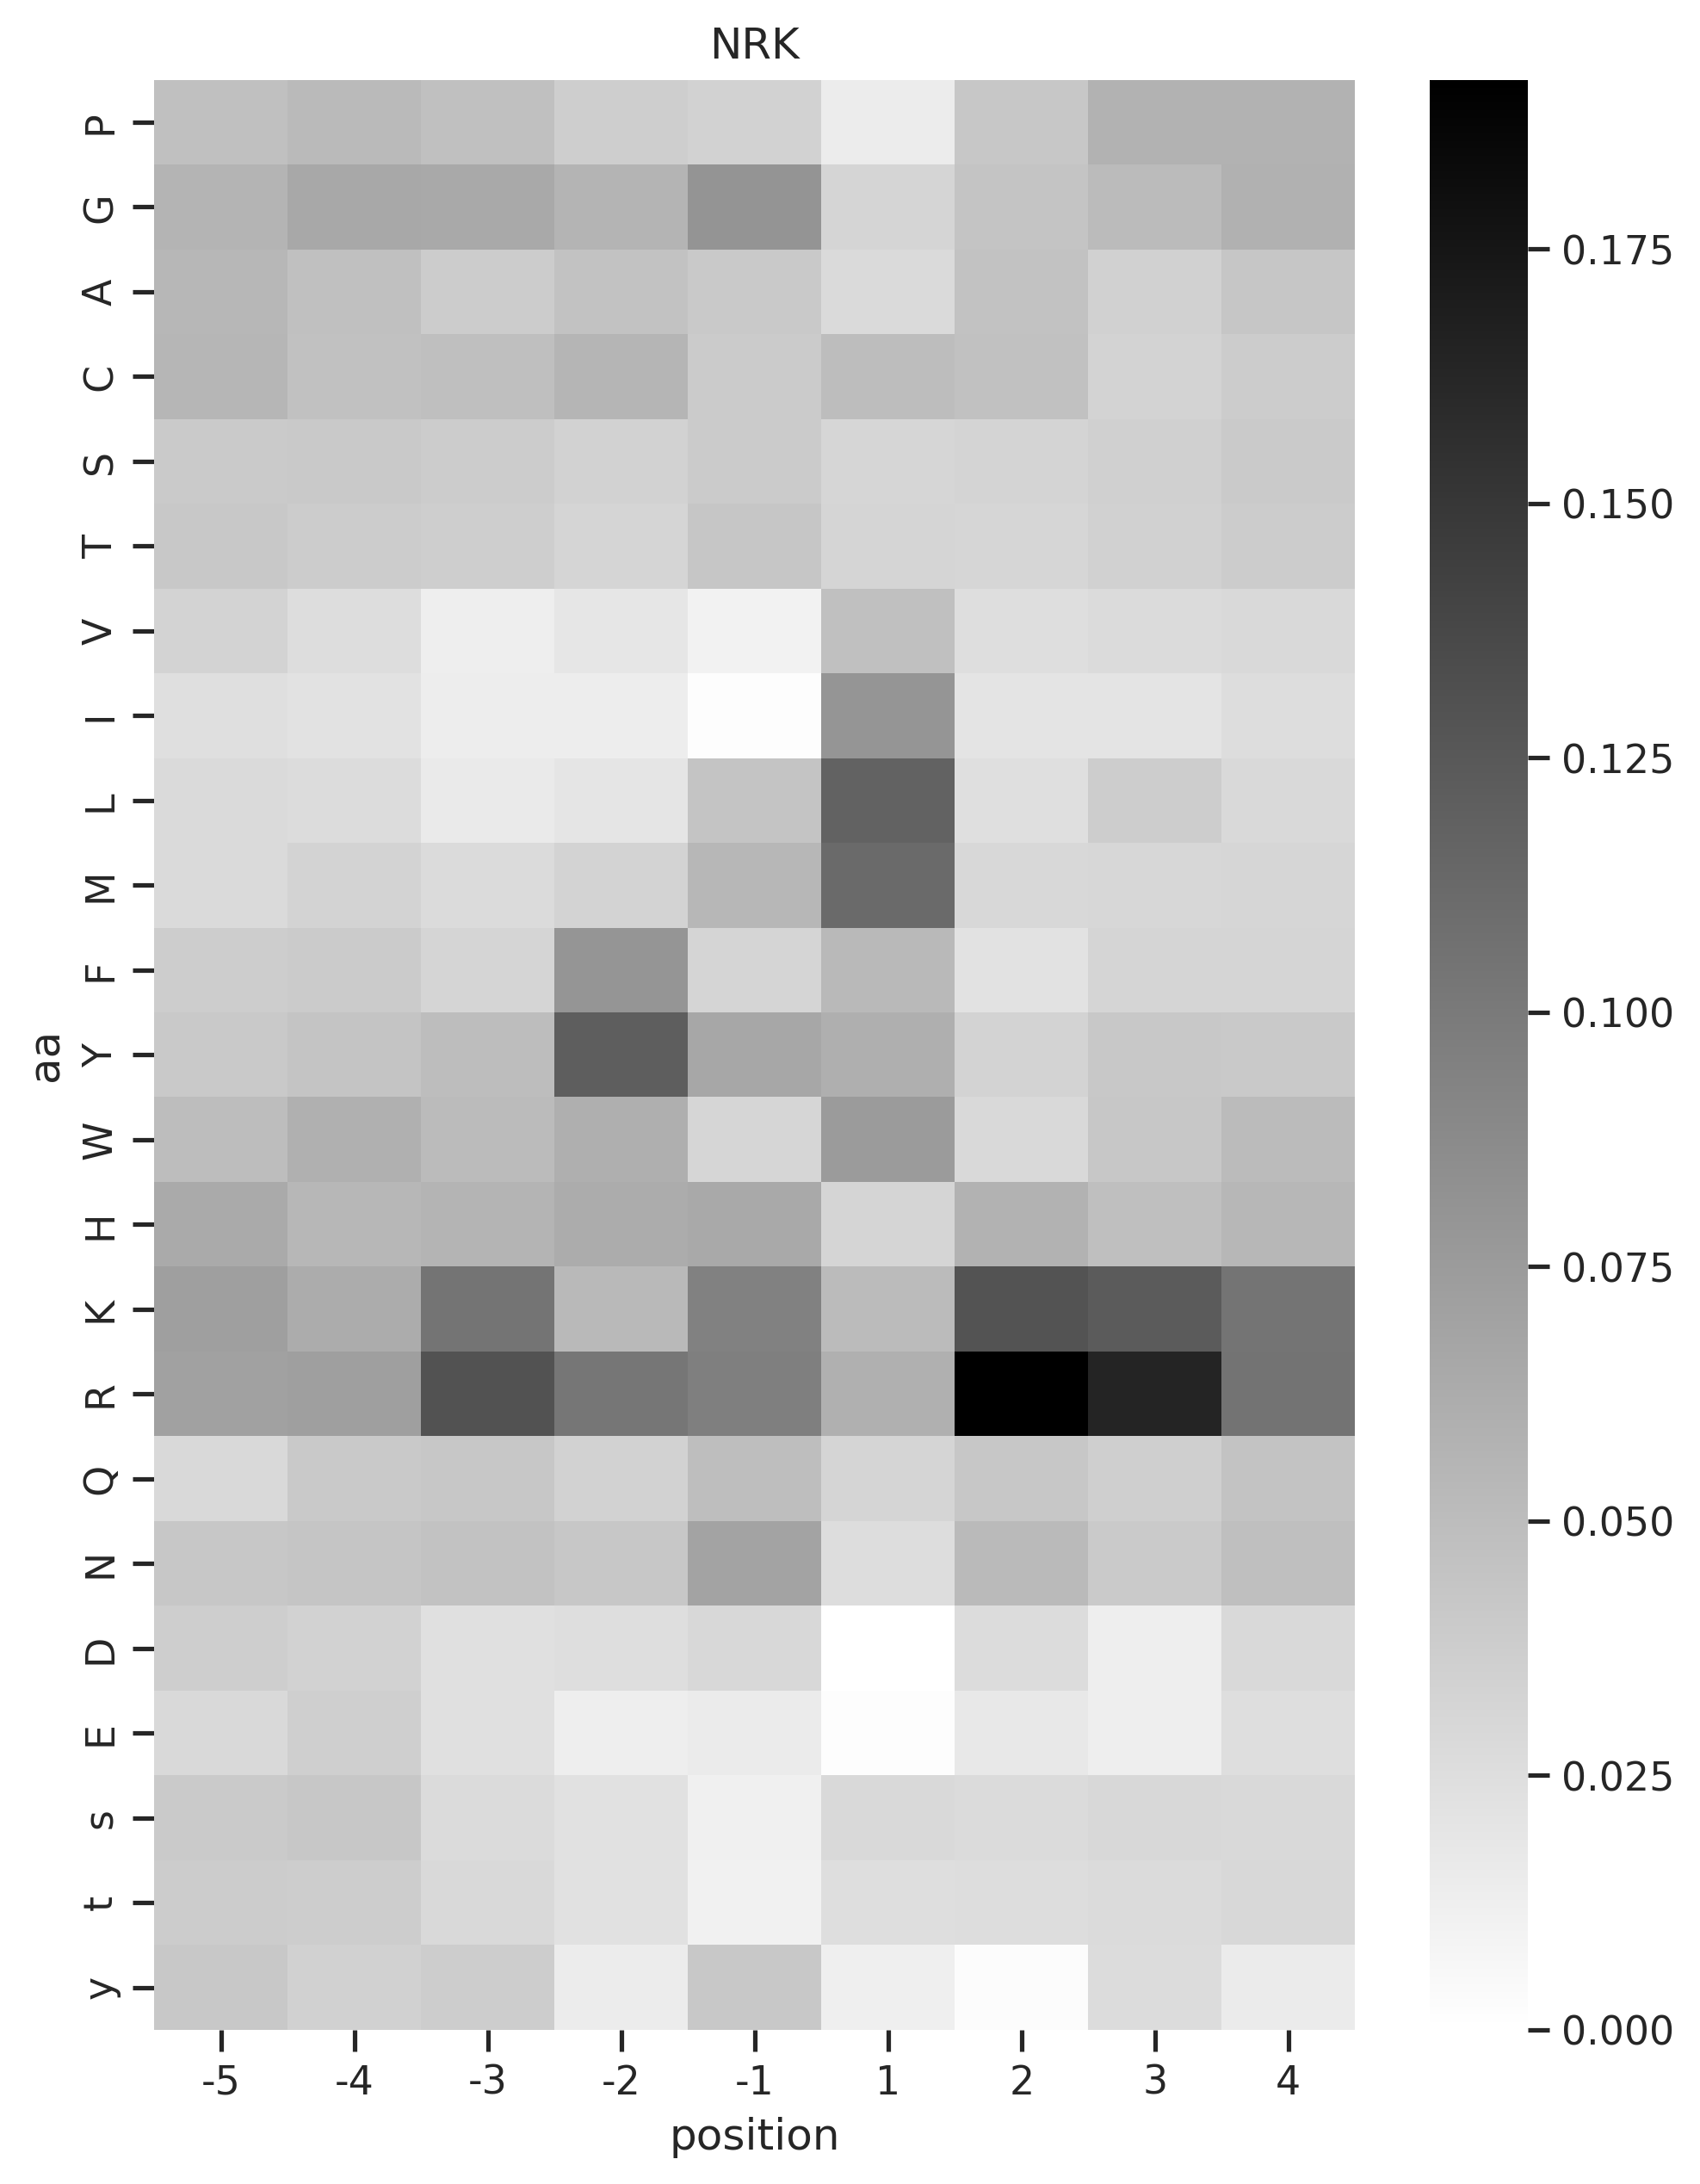

PDHK:0.6766899079964322


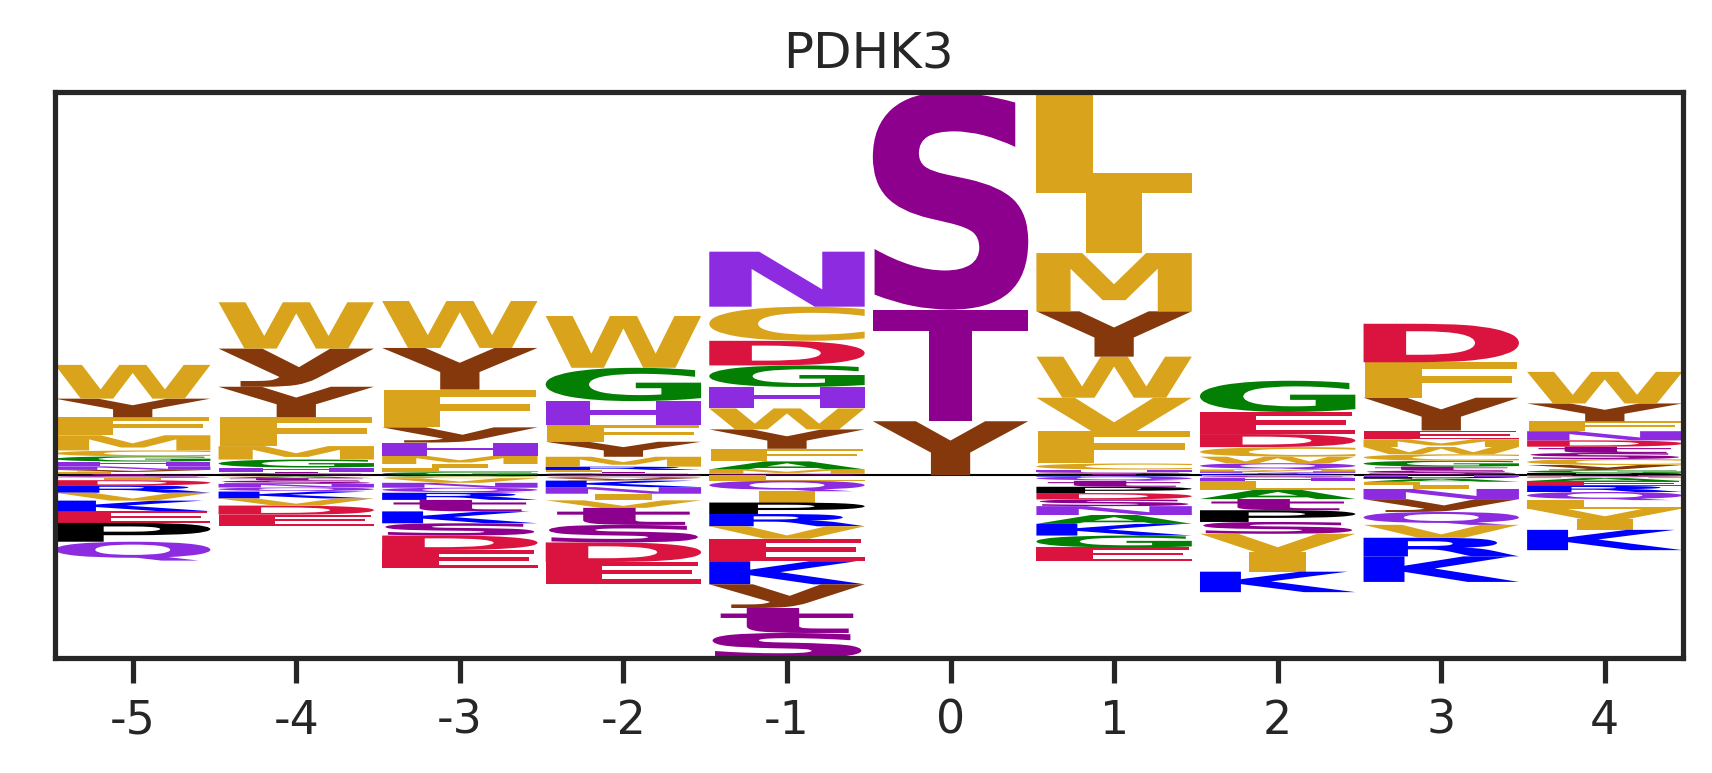

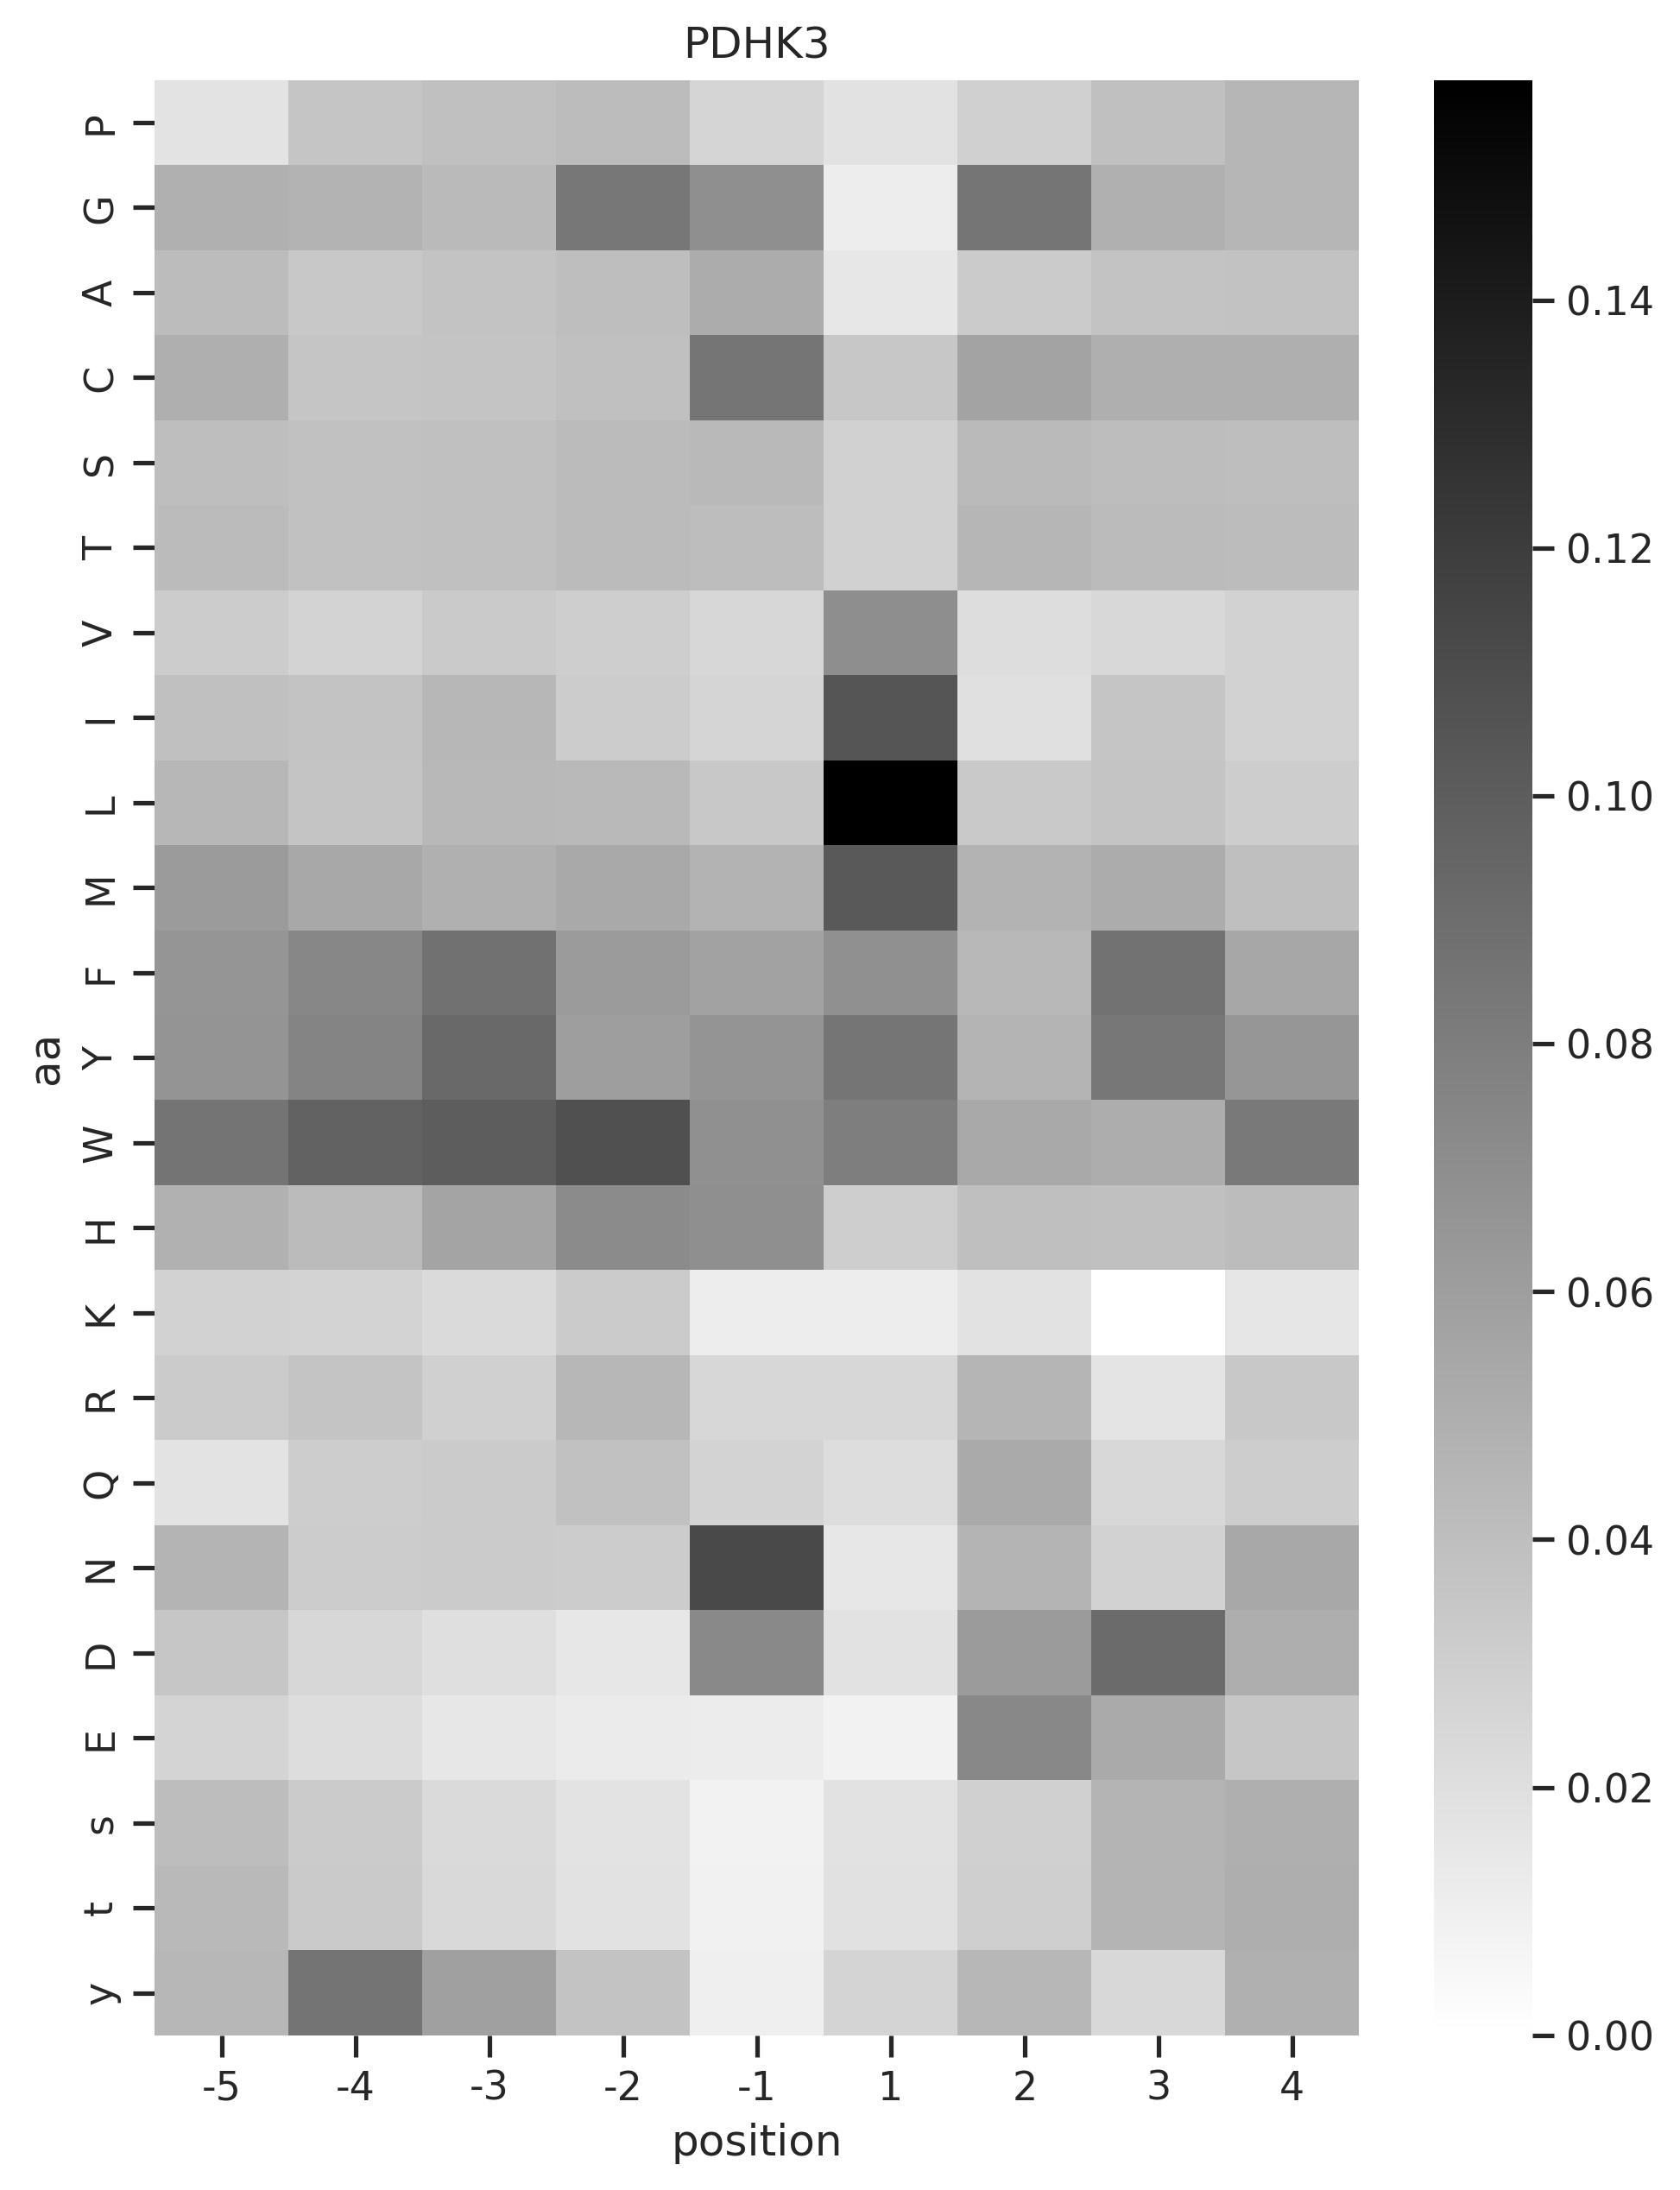

CDK:0.9232645242649458


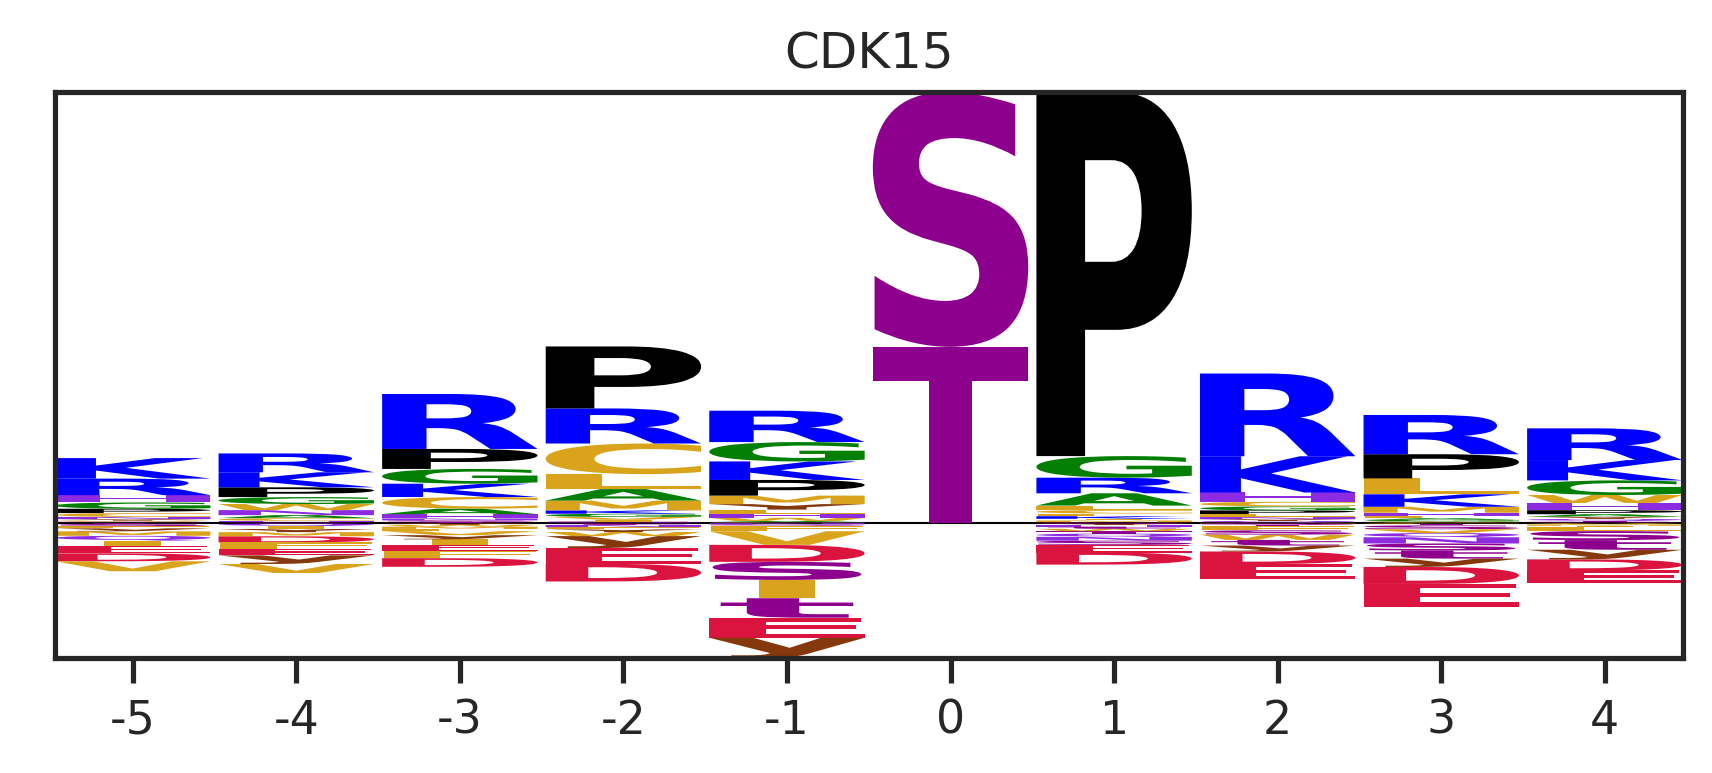

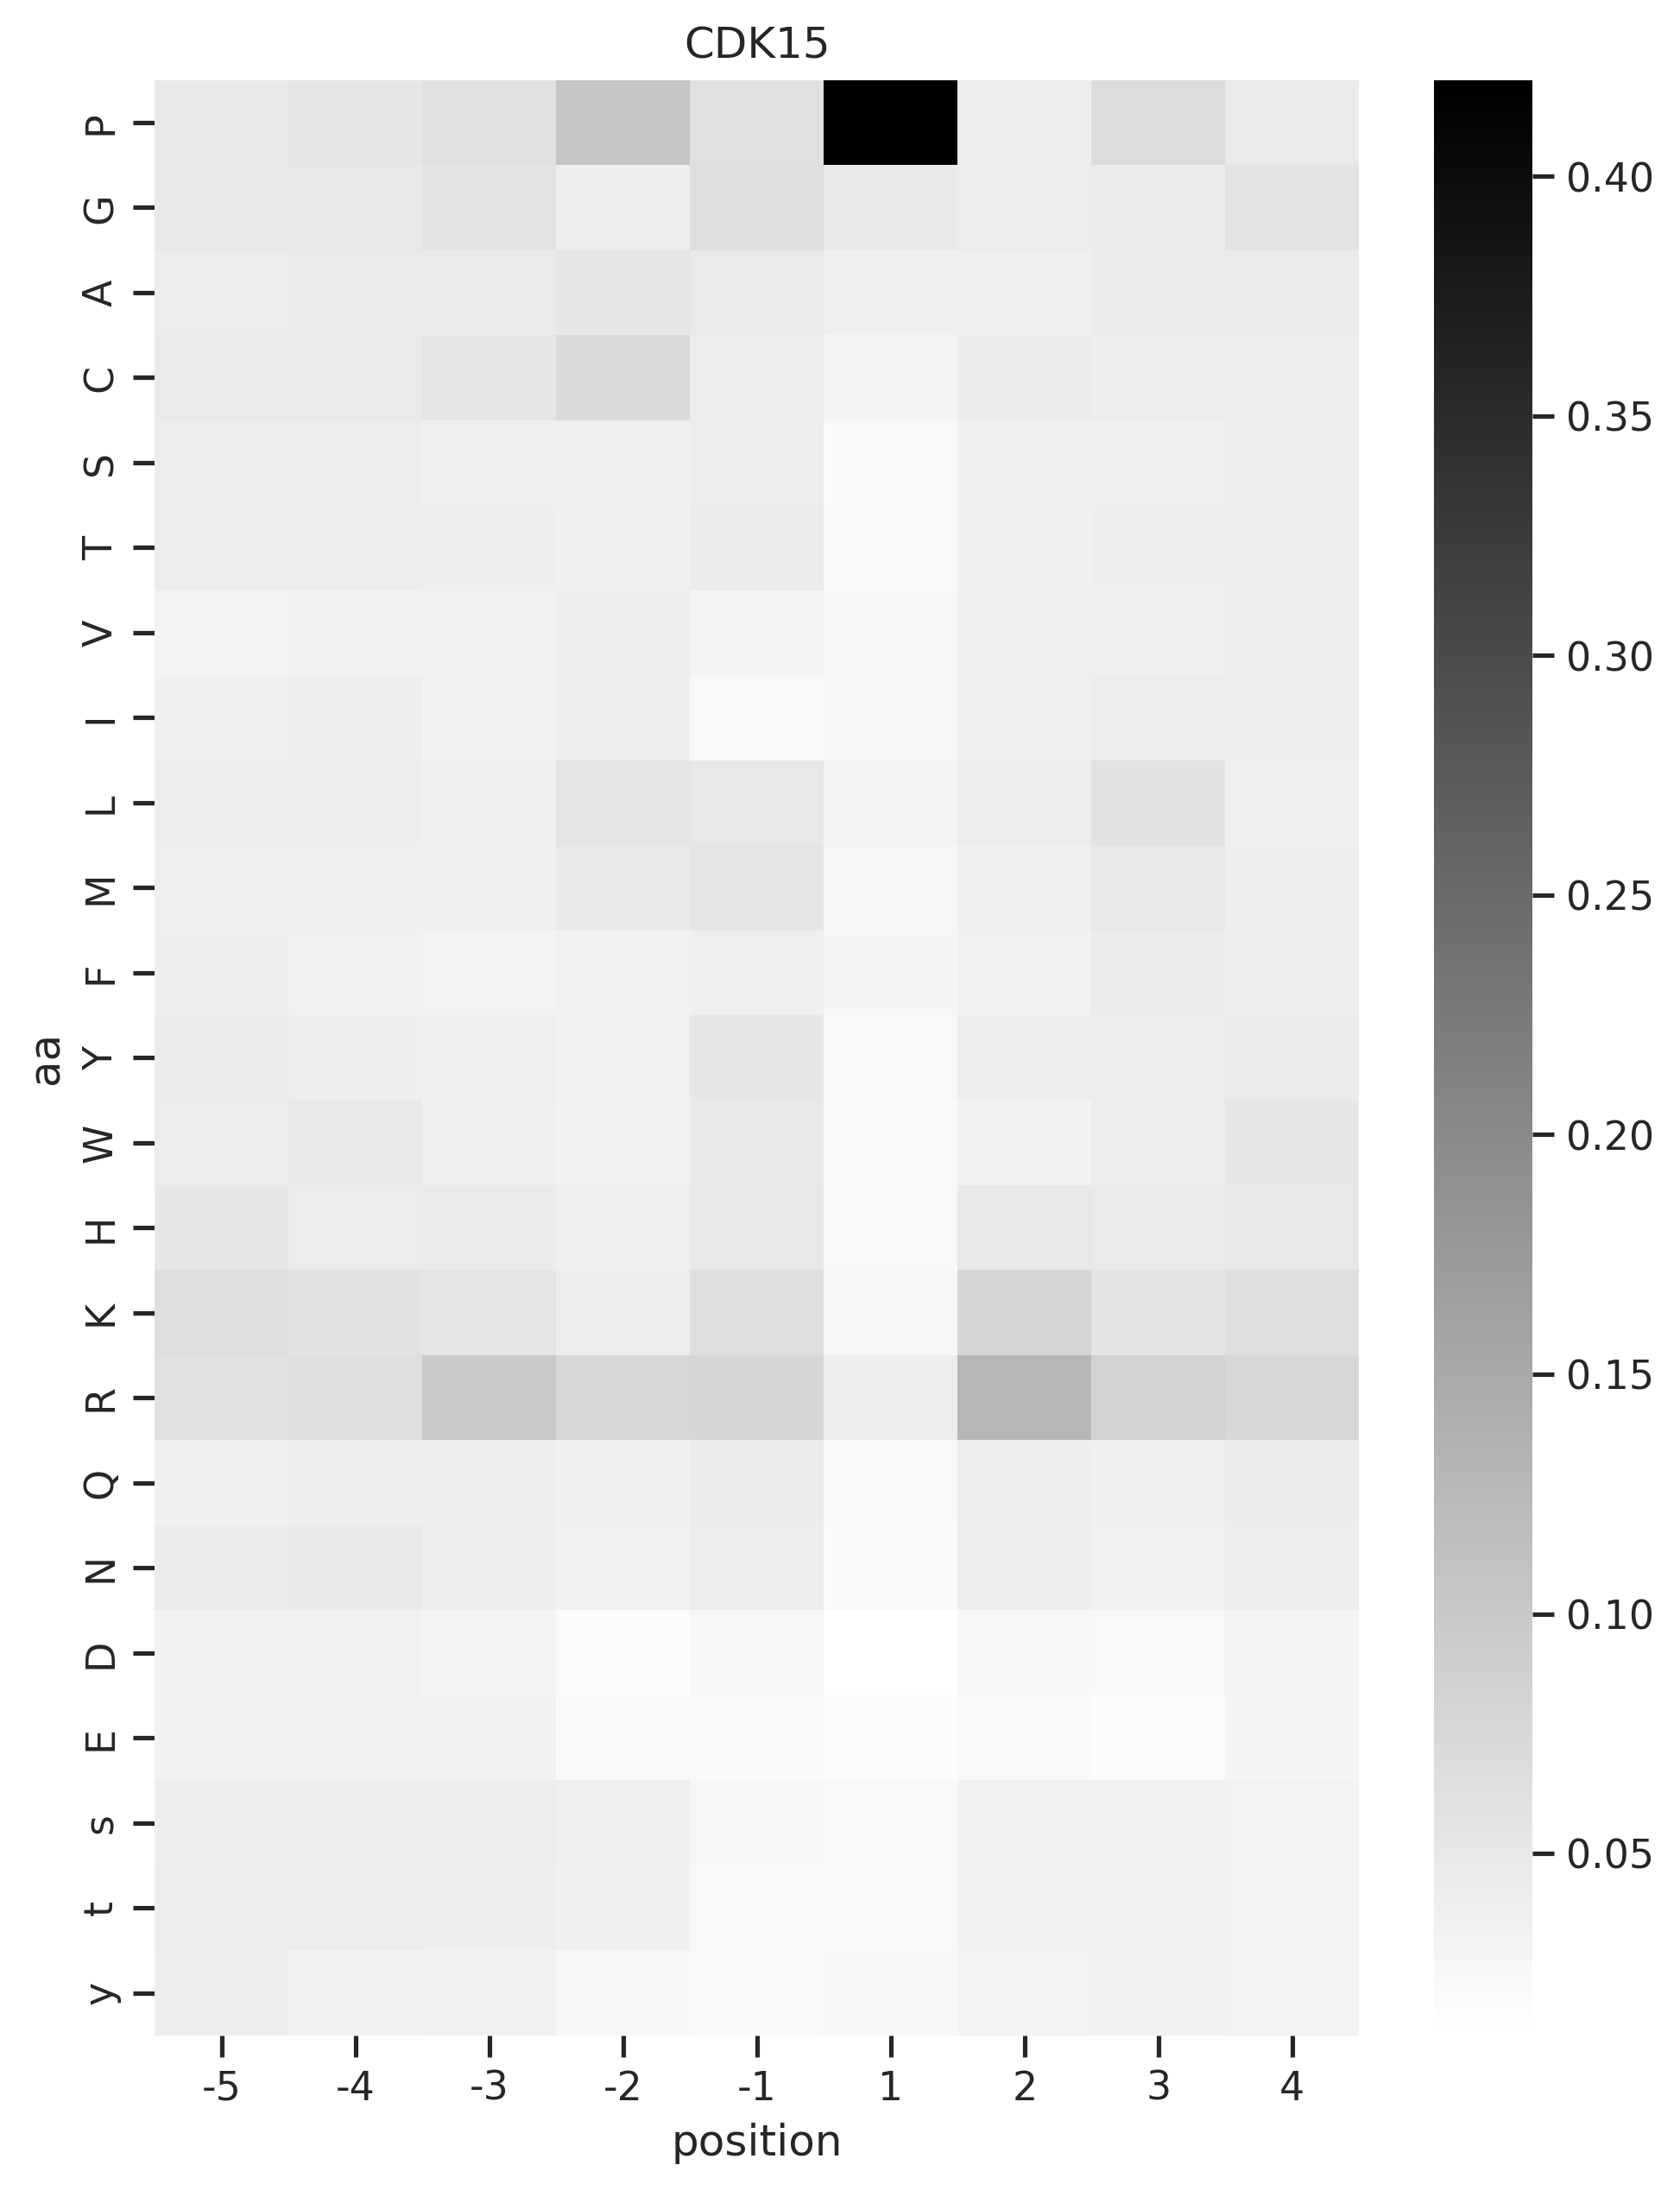

CDK:0.9232645242649458


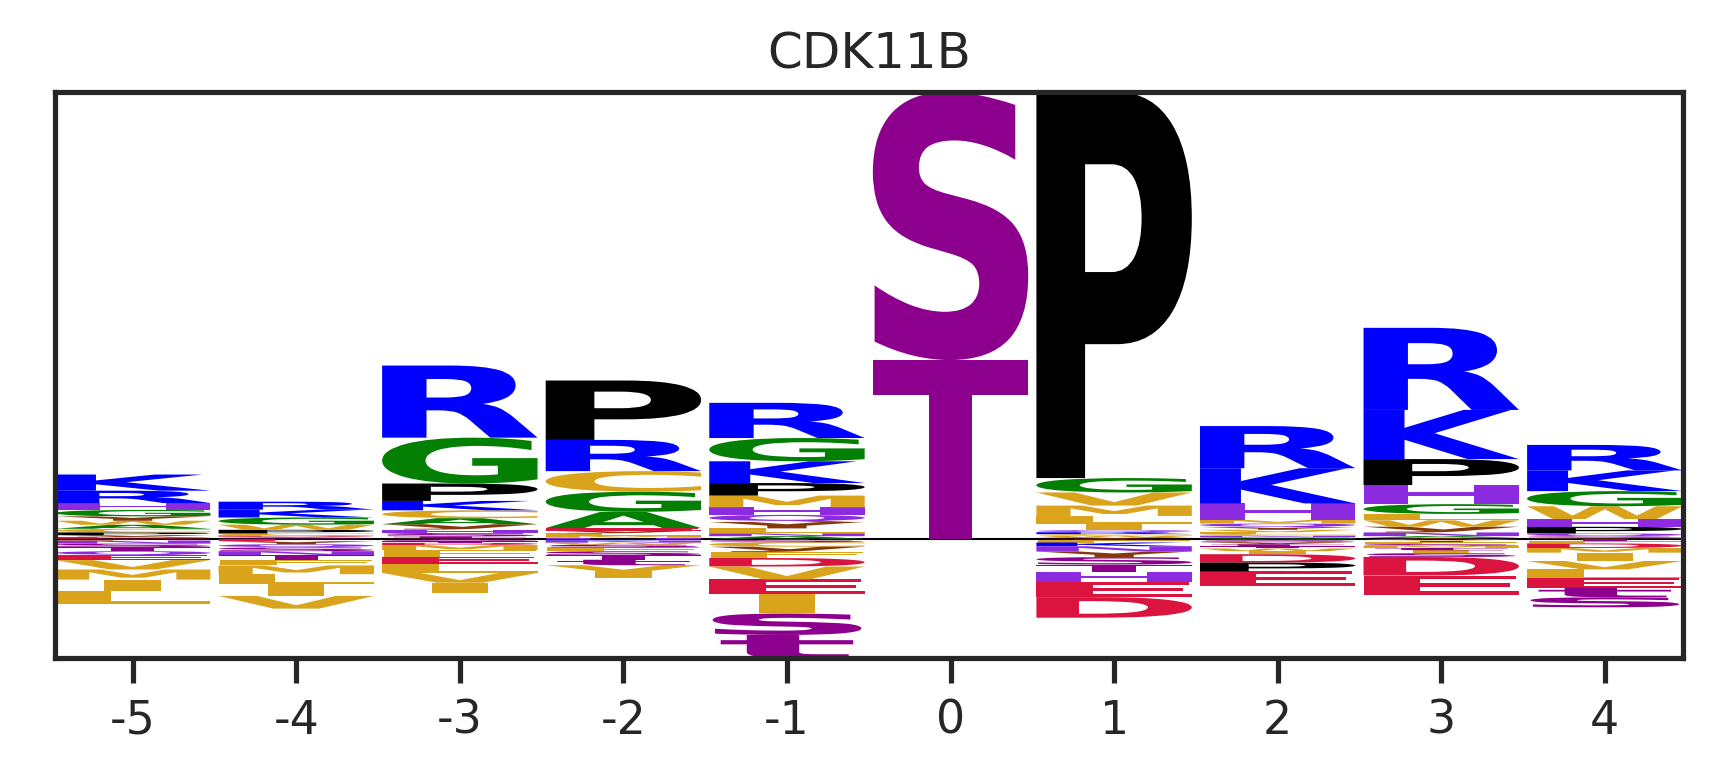

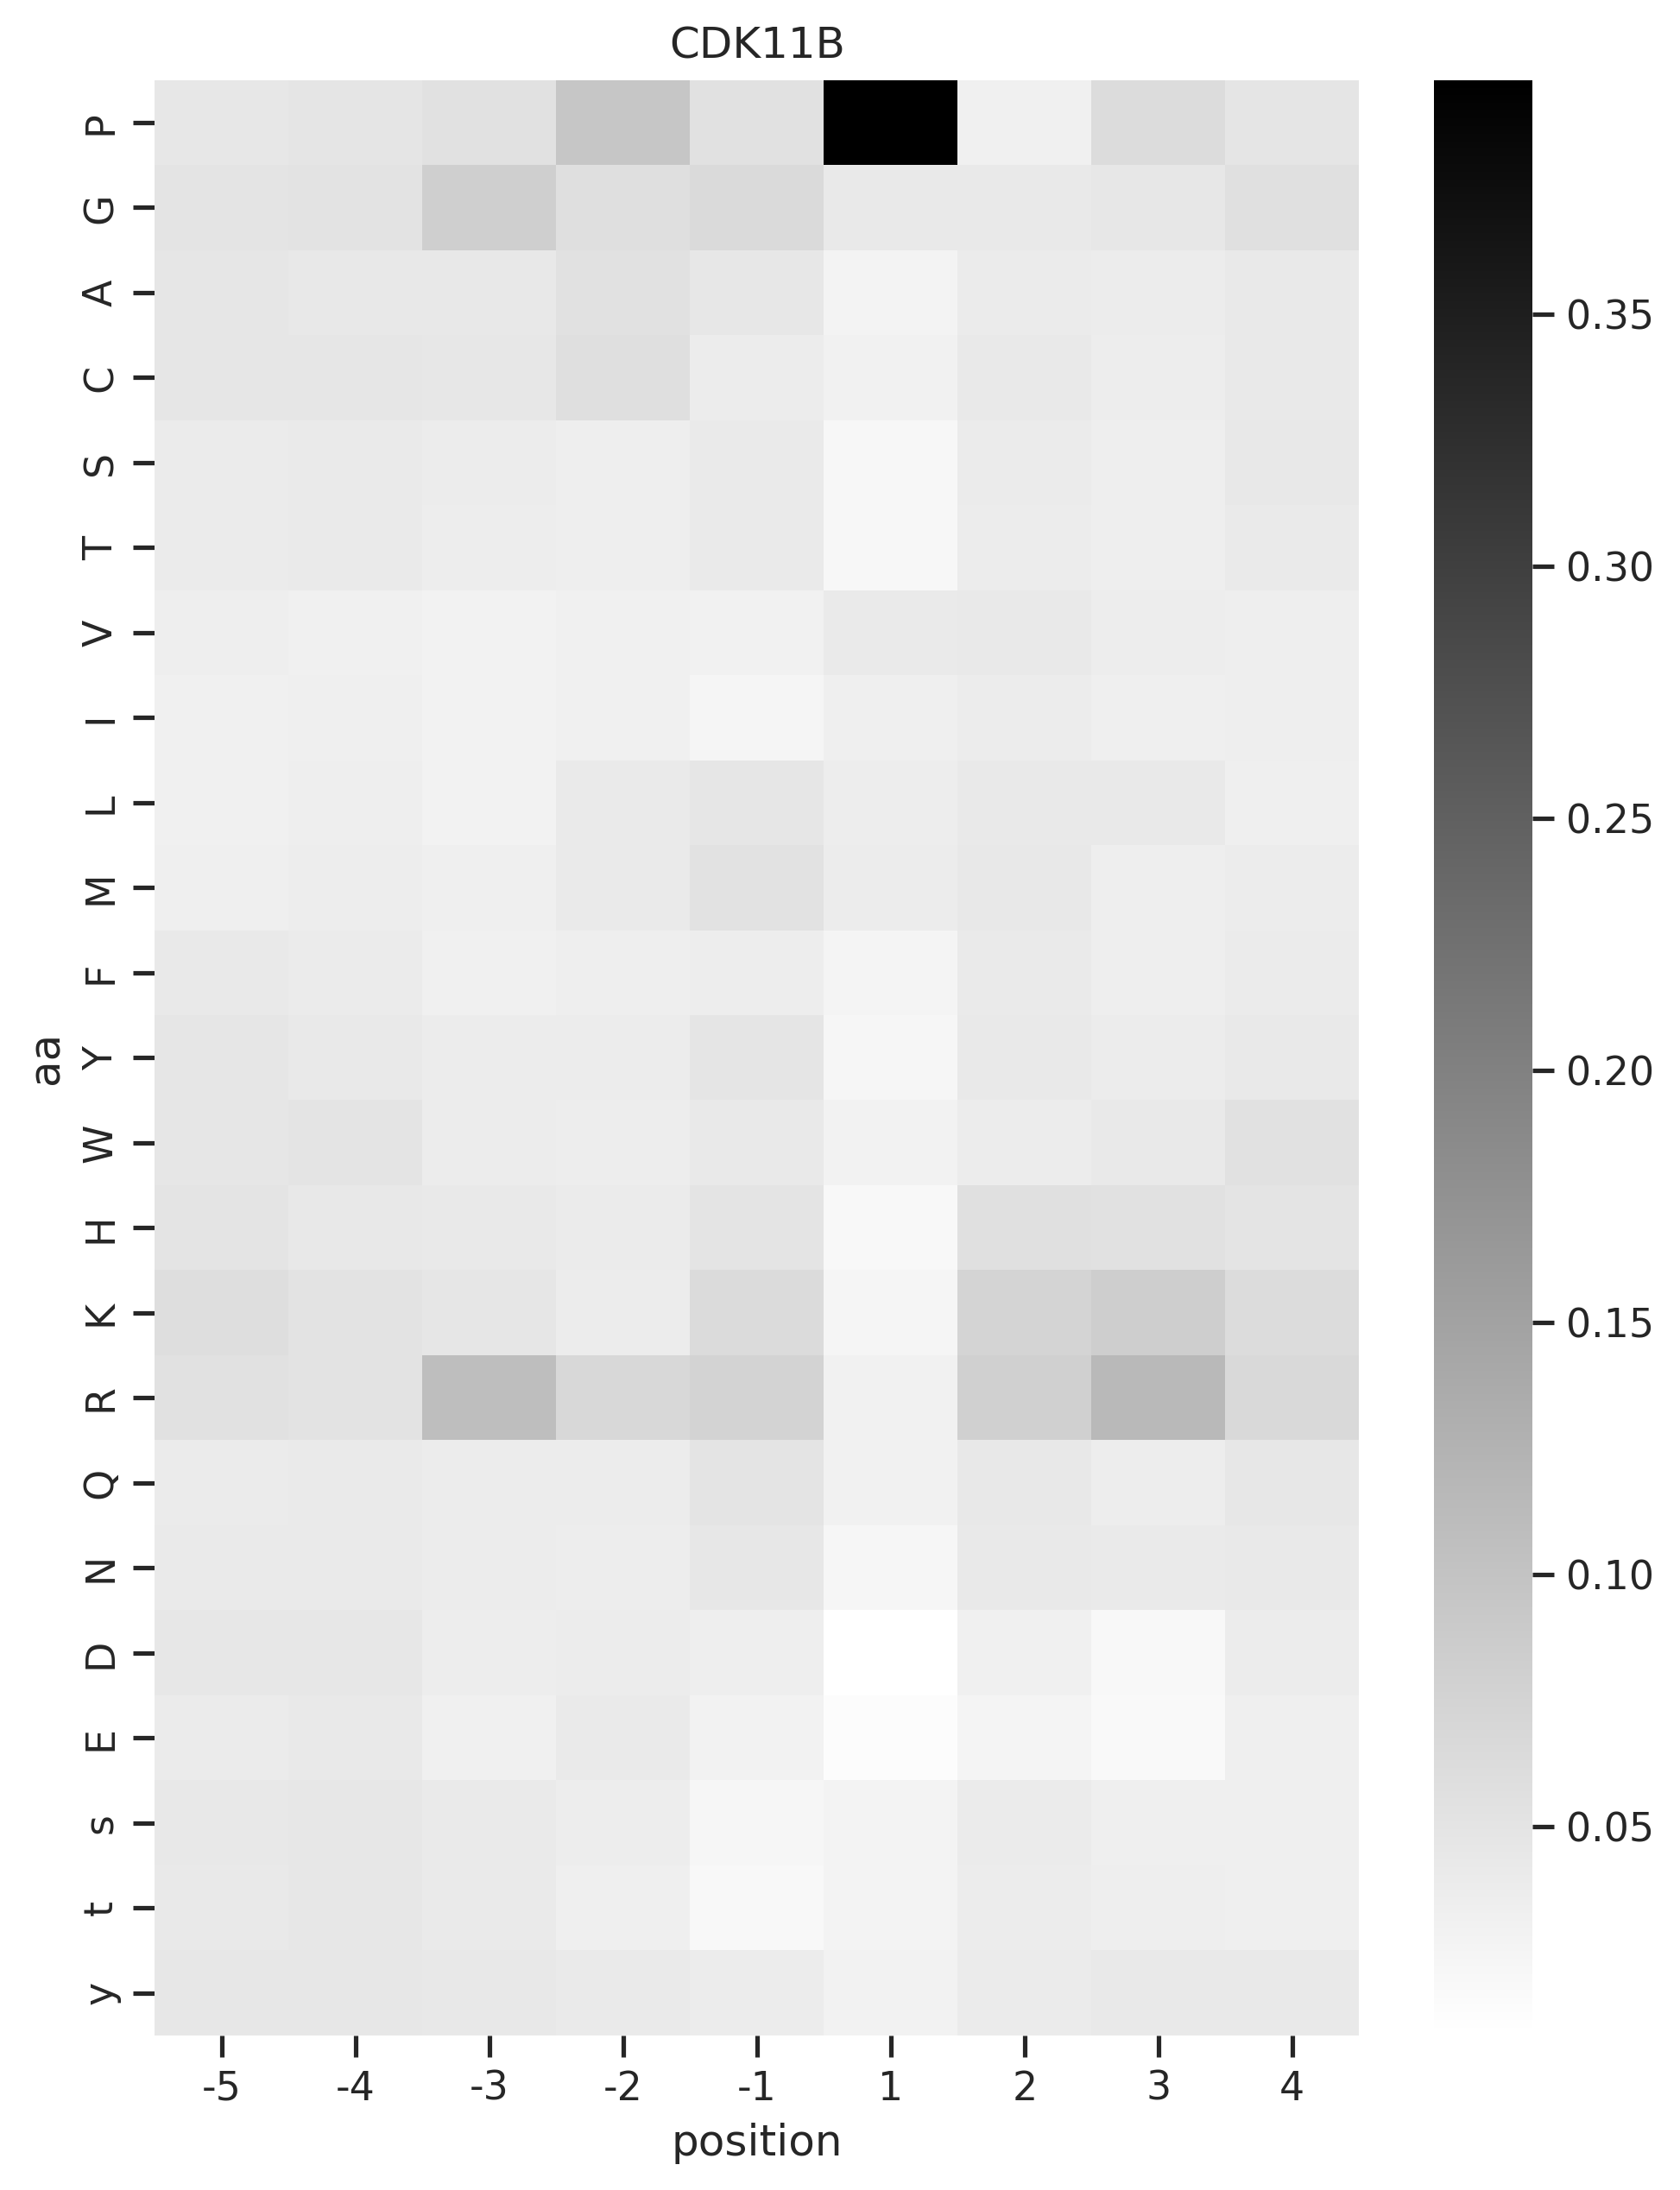

NKF1:0.7342624924789267


NKF1:0.7342624924789267


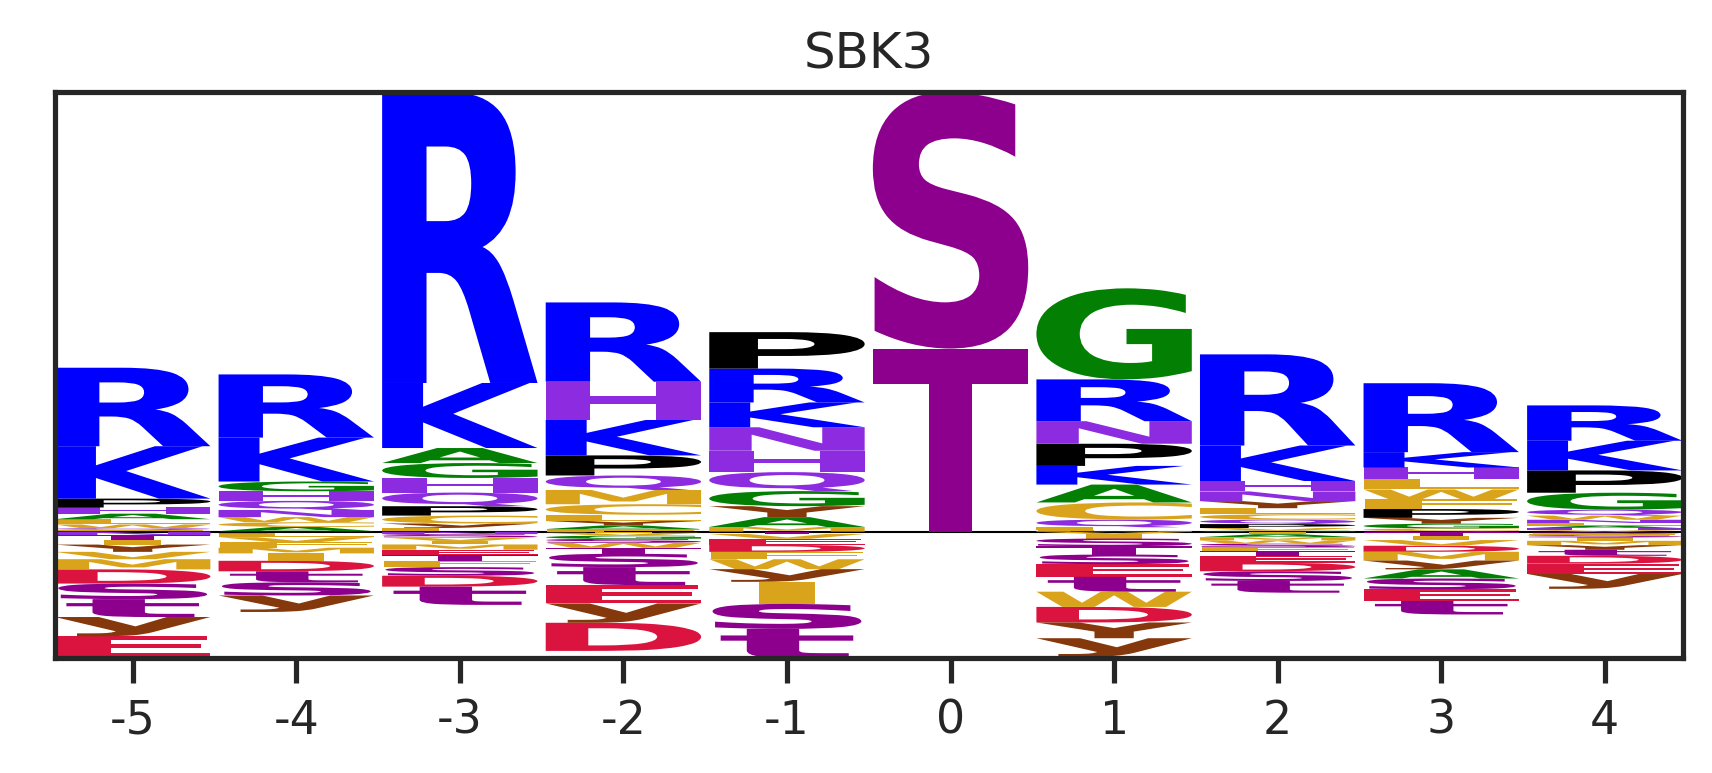

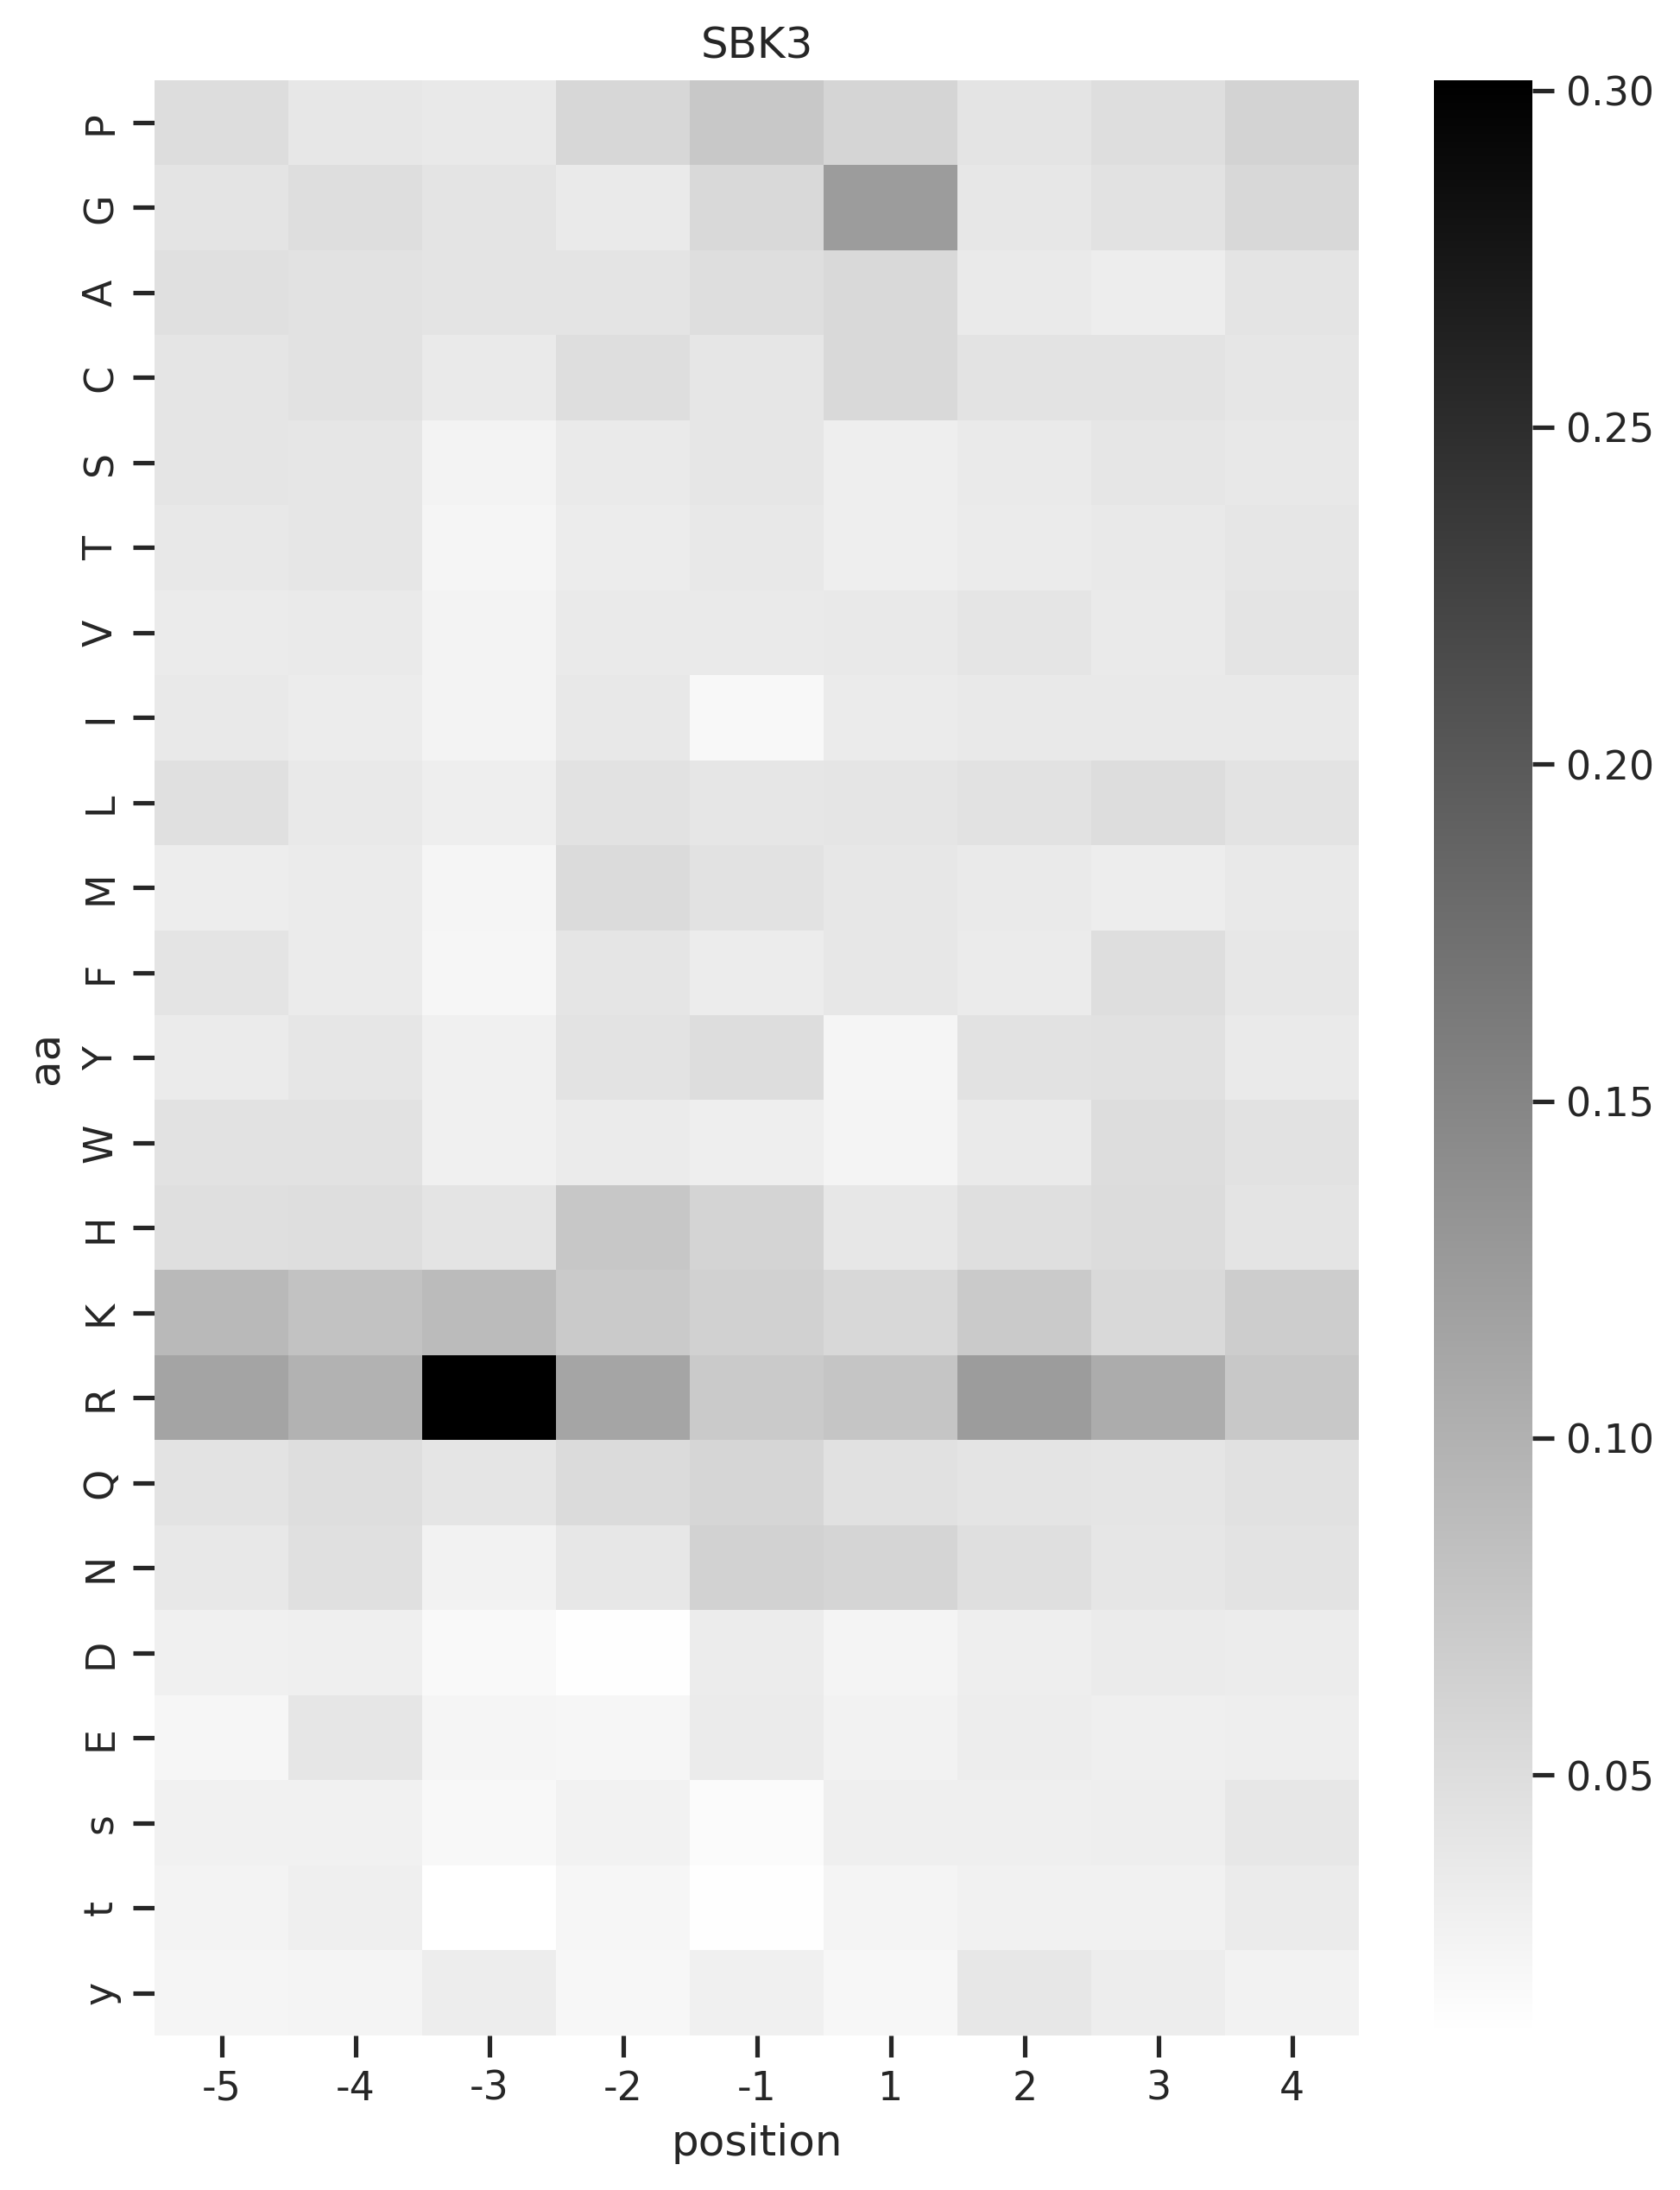

RIPK:0.62712483511819


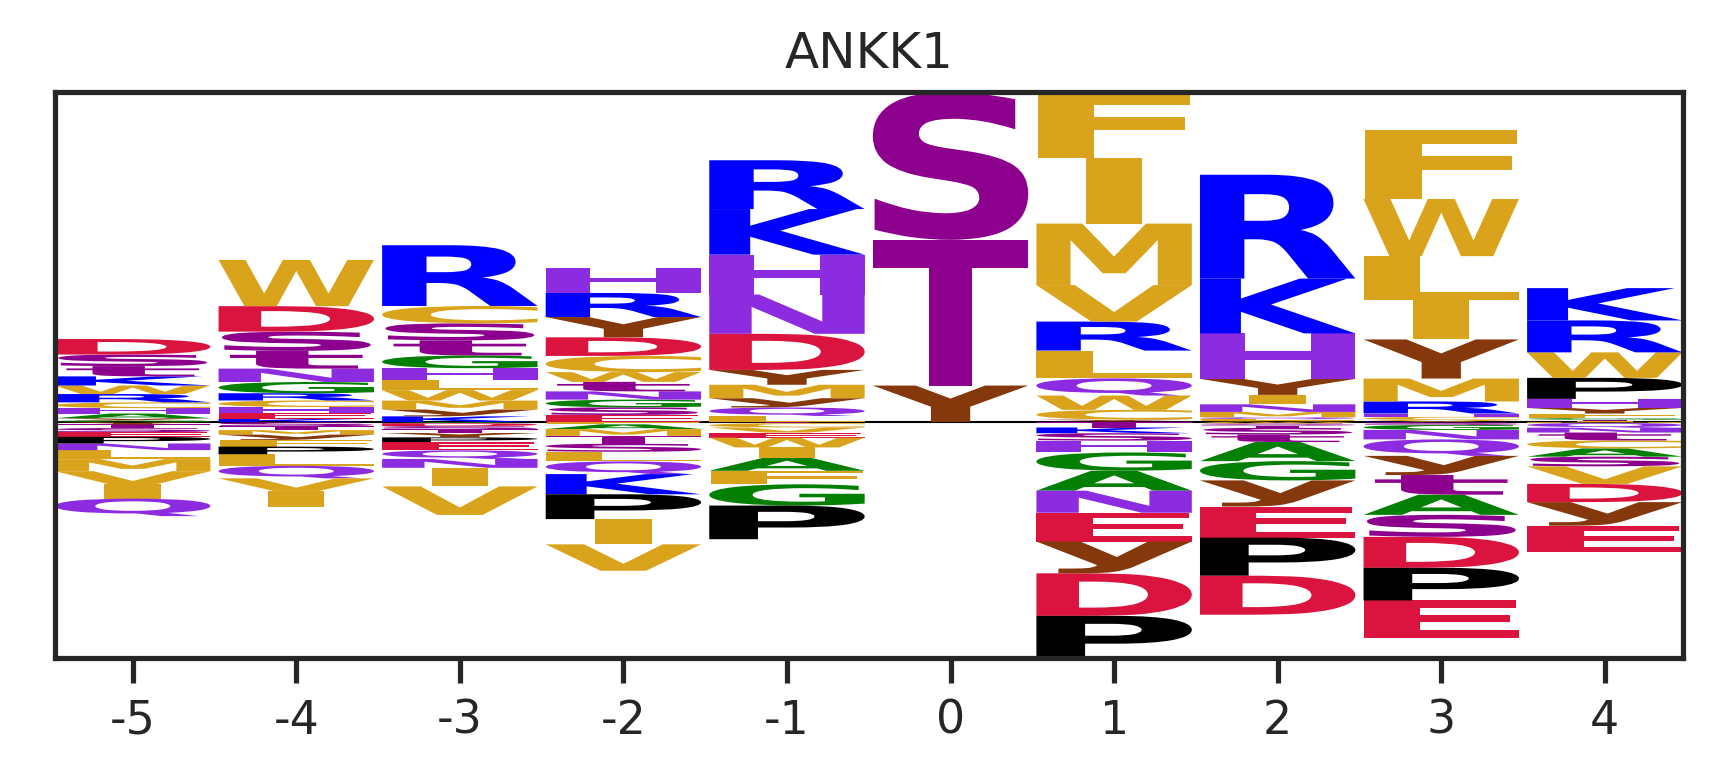

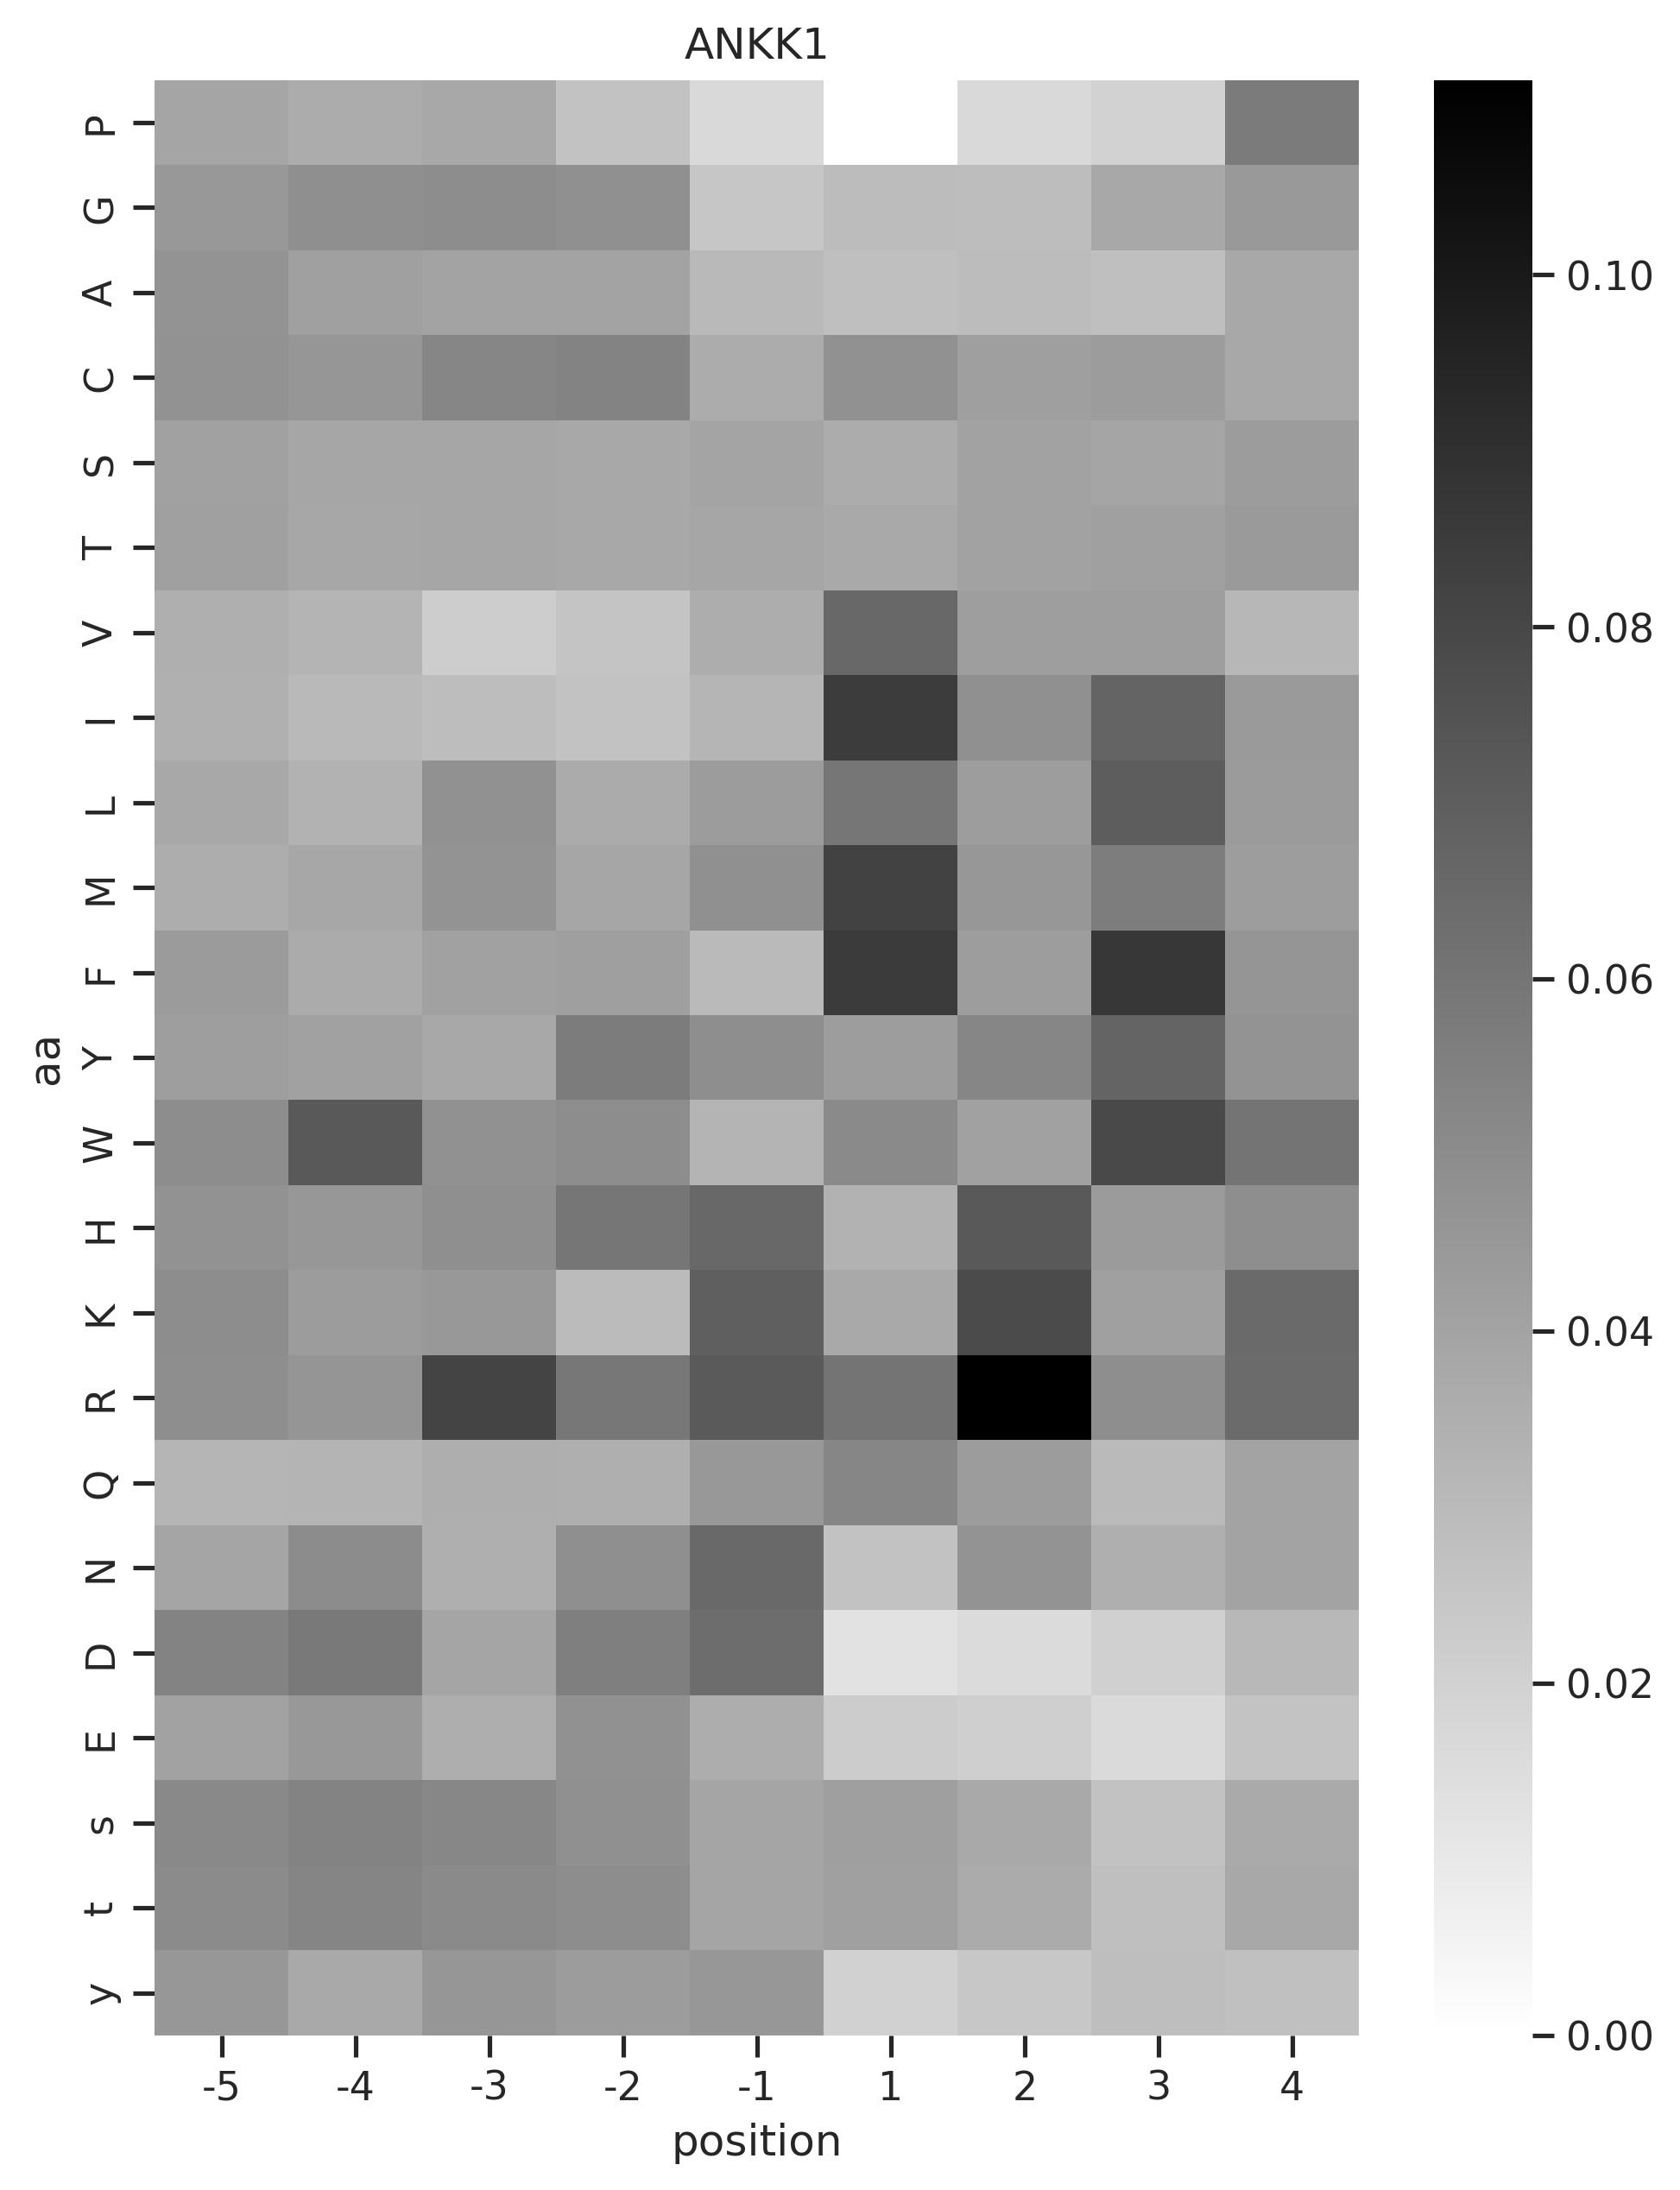

LISK:0.5764010061153408


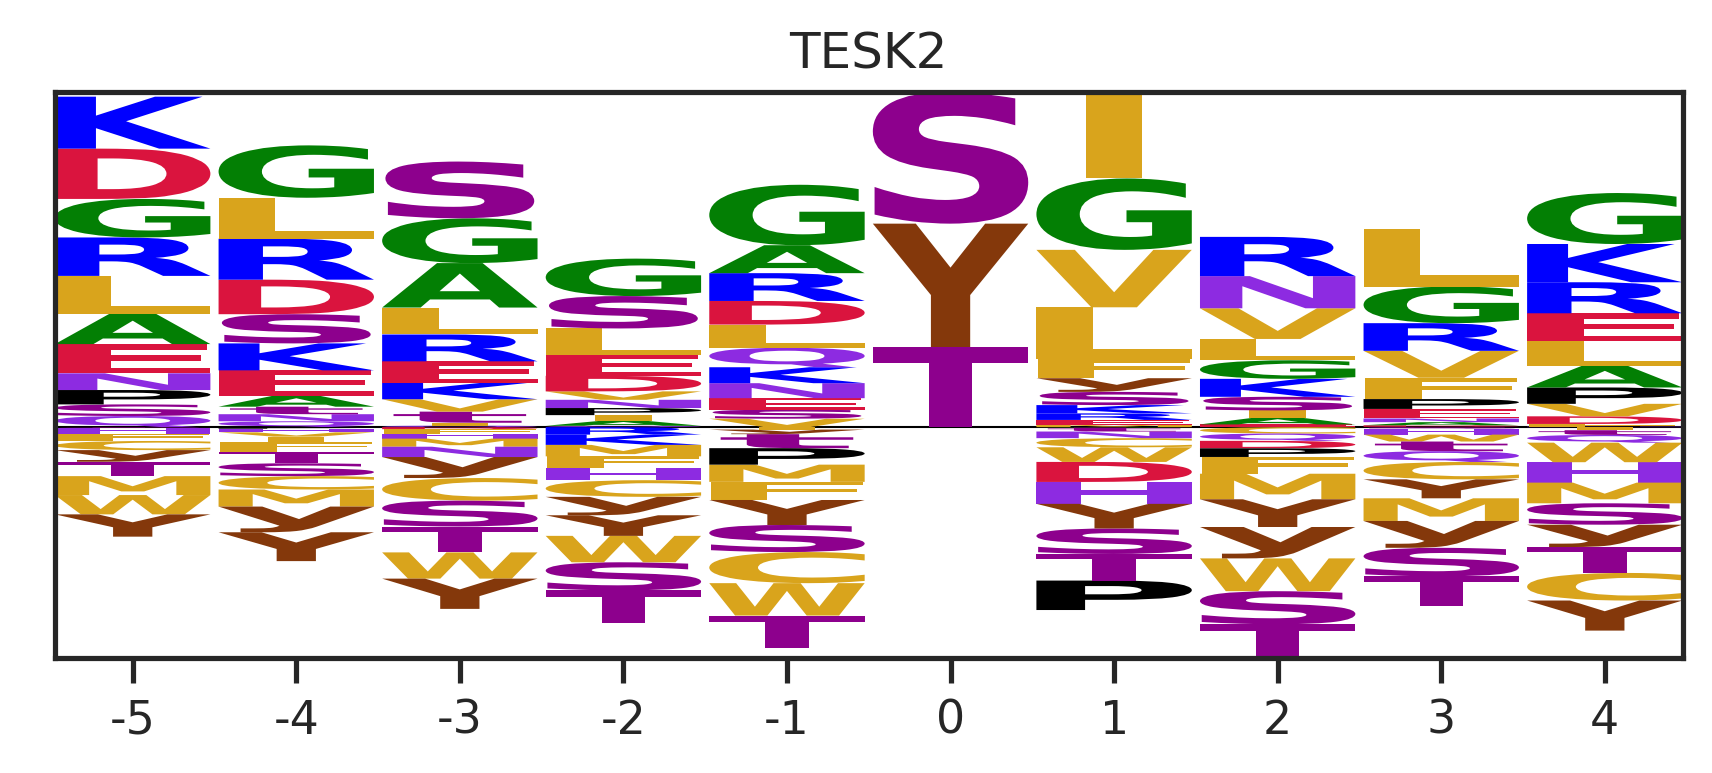

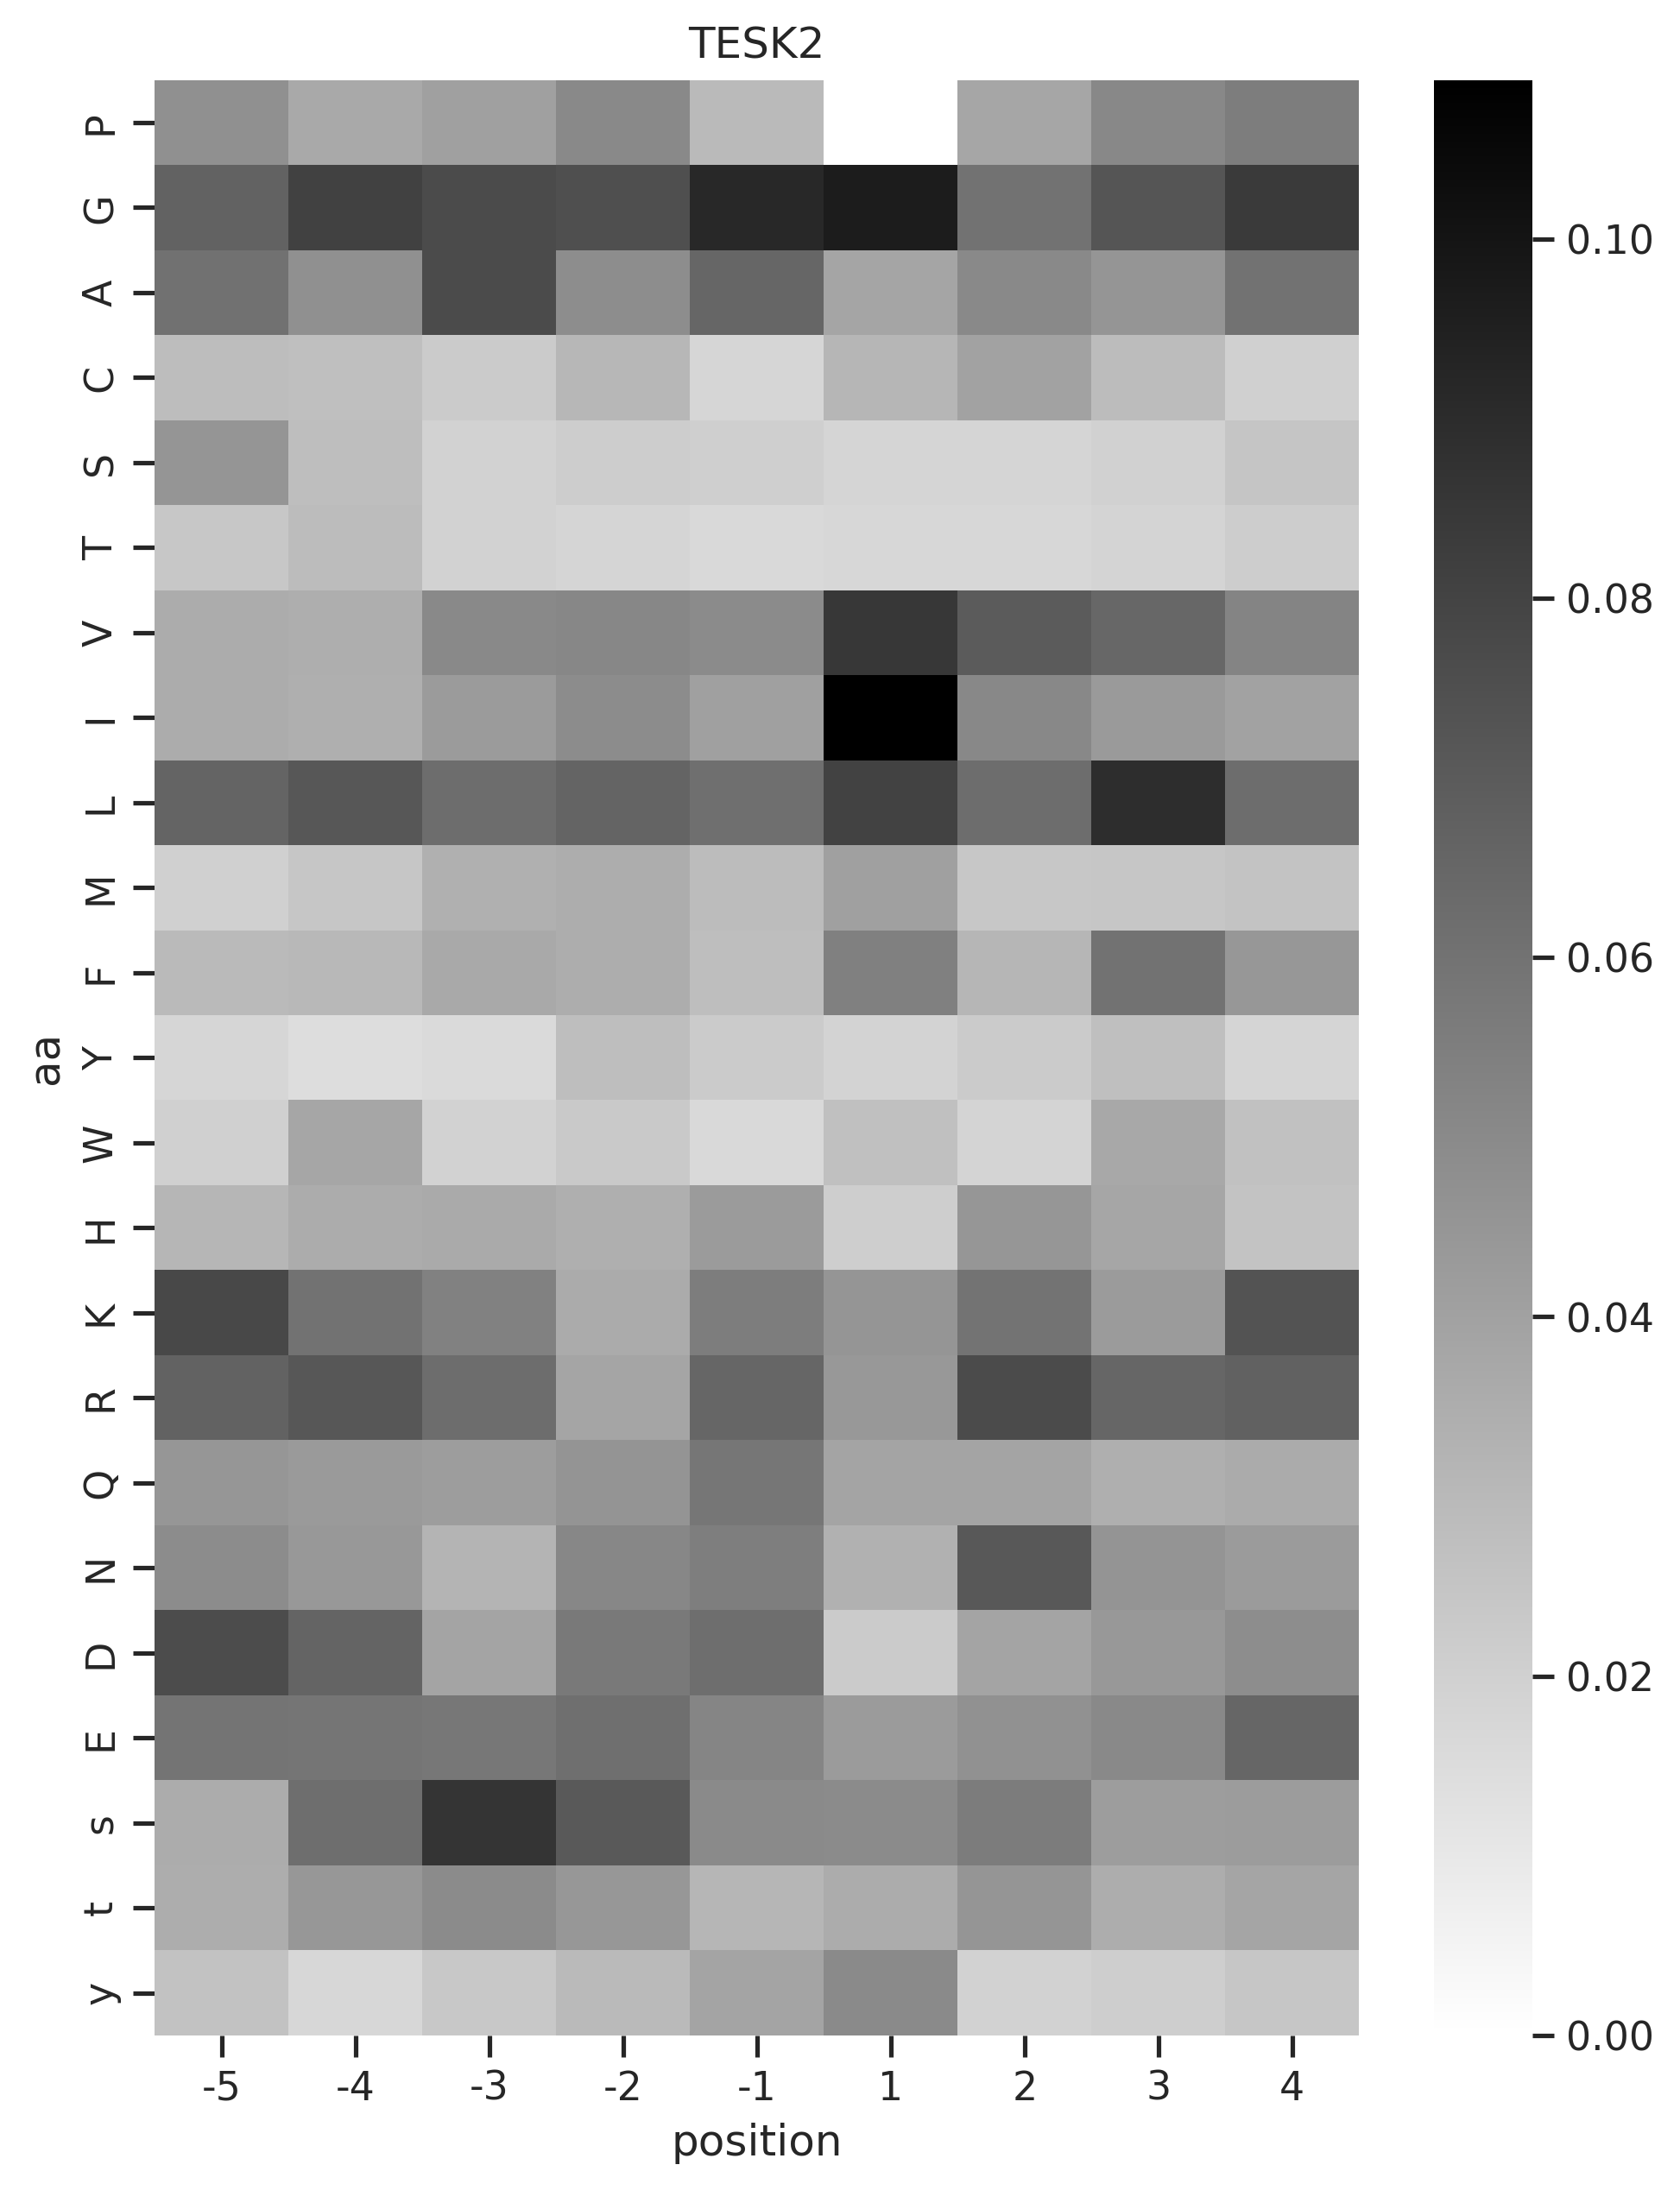

TSSK:0.8477050673723502


TSSK:0.8477050673723502


YANK:0.8166840920260132


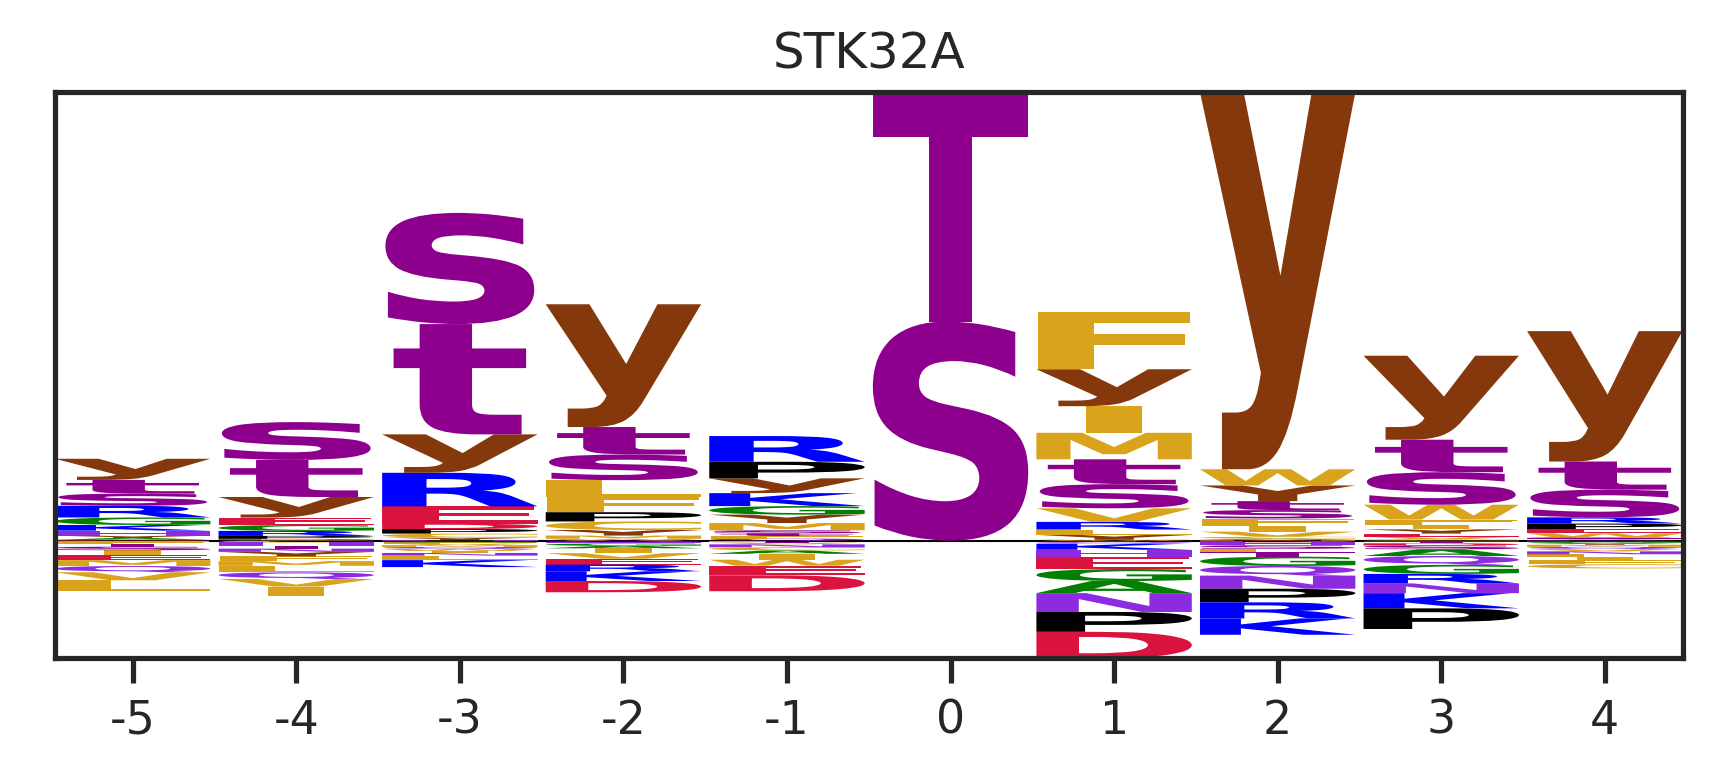

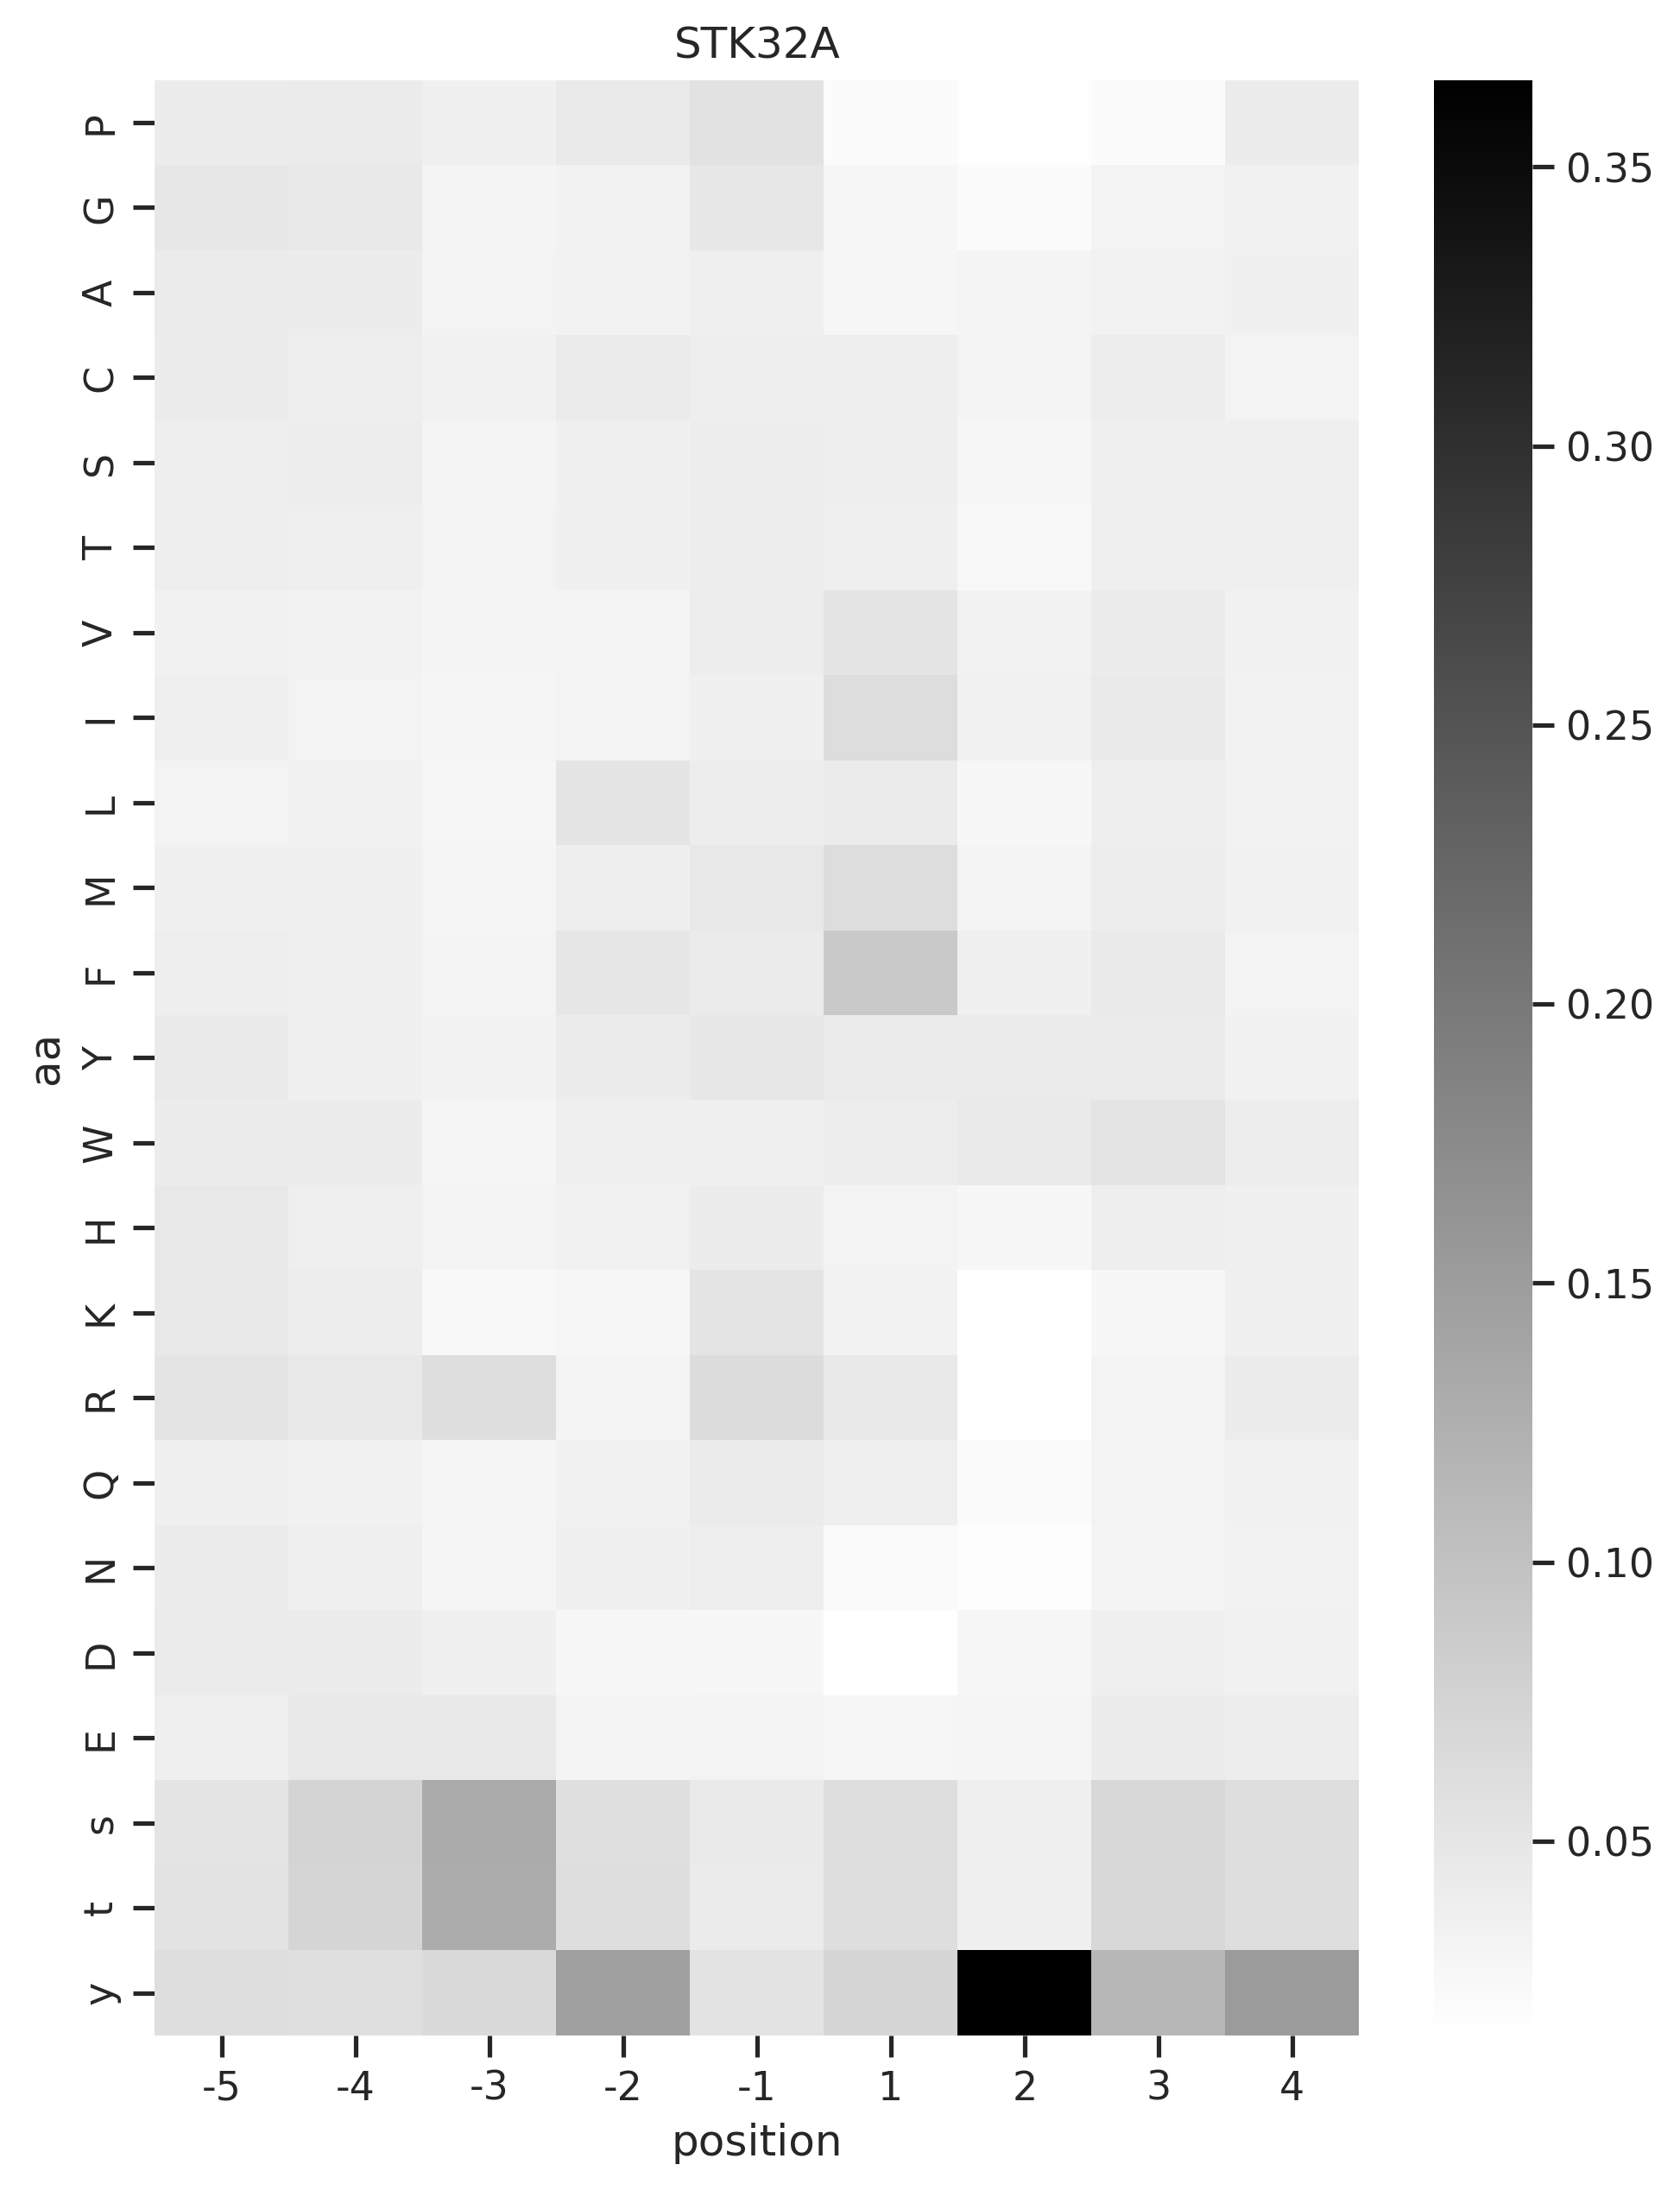

In [142]:
for i,r in selected_df.iterrows():
    print(f'{r.family}:{r.Pearson_family}')
    
    k = r.kinase
    matrix = get_one_kinase(preds_final,k,drop_s=False).T
    get_logo2(matrix, k)
    plt.show()
    plt.close()
    
    get_heatmap(preds_final.iloc[:,:-3],k)
    plt.show()
    plt.close()

## Save images

Create folder: predict/logo, predict/heatmap, predict/combine

In [ ]:
# !mkdir predict
# !mkdir predict/logo
# !mkdir predict/heatmap
# !mkdir predict/combine

In [ ]:
# clear contents in the folder
# !rm -r predict/logo/*
# !rm -r predict/heatmap/*
# !rm -r predict/combine/*

In [ ]:
# for i,r in selected.iterrows():
    
#     print(f'{r.family}:{r.Pearson_family}')
    
#     k = r.kinase
#     matrix = get_one_kinase(preds_final,k,drop_s=False).T
#     get_logo2(matrix, k)
#     plt.savefig(f'predict/logo/{k}.png',bbox_inches='tight', pad_inches=0.3) #0.3
#     plt.close()
    
#     get_heatmap(preds_final.iloc[:,:-3],k,figsize=(7.5,10))
#     plt.savefig(f'predict/heatmap/{k}.png',bbox_inches='tight', pad_inches=0)
#     plt.close()
    
#     # break

## Save and combine images for pdf

In [ ]:
def combine_images_vertically(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    total_width = max(image.width for image in images)
    total_height = sum(image.height for image in images)

    combined_image = Image.new('RGBA', (total_width, total_height))

    y_offset = 0
    for image in images:
        combined_image.paste(image, (0, y_offset), image)
        y_offset += image.height

    combined_image.save(output_path)

In [ ]:
# folders = ["predict/logo", "predict/heatmap"]

# for i,r in tqdm(selected.iterrows(),total=len(selected)):
    
#     k = r.kinase
#     filename = f"{k}.png"
#     image_paths = [os.path.join(folder, filename) for folder in folders]
#     output_path = f"predict/combine/{k}.png"
    
#     combine_images_vertically(image_paths, output_path)
#     # break

In [ ]:
# !zip -rq predict.zip predict/combine/*